---
# Capstone Scratchpad - Clustering - Adam Talbot
---

---
## Imports
---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, explained_variance_score
import statsmodels.api as sm
from statsmodels.tsa.api import Holt
from datetime import datetime

# no yelling cin the library
import warnings
warnings.filterwarnings("ignore")

# plt.rc('figure', figsize=(13, 7))c
# plt.rc('axes.spines', top=False, right=False)
# plt.rc('font', size=13)

# visualization settings
plt.rc('figure', figsize=(13, 7))
plt.rc('font', size=16)
plt.style.use('seaborn-darkgrid')
sns.set_palette('tab20')
# pal = sns.set_palette('tab20')

---
## Acquire
---

In [2]:
# get data for highest (most general) level of industry classification
df = pd.read_excel('QCEW-TX-L1.xlsx')

In [3]:
# add a column for total employment for that row
df['Total Employment'] = df['Month 1 Employment'] + df['Month 2 Employment'] + df['Month 3 Employment']

In [4]:
df.head()

Year  Period   Area         Ownership  Industry Code  \
0  2017       1  Texas  Local Government           1011   
1  2017       1  Texas           Private           1011   
2  2017       1  Texas         Total All           1011   
3  2017       2  Texas           Private           1011   
4  2017       2  Texas         Total All           1011   

                       Industry  Level  Establishments  Firms  \
0  Natural Resources and Mining      1               3      3   
1  Natural Resources and Mining      1           19547  17486   
2  Natural Resources and Mining      1           19550  17489   
3  Natural Resources and Mining      1           19522  17454   
4  Natural Resources and Mining      1           19524  17456   

   Average Employment  Average Weekly Wage  Total Wages  Month 1 Employment  \
0                   6                  659        51409                   6   
1              269033                 2562   8959344530              266172   
2              269039                 2562   8959395939              266178   
3              278215                 1879   6796444215              274576   
4              278219                 1879   6796485889              274580   

   Month 2 Employment  Month 3 Employment  Hierarchical Ordering  \
0                   6                   6                      8   
1              269297              271629                      8   
2              269303              271635                      8   
3              278259              281810                      8   
4              278263              281814                      8   

   Total Employment  
0                18  
1            807098  
2            807116  
3            834645  
4            834657

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 817 entries, 0 to 816
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Year                   817 non-null    int64 
 1   Period                 817 non-null    int64 
 2   Area                   817 non-null    object
 3   Ownership              817 non-null    object
 4   Industry Code          817 non-null    int64 
 5   Industry               817 non-null    object
 6   Level                  817 non-null    int64 
 7   Establishments         817 non-null    int64 
 8   Firms                  817 non-null    int64 
 9   Average Employment     817 non-null    int64 
 10  Average Weekly Wage    817 non-null    int64 
 11  Total Wages            817 non-null    int64 
 12  Month 1 Employment     817 non-null    int64 
 13  Month 2 Employment     817 non-null    int64 
 14  Month 3 Employment     817 non-null    int64 
 15  Hierarchical Ordering  

---
## Prepare
---

In [6]:
# figure out a way to convert the year and period columns into a single datetime format for plotting
# Convert the period number into the number of the first month for each quarter
# Q1 - 1, Q2 - 4, Q3 - 7, Q4 - 10
df['First Month'] = df.Period.apply(lambda x: '1' if x == 1 else '4' if x == 2 else '7' if x == 3 else '10')

In [7]:
# add first month to year as strings 
df['Quarter'] = df.Year.astype('string') + '-' + df['First Month']

In [8]:
# make a new column that is datetime for first day of each quarter for x axis when plotting
df['Date'] = pd.to_datetime(df.Quarter)

In [9]:
# add a column named quarter and compare to period to see if this workedd
df['Q'] = df.Date.dt.quarter
(df.Q == df.Period).mean()

1.0

In [10]:
df.head()

Year  Period   Area         Ownership  Industry Code  \
0  2017       1  Texas  Local Government           1011   
1  2017       1  Texas           Private           1011   
2  2017       1  Texas         Total All           1011   
3  2017       2  Texas           Private           1011   
4  2017       2  Texas         Total All           1011   

                       Industry  Level  Establishments  Firms  \
0  Natural Resources and Mining      1               3      3   
1  Natural Resources and Mining      1           19547  17486   
2  Natural Resources and Mining      1           19550  17489   
3  Natural Resources and Mining      1           19522  17454   
4  Natural Resources and Mining      1           19524  17456   

   Average Employment  ...  Total Wages  Month 1 Employment  \
0                   6  ...        51409                   6   
1              269033  ...   8959344530              266172   
2              269039  ...   8959395939              266178   
3              278215  ...   6796444215              274576   
4              278219  ...   6796485889              274580   

   Month 2 Employment  Month 3 Employment  Hierarchical Ordering  \
0                   6                   6                      8   
1              269297              271629                      8   
2              269303              271635                      8   
3              278259              281810                      8   
4              278263              281814                      8   

   Total Employment  First Month Quarter       Date  Q  
0                18            1  2017-1 2017-01-01  1  
1            807098            1  2017-1 2017-01-01  1  
2            807116            1  2017-1 2017-01-01  1  
3            834645            4  2017-4 2017-04-01  2  
4            834657            4  2017-4 2017-04-01  2  

[5 rows x 21 columns]

---
## Exploration
---

### Level 1 Industries

---
#### One ownership category and a few industries

In [11]:
# create new df with just totals
total_df = df[df.Ownership == 'Total All']

In [12]:
# take a look at all industries represented
ind_list = total_df.Industry.value_counts().index.tolist()
# ind_list

In [13]:
# # try for a few industries
# nrm_t = total_df[total_df.Industry == 'Natural Resources and Mining']
# ttu_t = total_df[total_df.Industry == 'Trade, Transportation and Utilities']

In [14]:
# # try to plot total wages over time
# nrm_t[['Date', 'Total Wages']].set_index('Date')['Total Wages'].plot(label='Natural Resources and Mining')
# ttu_t[['Date', 'Total Wages']].set_index('Date')['Total Wages'].plot(label='Trade, Transportation and Utilities')
# plt.gca().set(ylabel = 'Total Wages ($)', title='Level 1 Industries')
# plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}B'.format(x / 1_000_000_000))
# plt.legend(bbox_to_anchor= (1.03,1));

In [15]:
# # try to plot total wages over time
# nrm_t[['Date', 'Total Employment']].set_index('Date')['Total Employment'].plot(label='Natural Resources and Mining')
# ttu_t[['Date', 'Total Employment']].set_index('Date')['Total Employment'].plot(label='Trade, Transportation and Utilities')
# plt.gca().set(ylabel = 'Total Employment', title='Natural Resources and Mining')
# plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000));

---
#### One ownership category and all industries

In [16]:
# loop through list of industries and add to dict of dfs with key being industry name
df_dict = {}
for ind in ind_list:
    df_dict[ind] = total_df[total_df.Industry == ind]

In [17]:
# # loop through dictionary to plot all dfs on same plot
# for ind in ind_list:
#     df_dict[ind][['Date', 'Total Wages']].set_index('Date')['Total Wages'].plot(label=ind)
# plt.gca().set(ylabel = 'Total Wages ($)', title='Level 1 Industries')
# plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}B'.format(x / 1_000_000_000))
# plt.legend(bbox_to_anchor= (1.03,1));

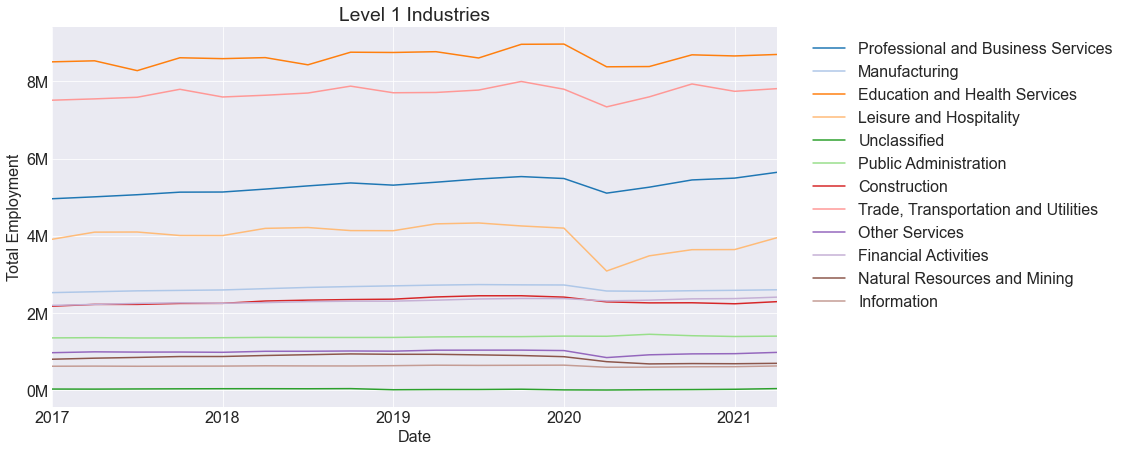

In [18]:
# do the same thing for wages
for ind in ind_list:
    df_dict[ind][['Date', 'Total Employment']].set_index('Date')['Total Employment'].plot(label=ind)
plt.gca().set(ylabel = 'Total Employment', title='Level 1 Industries')
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}M'.format(x / 1_000_000))
plt.legend(bbox_to_anchor= (1.03,1));

---
#### All ownership categories and all industries

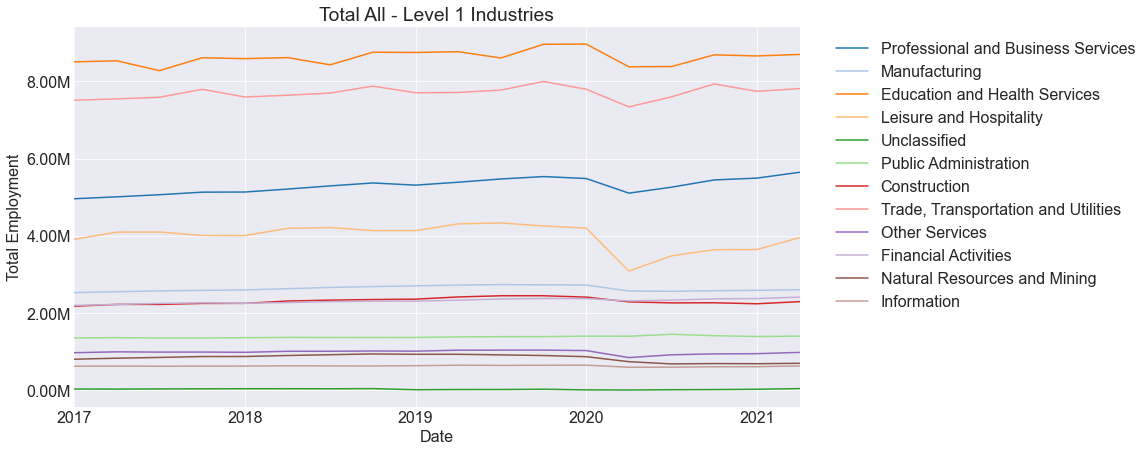

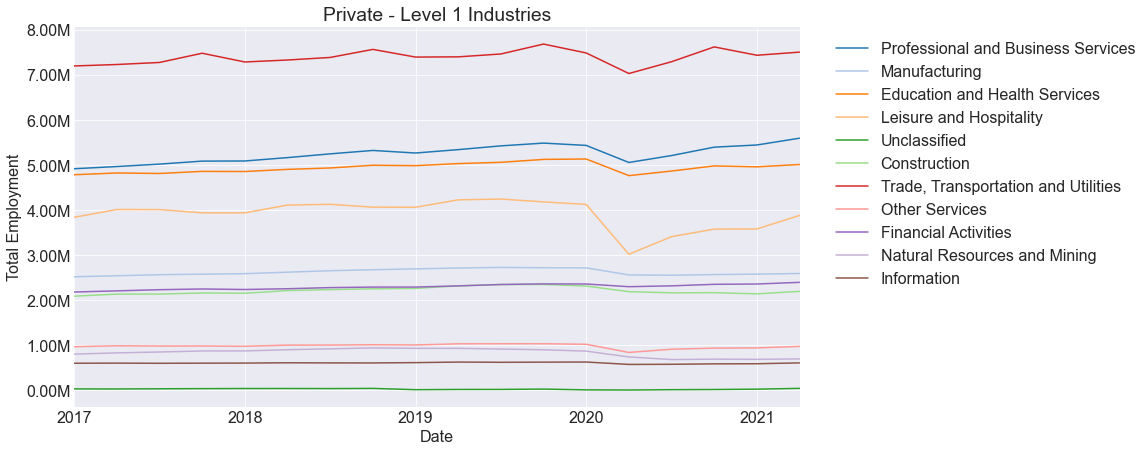

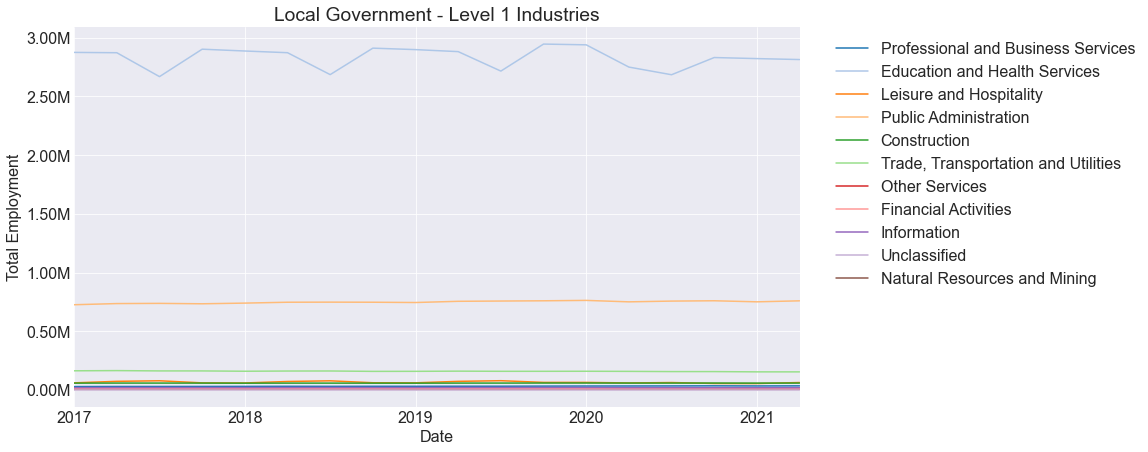

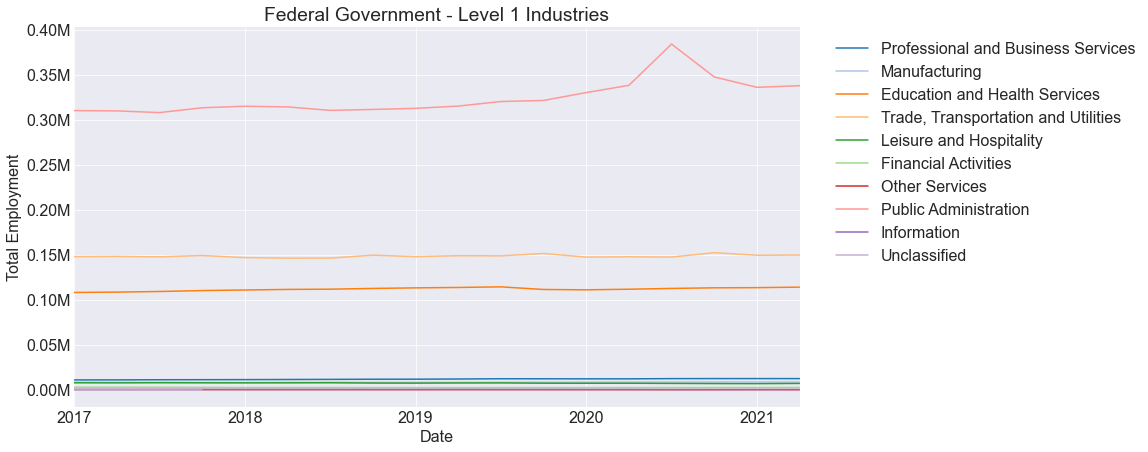

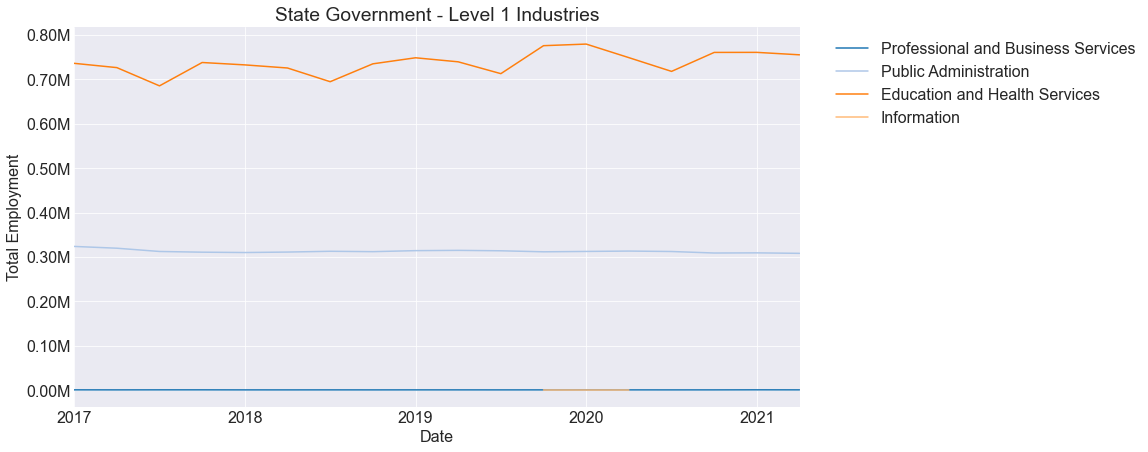

In [19]:
# do this for all ownership categories in loop
ownership_list = df.Ownership.value_counts().index.tolist()

ownership_df_dict = {}
for own in ownership_list:
    ownership_df_dict[own] = df[df.Ownership == own]

for own in ownership_list:
    ind_list = ownership_df_dict[own].Industry.value_counts().index.tolist()
    industry_df_dict = {}
    for ind in ind_list:
        industry_df_dict[ind] = ownership_df_dict[own][ownership_df_dict[own].Industry == ind]
#     for ind in ind_list:
#         industry_df_dict[ind][['Date', 'Total Wages']].set_index('Date')['Total Wages'].plot(label=ind)
#     plt.gca().set(ylabel = 'Total Wages ($)', title=f'{own} - Level 1 Industries')
#     plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.2f}B'.format(x / 1_000_000_000))
#     plt.legend(bbox_to_anchor= (1.03,1))
#     plt.show()
    for ind in ind_list:
        industry_df_dict[ind][['Date', 'Total Employment']].set_index('Date')['Total Employment'].plot(label=ind)
    plt.gca().set(ylabel = 'Total Employment', title=f'{own} - Level 1 Industries')
    plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.2f}M'.format(x / 1_000_000))
    plt.legend(bbox_to_anchor= (1.03,1))
    plt.show()

---
### Level 2 Industries
---

In [20]:
# get data for highest (most general) level of industry classification
df = pd.read_excel('QCEW-TX-L2.xlsx')

In [21]:
# add a column for total employment for that row
df['Total Employment'] = df['Month 1 Employment'] + df['Month 2 Employment'] + df['Month 3 Employment']

In [22]:
df.head()

Year  Period   Area  Ownership Industry Code  \
0  2017       1  Texas    Private            11   
1  2017       1  Texas  Total All            11   
2  2017       2  Texas    Private            11   
3  2017       2  Texas  Total All            11   
4  2017       3  Texas    Private            11   

                                     Industry  Level  Establishments  Firms  \
0  Agriculture, Forestry, Fishing and Hunting      2           10181   9992   
1  Agriculture, Forestry, Fishing and Hunting      2           10183   9994   
2  Agriculture, Forestry, Fishing and Hunting      2           10195  10005   
3  Agriculture, Forestry, Fishing and Hunting      2           10196  10006   
4  Agriculture, Forestry, Fishing and Hunting      2           10233  10046   

   Average Employment  Average Weekly Wage  Total Wages  Month 1 Employment  \
0               59382                  678    523308575               59862   
1               59385                  678    523329361               59865   
2               59688                  659    511656748               59346   
3               59689                  659    511662656               59347   
4               59478                  676    522814838               59186   

   Month 2 Employment  Month 3 Employment  Hierarchical Ordering  \
0               58939               59346                      9   
1               58942               59349                      9   
2               59635               60083                      9   
3               59636               60084                      9   
4               59716               59531                      9   

   Total Employment  
0            178147  
1            178156  
2            179064  
3            179067  
4            178433

In [23]:
# figure out a way to convert the year and period columns into a single datetime format for plotting
# Convert the period number into the number of the first month for each quarter
# Q1 - 1, Q2 - 4, Q3 - 7, Q4 - 10
df['First Month'] = df.Period.apply(lambda x: '1' if x == 1 else '4' if x == 2 else '7' if x == 3 else '10')

In [24]:
# add first month to year as strings 
df['Quarter'] = df.Year.astype('string') + '-' + df['First Month']

In [25]:
# make a new column that is datetime for first day of each quarter for x axis when plotting
df['Date'] = pd.to_datetime(df.Quarter)

---
#### All ownership categories and all industries

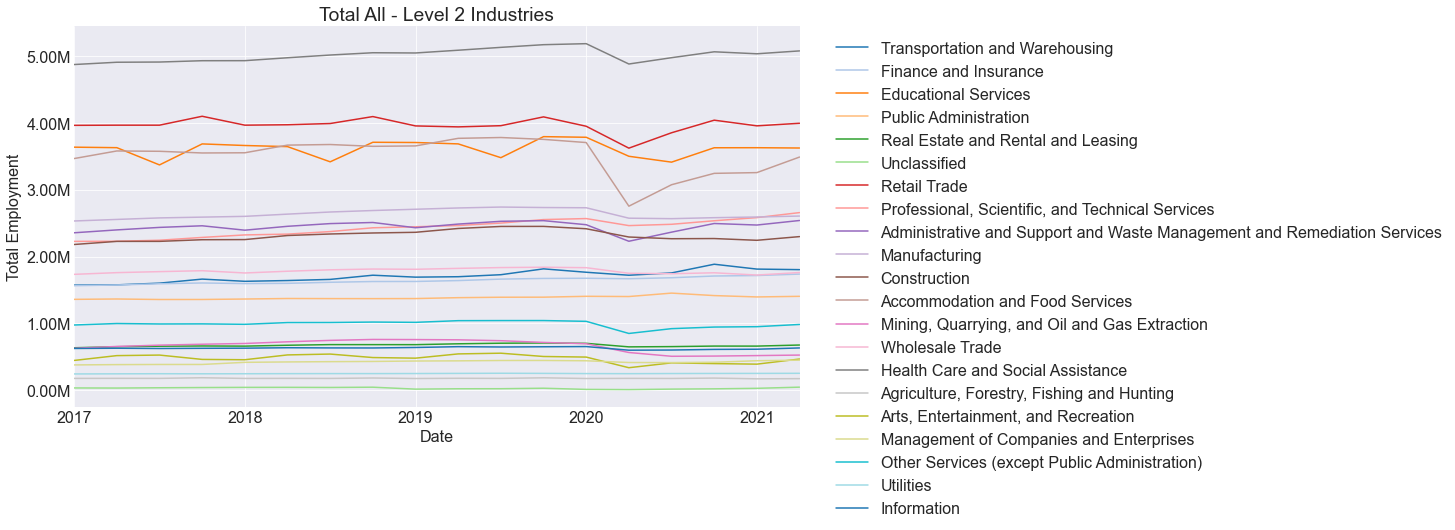

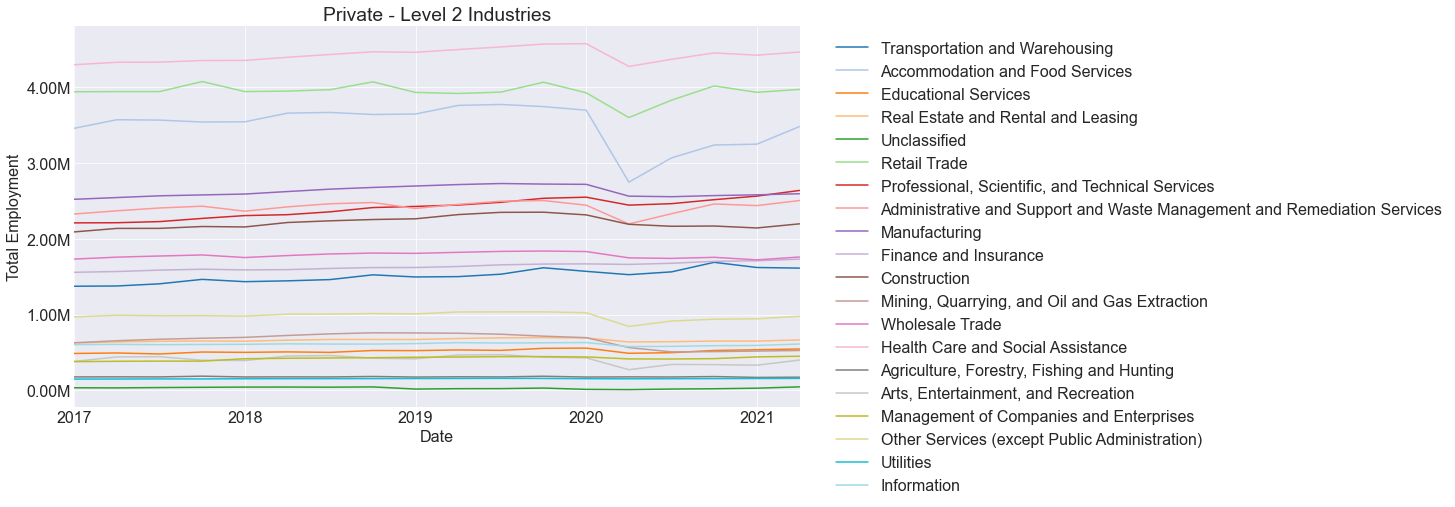

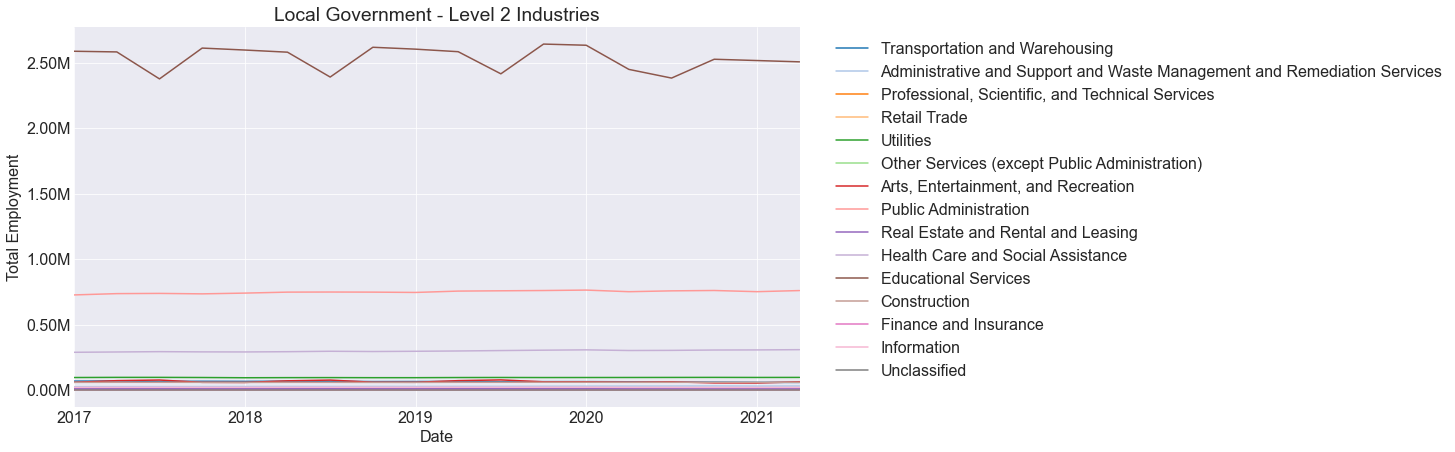

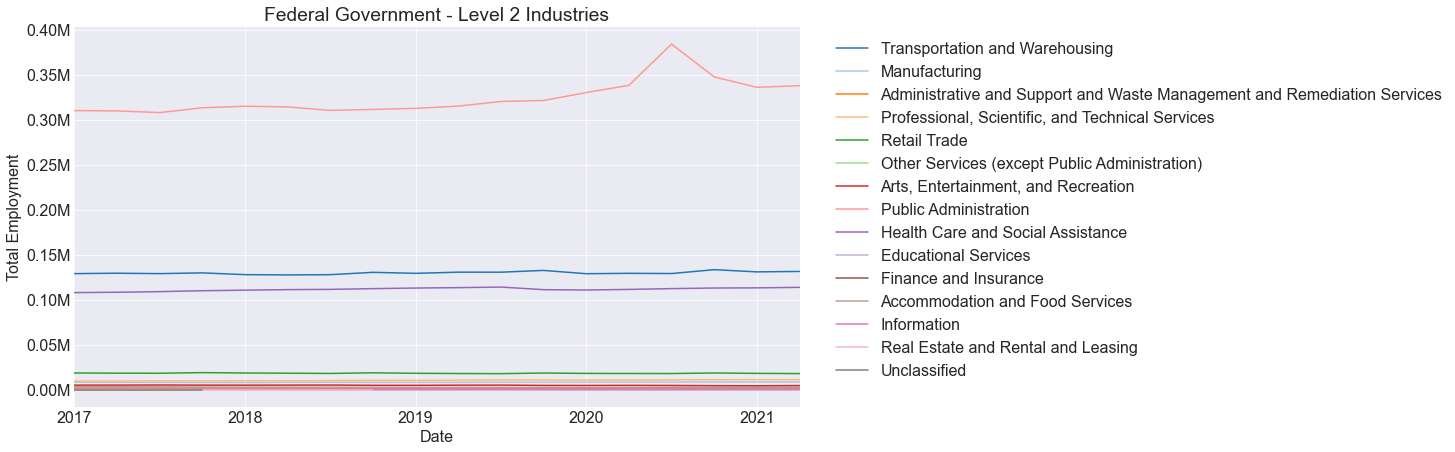

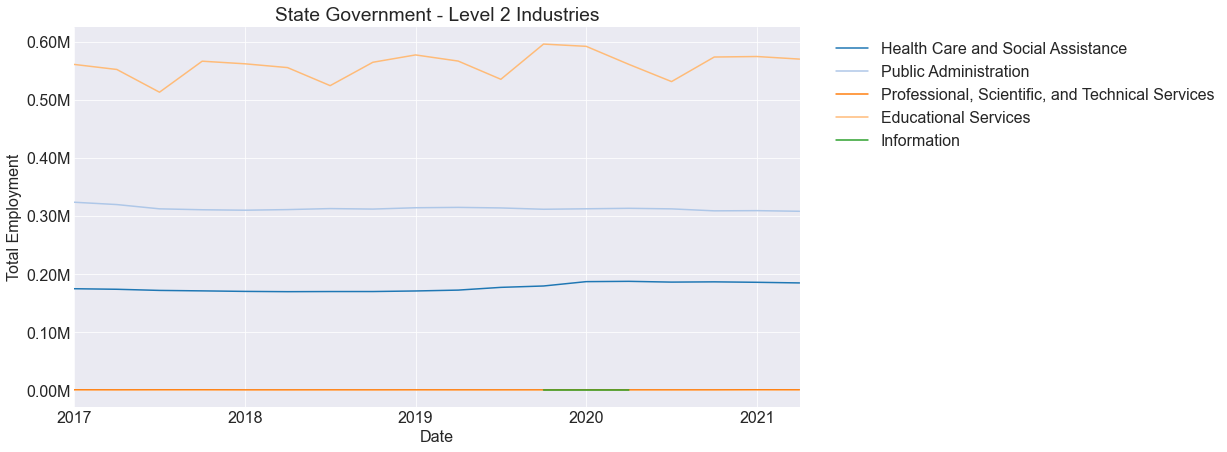

In [26]:
# do this for all ownership categories in loop
ownership_list = df.Ownership.value_counts().index.tolist()

ownership_df_dict = {}
for own in ownership_list:
    ownership_df_dict[own] = df[df.Ownership == own]

for own in ownership_list:
    ind_list = ownership_df_dict[own].Industry.value_counts().index.tolist()
    industry_df_dict = {}
    for ind in ind_list:
        industry_df_dict[ind] = ownership_df_dict[own][ownership_df_dict[own].Industry == ind]
#     for ind in ind_list:
#         industry_df_dict[ind][['Date', 'Total Wages']].set_index('Date')['Total Wages'].plot(label=ind)
#     plt.gca().set(ylabel = 'Total Wages ($)', title=f'{own} - Level 2 Industries')
#     plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.2f}B'.format(x / 1_000_000_000))
#     plt.legend(bbox_to_anchor= (1.03,1))
#     plt.show()
    for ind in ind_list:
        industry_df_dict[ind][['Date', 'Total Employment']].set_index('Date')['Total Employment'].plot(label=ind)
    plt.gca().set(ylabel = 'Total Employment', title=f'{own} - Level 2 Industries')
    plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.2f}M'.format(x / 1_000_000))
    plt.legend(bbox_to_anchor= (1.03,1))
    plt.show()

---
### Level 3 Industries
---

In [27]:
# get data for highest (most general) level of industry classification
df = pd.read_excel('QCEW-TX-L3.xlsx')

In [28]:
# add a column for total employment for that row
df['Total Employment'] = df['Month 1 Employment'] + df['Month 2 Employment'] + df['Month 3 Employment']

In [29]:
# figure out a way to convert the year and period columns into a single datetime format for plotting
# Convert the period number into the number of the first month for each quarter
# Q1 - 1, Q2 - 4, Q3 - 7, Q4 - 10
df['First Month'] = df.Period.apply(lambda x: '1' if x == 1 else '4' if x == 2 else '7' if x == 3 else '10')

In [30]:
# add first month to year as strings 
df['Quarter'] = df.Year.astype('string') + '-' + df['First Month']

In [31]:
# make a new column that is datetime for first day of each quarter for x axis when plotting
df['Date'] = pd.to_datetime(df.Quarter)

---
#### All ownership categories and all industries

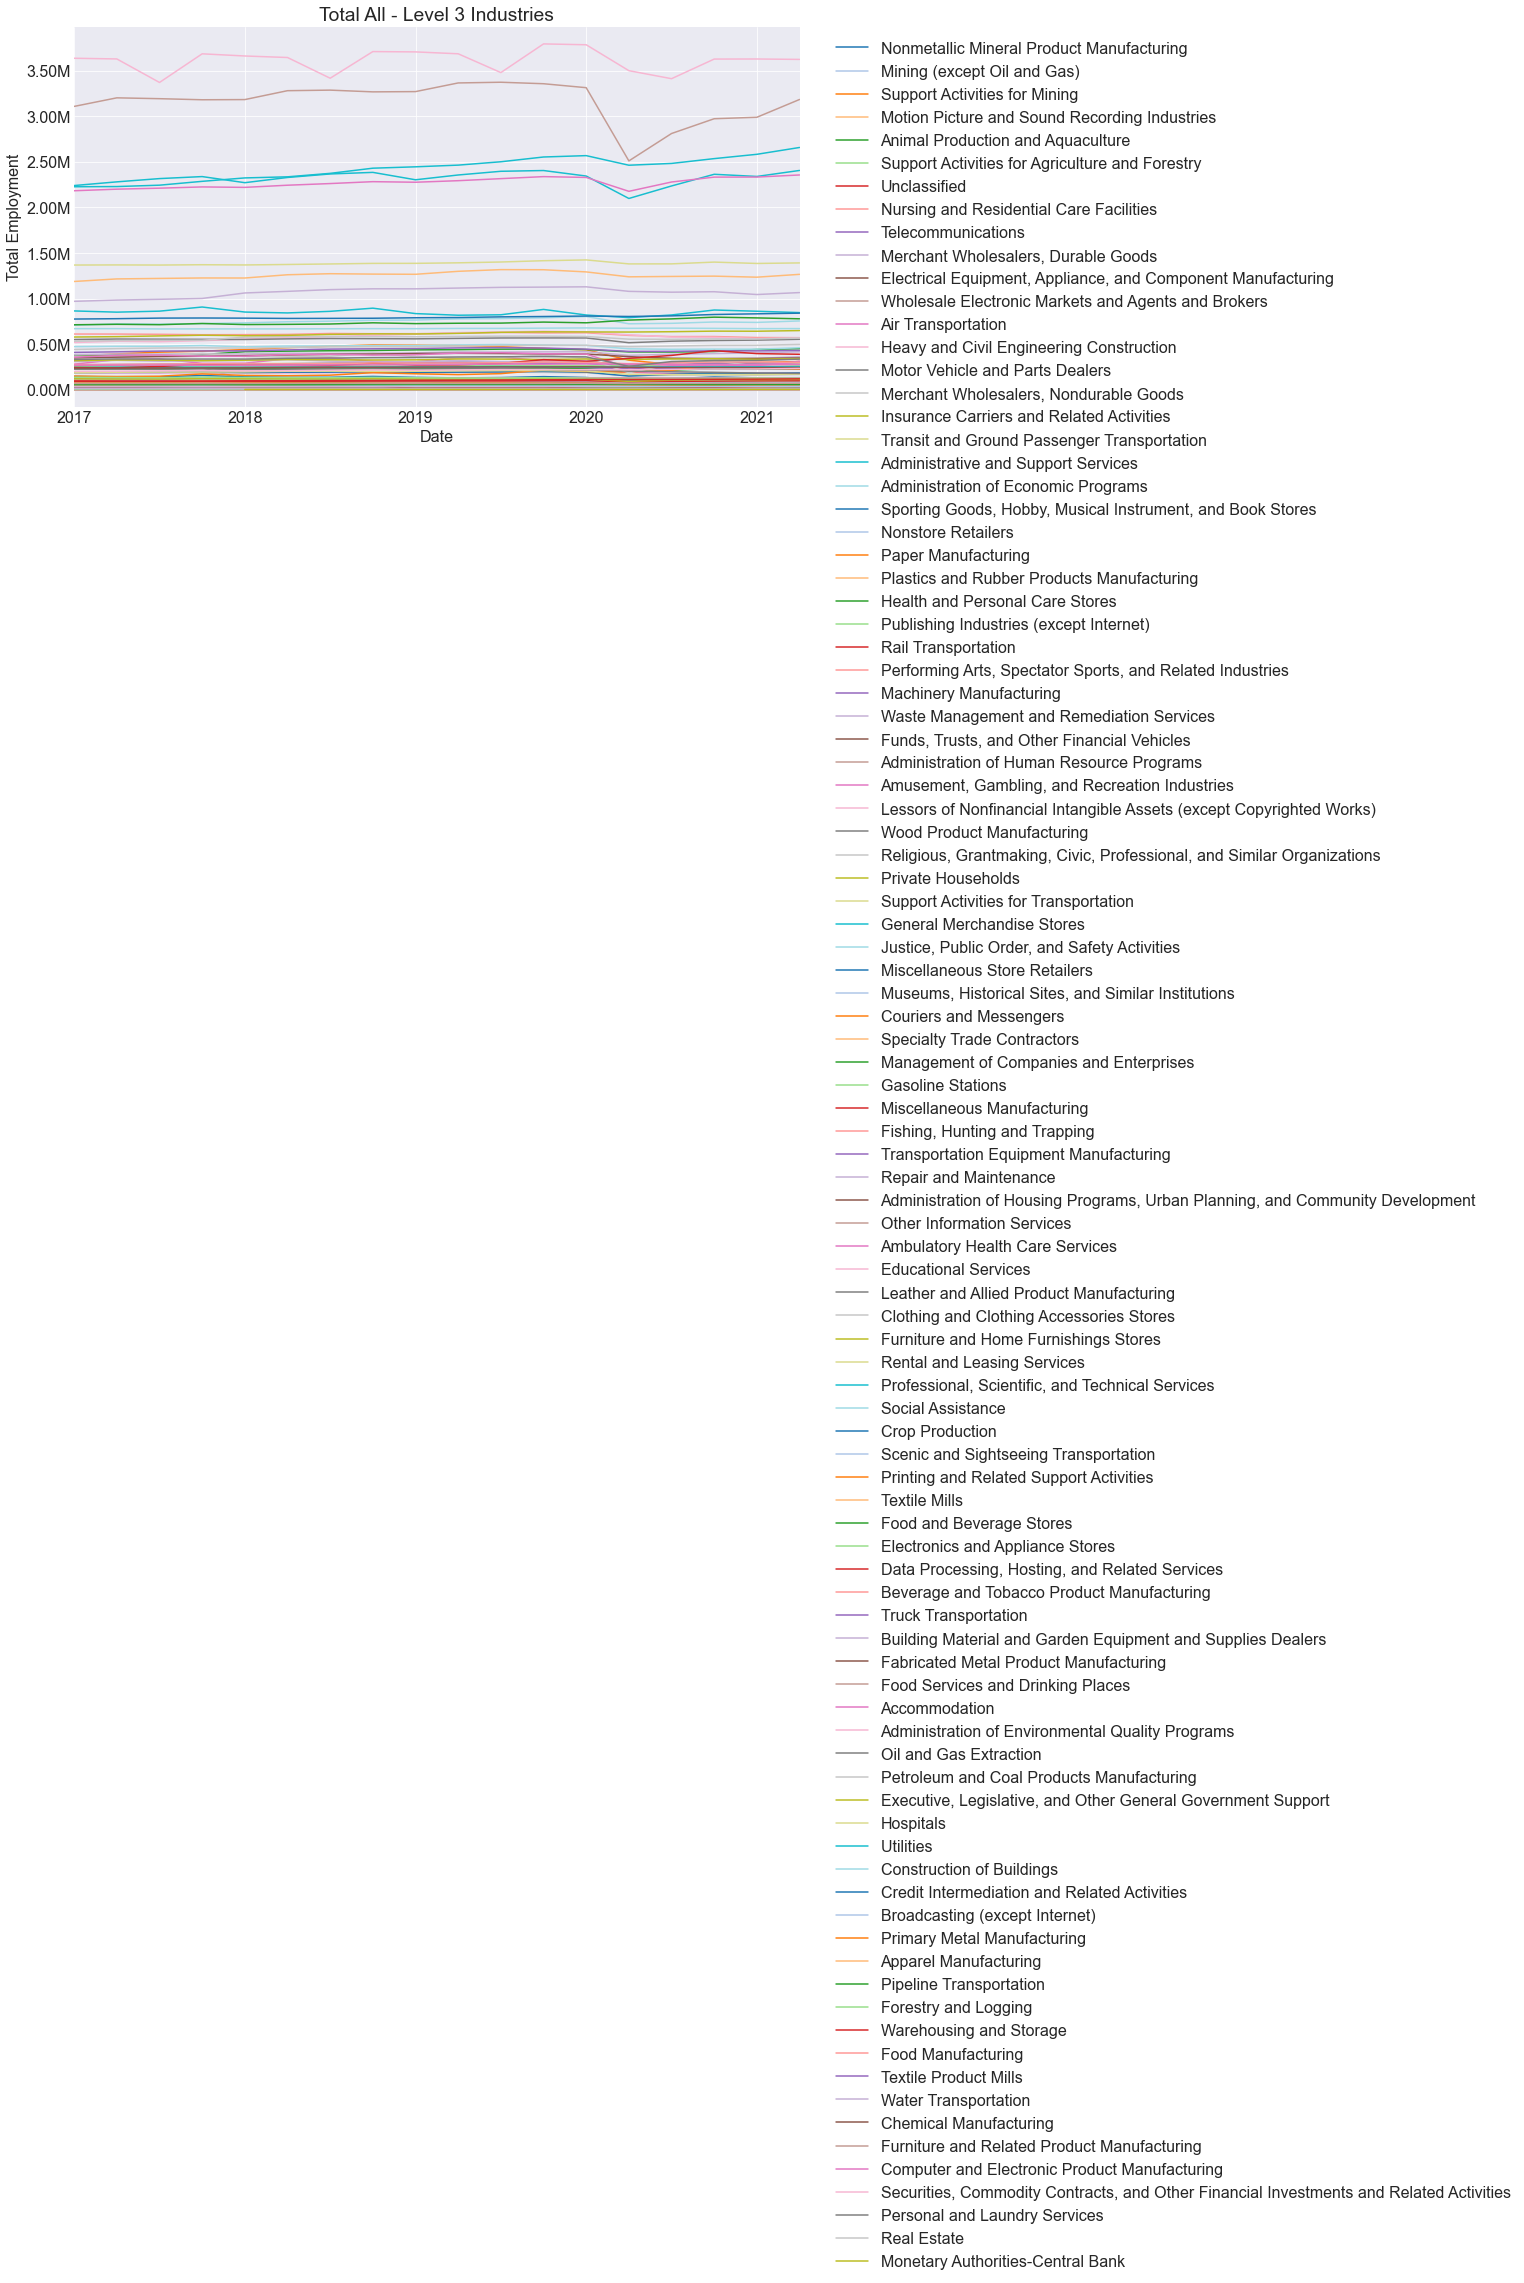

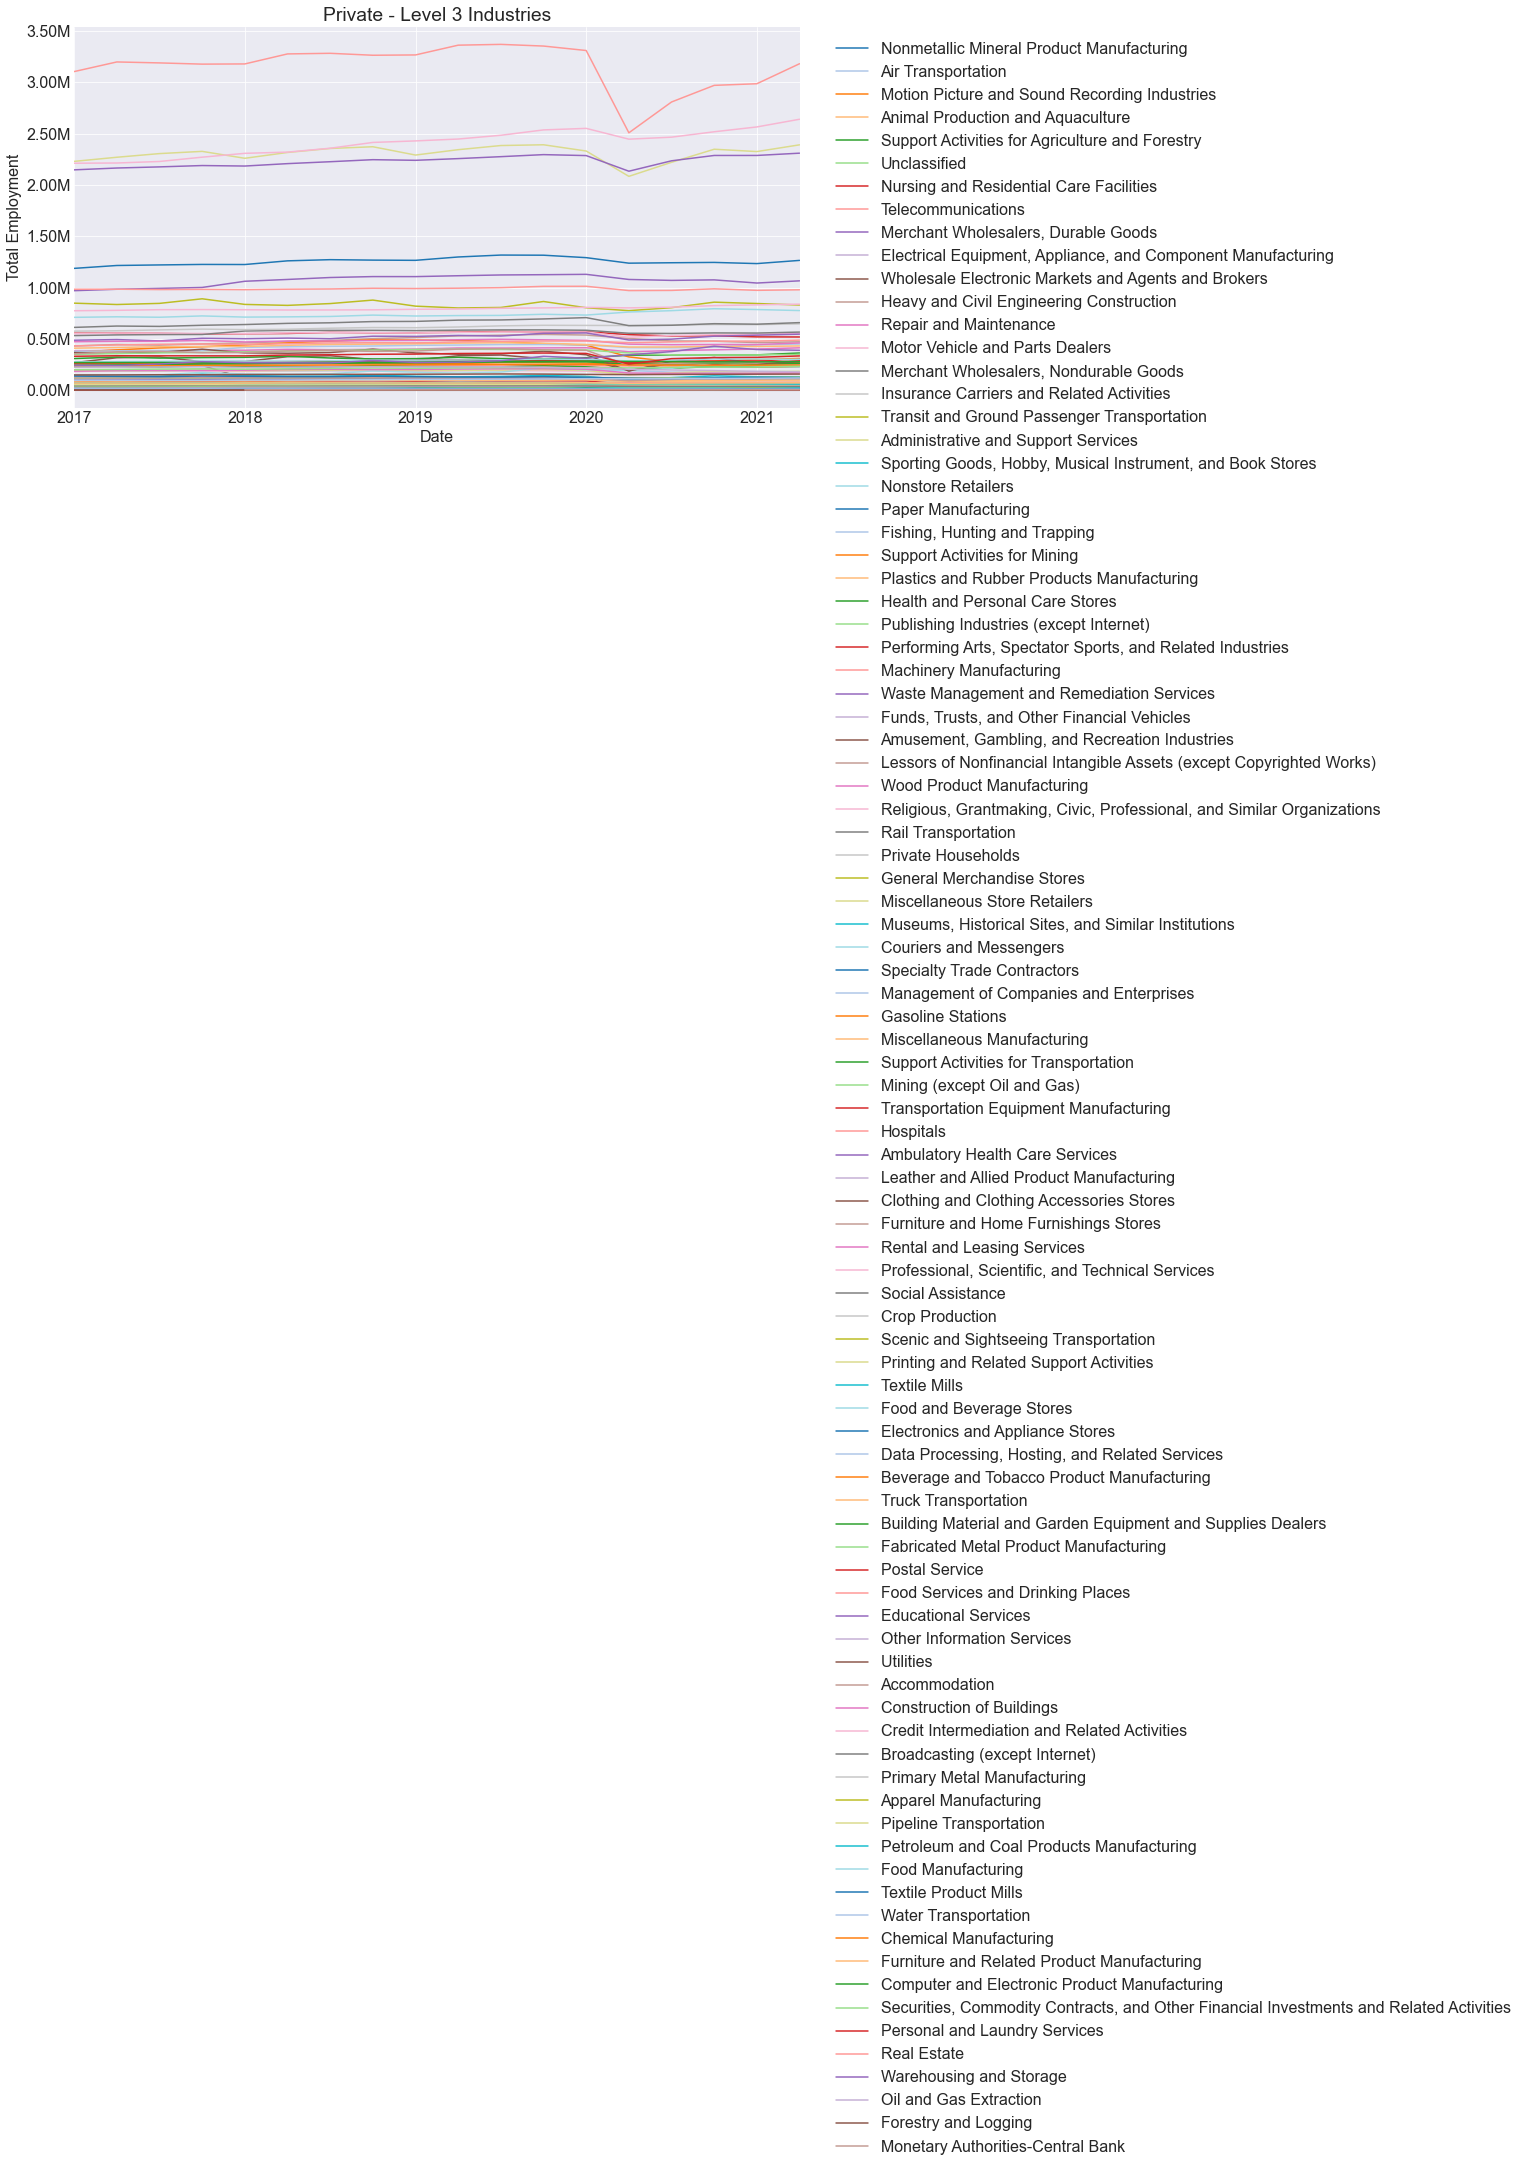

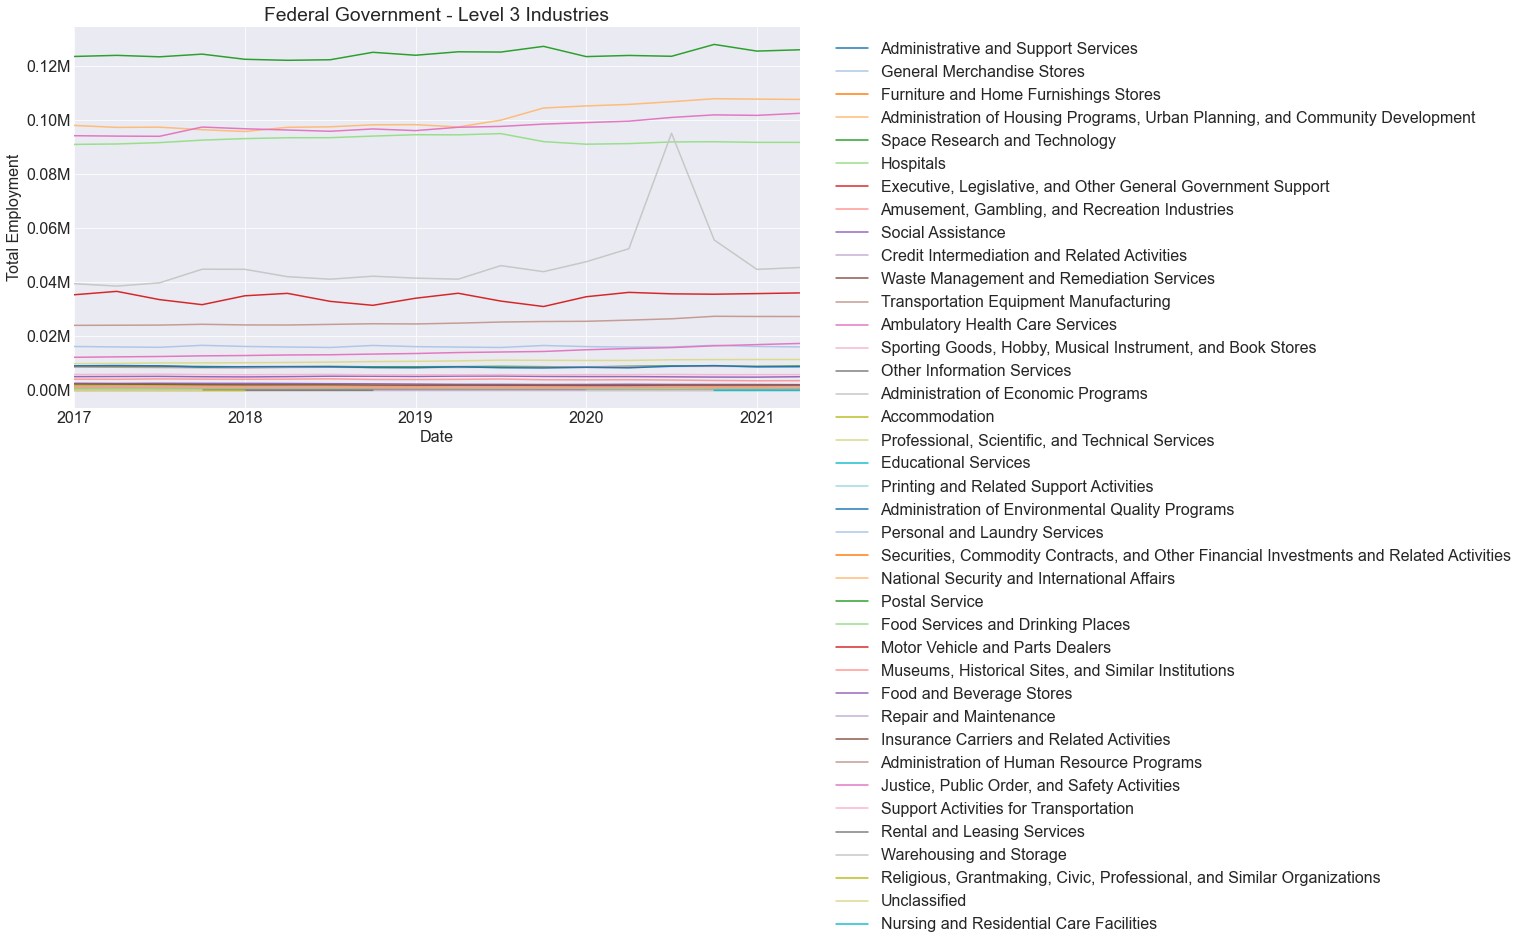

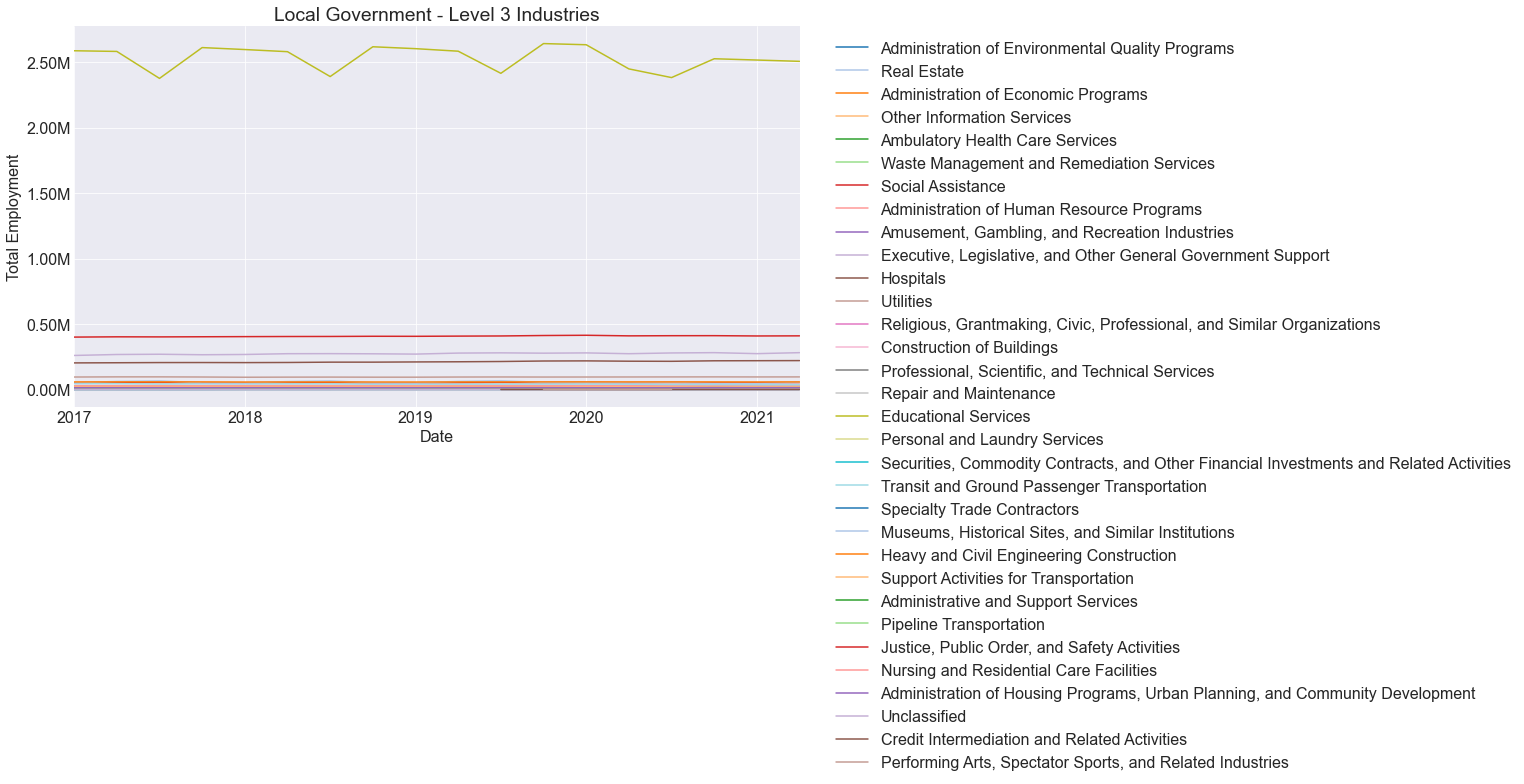

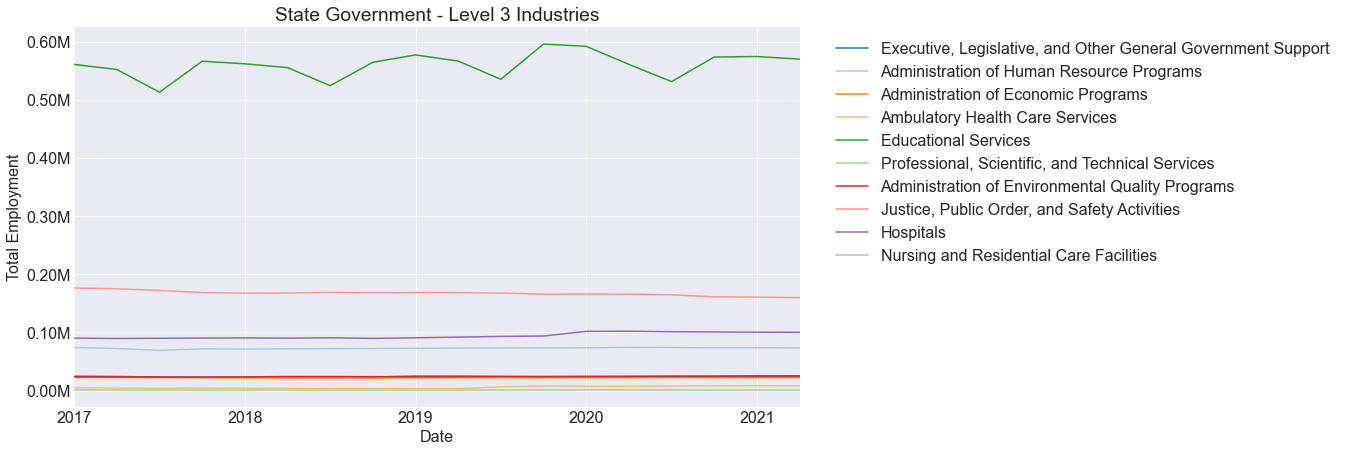

In [32]:
# do this for all ownership categories in loop
ownership_list = df.Ownership.value_counts().index.tolist()

ownership_df_dict = {}
for own in ownership_list:
    ownership_df_dict[own] = df[df.Ownership == own]

for own in ownership_list:
    ind_list = ownership_df_dict[own].Industry.value_counts().index.tolist()
    industry_df_dict = {}
    for ind in ind_list:
        industry_df_dict[ind] = ownership_df_dict[own][ownership_df_dict[own].Industry == ind]
#     for ind in ind_list:
#         industry_df_dict[ind][['Date', 'Total Wages']].set_index('Date')['Total Wages'].plot(label=ind)
#     plt.gca().set(ylabel = 'Total Wages ($)', title=f'{own} - Level 1 Industries')
#     plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.2f}B'.format(x / 1_000_000_000))
#     plt.legend(bbox_to_anchor= (1.03,1))
#     plt.show()
    for ind in ind_list:
        industry_df_dict[ind][['Date', 'Total Employment']].set_index('Date')['Total Employment'].plot(label=ind)
    plt.gca().set(ylabel = 'Total Employment', title=f'{own} - Level 3 Industries')
    plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.2f}M'.format(x / 1_000_000))
    plt.legend(bbox_to_anchor= (1.03,1))
    plt.show()

# works but has way too many industries to fit on one plot

In [33]:
# write a function that uses 3-digit industry code to get 2 digit industry code and then convert that to industry name 
# (use map function after creating dictionary of codes to names)
df['Code'] = df['Industry Code'].astype('string').apply(lambda x: x[:2])

In [34]:
# df.Code.value_counts().sort_index()

In [35]:
# create mapping dictionary to get industries associated with 2-digit codes
code_mapping_dict = {
    '11' : 'Agriculture, Forestry, Fishing and Hunting',
    '21' : 'Mining, Quarrying, and Oil and Gas Extraction',
    '22' : 'Utilities',
    '23' : 'Construction',
    '31' : 'Manufacturing',
    '32' : 'Manufacturing',
    '33' : 'Manufacturing',
    '42' : 'Wholesale Trade',
    '44' : 'Retail Trade',
    '45' : 'Retail Trade',
    '48' : 'Transportation and Warehousing',
    '49' : 'Transportation and Warehousing',
    '51' : 'Information',
    '52' : 'Finance and Insurance',
    '53' : 'Real Estate and Rental and Leasing',
    '54' : 'Professional, Scientific, and Technical Services',
    '55' : 'Management of Companies and Enterprises',
    '56' : 'Administrative and Support and Waste Management and Remediation Services',
    '61' : 'Educational Services',
    '62' : 'Health Care and Social Assistance',
    '71' : 'Arts, Entertainment, and Recreation',
    '72' : 'Accommodation and Food Services',
    '81' : 'Other Services (except Public Administration)',
    '92' : 'Public Administration',
    '99' : 'Unclassified'
}

In [36]:
# create new column with industry names using map function
df['Parent Industry'] = df.Code.map(code_mapping_dict)

In [37]:
# get list of all unique parent industries
par_ind_list = df['Parent Industry'].value_counts().index.tolist()
par_ind_list

['Manufacturing',
 'Retail Trade',
 'Transportation and Warehousing',
 'Public Administration',
 'Health Care and Social Assistance',
 'Information',
 'Other Services (except Public Administration)',
 'Finance and Insurance',
 'Arts, Entertainment, and Recreation',
 'Agriculture, Forestry, Fishing and Hunting',
 'Construction',
 'Administrative and Support and Waste Management and Remediation Services',
 'Real Estate and Rental and Leasing',
 'Accommodation and Food Services',
 'Mining, Quarrying, and Oil and Gas Extraction',
 'Wholesale Trade',
 'Professional, Scientific, and Technical Services',
 'Educational Services',
 'Unclassified',
 'Utilities',
 'Management of Companies and Enterprises']

In [38]:
# create a dictionary with subset dfs for each parent industry
par_ind_df_dict = {}
for ind in par_ind_list:
    par_ind_df_dict[ind] = df[df['Parent Industry'] == ind]

In [39]:
# for par in par_ind_list:
#     df = par_ind_df_dict[par]
    
#     ownership_list = df.Ownership.value_counts().index.tolist()
    
#     ownership_df_dict = {}
#     for own in ownership_list:
#         ownership_df_dict[own] = df[df.Ownership == own]
    
#     for own in ownership_list:
#         ind_list = ownership_df_dict[own].Industry.value_counts().index.tolist()
#         industry_df_dict = {}
#         for ind in ind_list:
#             industry_df_dict[ind] = ownership_df_dict[own][ownership_df_dict[own].Industry == ind]
# #         for ind in ind_list:
# #             industry_df_dict[ind][['Date', 'Total Wages']].set_index('Date')['Total Wages'].plot(label=ind)
# #         plt.gca().set(ylabel = 'Total Wages ($)', title=f'{own} - {par} - Level 3 Industries')
# #         plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.2f}B'.format(x / 1_000_000_000))
# #         plt.legend(bbox_to_anchor= (1.03,1))
# #         plt.show()
#         for ind in ind_list:
#             industry_df_dict[ind][['Date', 'Total Employment']].set_index('Date')['Total Employment'].plot(label=ind)
#         plt.gca().set(ylabel = 'Total Employment', title=f'{own} - {par} - Level 3 Industries')
#         plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.2f}M'.format(x / 1_000_000))
#         plt.legend(bbox_to_anchor= (1.03,1))
#         plt.show()

---
#### Just Total All, all industries, melt to monthly

In [40]:
# get data for highest (most general) level of industry classification
df = pd.read_excel('QCEW-TX-L3.xlsx')

# add a column for total employment for that row
# df['Total Employment'] = df['Month 1 Employment'] + df['Month 2 Employment'] + df['Month 3 Employment']

# figure out a way to convert the year and period columns into a single datetime format for plotting
# Convert the period number into the number of the first month for each quarter
# Q1 - 1, Q2 - 4, Q3 - 7, Q4 - 10
# df['First Month'] = df.Period.apply(lambda x: '1' if x == 1 else '4' if x == 2 else '7' if x == 3 else '10')

# add first month to year as strings 
# df['Quarter'] = df.Year.astype('string') + '-' + df['First Month']

# make a new column that is datetime for first day of each quarter for x axis when plotting
# df['Date'] = pd.to_datetime(df.Quarter)

# only total
df = df[df.Ownership == 'Total All']
# I only want to keep a few columns
df = df[['Year', 'Period', 'Industry Code', 'Industry', 'Month 1 Employment', 'Month 2 Employment', 'Month 3 Employment']]

In [41]:
# # we are looking at a total of 97 industries on a single plot
# ind_list = df.Industry.value_counts().index.tolist()
# #ind_list

# industry_df_dict = {}
# for ind in ind_list:
#     industry_df_dict[ind] = df[df.Industry == ind]

# for ind in ind_list:
#     industry_df_dict[ind][['Date', 'Total Employment']].set_index('Date')['Total Employment'].plot(label=ind)
#     plt.gca().set(ylabel = 'Total Employment', title=f'{own} - Level 3 Industries')
#     plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.2f}M'.format(x / 1_000_000))
#     plt.legend(bbox_to_anchor= (1.03,1))
# plt.show()

In [42]:
df.head()

Year  Period  Industry Code         Industry  Month 1 Employment  \
1  2017       1            111  Crop Production               19992   
3  2017       2            111  Crop Production               21337   
5  2017       3            111  Crop Production               20982   
7  2017       4            111  Crop Production               21747   
9  2018       1            111  Crop Production               19531   

   Month 2 Employment  Month 3 Employment  
1               20513               21298  
3               21000               21024  
5               20754               20583  
7               22210               21254  
9               20177               20942

In [43]:
# take a look at current number rows
df.shape

(1735, 7)

In [44]:
# we want to create 3 rows for each current row, so our new df should have this many rows
1735 * 3

5205

In [45]:
df.Industry.nunique()

97

In [46]:
# I want to take values for columns 'Month 1 Employment', 'Month 2 Employment', 'Month 3 Employment' and pivot them into rows while changing dates to year-month-01 for each month
df = df.melt(id_vars=['Year', 'Period', 'Industry Code', 'Industry'], var_name='Month', value_name='Total Employment')

In [47]:
df.shape

(5205, 6)

In [48]:
# now let's create plots for each industry
df.head()

Year  Period  Industry Code         Industry               Month  \
0  2017       1            111  Crop Production  Month 1 Employment   
1  2017       2            111  Crop Production  Month 1 Employment   
2  2017       3            111  Crop Production  Month 1 Employment   
3  2017       4            111  Crop Production  Month 1 Employment   
4  2018       1            111  Crop Production  Month 1 Employment   

   Total Employment  
0             19992  
1             21337  
2             20982  
3             21747  
4             19531

In [49]:
# use string method to pull out numbers from Month column
df['Month'] = df.Month.apply(lambda x: [int(s) for s in x.split() if s.isdigit()][0])

In [50]:
df.head()

Year  Period  Industry Code         Industry  Month  Total Employment
0  2017       1            111  Crop Production      1             19992
1  2017       2            111  Crop Production      1             21337
2  2017       3            111  Crop Production      1             20982
3  2017       4            111  Crop Production      1             21747
4  2018       1            111  Crop Production      1             19531

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5205 entries, 0 to 5204
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Year              5205 non-null   int64 
 1   Period            5205 non-null   int64 
 2   Industry Code     5205 non-null   int64 
 3   Industry          5205 non-null   object
 4   Month             5205 non-null   int64 
 5   Total Employment  5205 non-null   int64 
dtypes: int64(5), object(1)
memory usage: 244.1+ KB


https://stackoverflow.com/questions/13331698/how-to-apply-a-function-to-two-columns-of-pandas-dataframe

In [52]:
# create a function that takes each row and creates a date column for the observation
def extract_date(df):
    if (df[1] == 1) & (df[4] == 1): # first quarter, first month
        return str(df[0]) + '-' + '01' # January
    elif (df[1] == 1) & (df[4] == 2):
        return str(df[0]) + '-' + '02'
    elif (df[1] == 1) & (df[4] == 3):
        return str(df[0]) + '-' + '03'
    elif (df[1] == 2) & (df[4] == 1):
        return str(df[0]) + '-' + '04'
    elif (df[1] == 2) & (df[4] == 2):
        return str(df[0]) + '-' + '05'
    elif (df[1] == 2) & (df[4] == 3):
        return str(df[0]) + '-' + '06'
    elif (df[1] == 3) & (df[4] == 1):
        return str(df[0]) + '-' + '07'
    elif (df[1] == 3) & (df[4] == 2):
        return str(df[0]) + '-' + '08'
    elif (df[1] == 3) & (df[4] == 3):
        return str(df[0]) + '-' + '09'
    elif (df[1] == 4) & (df[4] == 1):
        return str(df[0]) + '-' + '10'
    elif (df[1] == 4) & (df[4] == 2):
        return str(df[0]) + '-' + '11'
    elif (df[1] == 4) & (df[4] == 3):
        return str(df[0]) + '-' + '12'

In [53]:
df['Date'] = df.apply(extract_date, axis=1)

In [54]:
df.Date = pd.to_datetime(df.Date)

In [55]:
df.head()

Year  Period  Industry Code         Industry  Month  Total Employment  \
0  2017       1            111  Crop Production      1             19992   
1  2017       2            111  Crop Production      1             21337   
2  2017       3            111  Crop Production      1             20982   
3  2017       4            111  Crop Production      1             21747   
4  2018       1            111  Crop Production      1             19531   

        Date  
0 2017-01-01  
1 2017-04-01  
2 2017-07-01  
3 2017-10-01  
4 2018-01-01

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5205 entries, 0 to 5204
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Year              5205 non-null   int64         
 1   Period            5205 non-null   int64         
 2   Industry Code     5205 non-null   int64         
 3   Industry          5205 non-null   object        
 4   Month             5205 non-null   int64         
 5   Total Employment  5205 non-null   int64         
 6   Date              5205 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(5), object(1)
memory usage: 284.8+ KB


<AxesSubplot:xlabel='Date'>

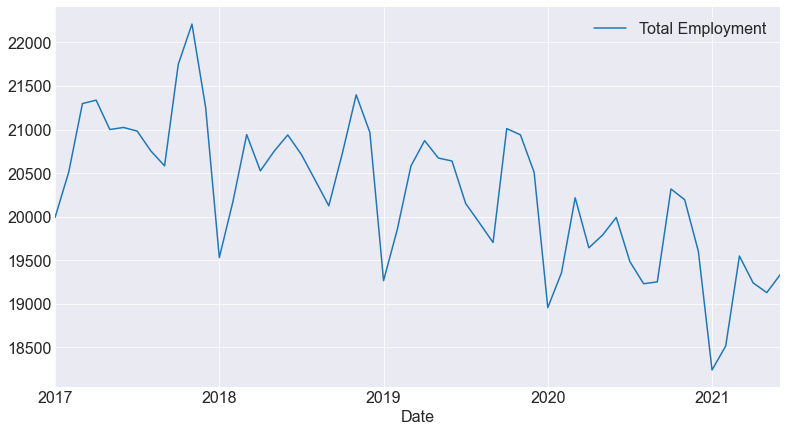

In [57]:
# now plot these for one industry
df[df.Industry == 'Crop Production'].sort_values(by='Date')[['Date', 'Total Employment']].set_index('Date').sort_index().plot()

In [58]:
# now plot for each subsector

In [59]:
df.head()

Year  Period  Industry Code         Industry  Month  Total Employment  \
0  2017       1            111  Crop Production      1             19992   
1  2017       2            111  Crop Production      1             21337   
2  2017       3            111  Crop Production      1             20982   
3  2017       4            111  Crop Production      1             21747   
4  2018       1            111  Crop Production      1             19531   

        Date  
0 2017-01-01  
1 2017-04-01  
2 2017-07-01  
3 2017-10-01  
4 2018-01-01

In [60]:
# write a function that uses 3-digit industry code to get 2 digit industry code and then convert that to industry name 
# (use map function after creating dictionary of codes to names)
df['Code'] = df['Industry Code'].astype('string').apply(lambda x: x[:2])

In [61]:
df.head()

Year  Period  Industry Code         Industry  Month  Total Employment  \
0  2017       1            111  Crop Production      1             19992   
1  2017       2            111  Crop Production      1             21337   
2  2017       3            111  Crop Production      1             20982   
3  2017       4            111  Crop Production      1             21747   
4  2018       1            111  Crop Production      1             19531   

        Date Code  
0 2017-01-01   11  
1 2017-04-01   11  
2 2017-07-01   11  
3 2017-10-01   11  
4 2018-01-01   11

In [62]:
# create mapping dictionary to get industries associated with 2-digit codes
code_mapping_dict = {
    '11' : 'Agriculture, Forestry, Fishing and Hunting',
    '21' : 'Mining, Quarrying, and Oil and Gas Extraction',
    '22' : 'Utilities',
    '23' : 'Construction',
    '31' : 'Manufacturing',
    '32' : 'Manufacturing',
    '33' : 'Manufacturing',
    '42' : 'Wholesale Trade',
    '44' : 'Retail Trade',
    '45' : 'Retail Trade',
    '48' : 'Transportation and Warehousing',
    '49' : 'Transportation and Warehousing',
    '51' : 'Information',
    '52' : 'Finance and Insurance',
    '53' : 'Real Estate and Rental and Leasing',
    '54' : 'Professional, Scientific, and Technical Services',
    '55' : 'Management of Companies and Enterprises',
    '56' : 'Administrative and Support and Waste Management and Remediation Services',
    '61' : 'Educational Services',
    '62' : 'Health Care and Social Assistance',
    '71' : 'Arts, Entertainment, and Recreation',
    '72' : 'Accommodation and Food Services',
    '81' : 'Other Services (except Public Administration)',
    '92' : 'Public Administration',
    '99' : 'Unclassified'
}

In [63]:
# create new column with industry names using map function
df['Parent Industry'] = df.Code.map(code_mapping_dict)

In [64]:
df.head()

Year  Period  Industry Code         Industry  Month  Total Employment  \
0  2017       1            111  Crop Production      1             19992   
1  2017       2            111  Crop Production      1             21337   
2  2017       3            111  Crop Production      1             20982   
3  2017       4            111  Crop Production      1             21747   
4  2018       1            111  Crop Production      1             19531   

        Date Code                             Parent Industry  
0 2017-01-01   11  Agriculture, Forestry, Fishing and Hunting  
1 2017-04-01   11  Agriculture, Forestry, Fishing and Hunting  
2 2017-07-01   11  Agriculture, Forestry, Fishing and Hunting  
3 2017-10-01   11  Agriculture, Forestry, Fishing and Hunting  
4 2018-01-01   11  Agriculture, Forestry, Fishing and Hunting

In [65]:
# get list of all unique parent industries
par_ind_list = df['Parent Industry'].value_counts().index.tolist()

In [66]:
# # create a dictionary with subset dfs for each parent industry
# par_ind_df_dict = {}
# for ind in par_ind_list:
#     par_ind_df_dict[ind] = df[df['Parent Industry'] == ind]

# for par in par_ind_list:
#     df = par_ind_df_dict[par]
#     ind_list = df.Industry.value_counts().index.tolist()
#     industry_df_dict = {}
#     for ind in ind_list:
#         industry_df_dict[ind] = df[df.Industry == ind]
#     for ind in ind_list:
#         industry_df_dict[ind][['Date', 'Total Employment']].set_index('Date')['Total Employment'].plot(label=ind)
#     plt.gca().set(ylabel = 'Total Employment', title=f'{par} - Level 3 Industries')
#     plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000))
#     plt.legend(bbox_to_anchor= (1.03,1))
#     plt.show()

In [67]:
# # create a dictionary with subset dfs for each parent industry
# par_ind_df_dict = {}
# for ind in par_ind_list:
#     par_ind_df_dict[ind] = df[df['Parent Industry'] == ind]

# for par in par_ind_list:
#     par_df = par_ind_df_dict[par]
#     ind_list = par_df.Industry.value_counts().index.tolist()
#     industry_df_dict = {}
#     for ind in ind_list:
#         industry_df_dict[ind] = par_df[par_df.Industry == ind]
#     for ind in ind_list:
#         industry_df_dict[ind][['Date', 'Total Employment']].set_index('Date')['Total Employment'].sort_index().plot(label=ind)
#     plt.gca().set(ylabel = 'Total Employment', title=f'{par} - Level 3 Industries')
#     plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000))
#     plt.legend(bbox_to_anchor= (1.03,1))
#     plt.show()

In [68]:
# # create a dictionary with subset dfs for each parent industry
# par_ind_df_dict = {}
# for ind in par_ind_list:
#     par_ind_df_dict[ind] = df[df['Parent Industry'] == ind]

# for par in par_ind_list:
#     par_df = par_ind_df_dict[par]
#     ind_list = par_df.Industry.value_counts().index.tolist()
#     industry_df_dict = {}
#     for ind in ind_list:
#         industry_df_dict[ind] = par_df[par_df.Industry == ind]
#     for ind in ind_list:
#         industry_df_dict[ind][['Date', 'Total Employment']].set_index('Date')['Total Employment']['2020'].sort_index().plot(label=ind)
#     plt.gca().set(ylabel = 'Total Employment', title=f'{par} - Level 3 Industries')
#     plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000))
#     plt.legend(bbox_to_anchor= (1.03,1))
#     plt.show()

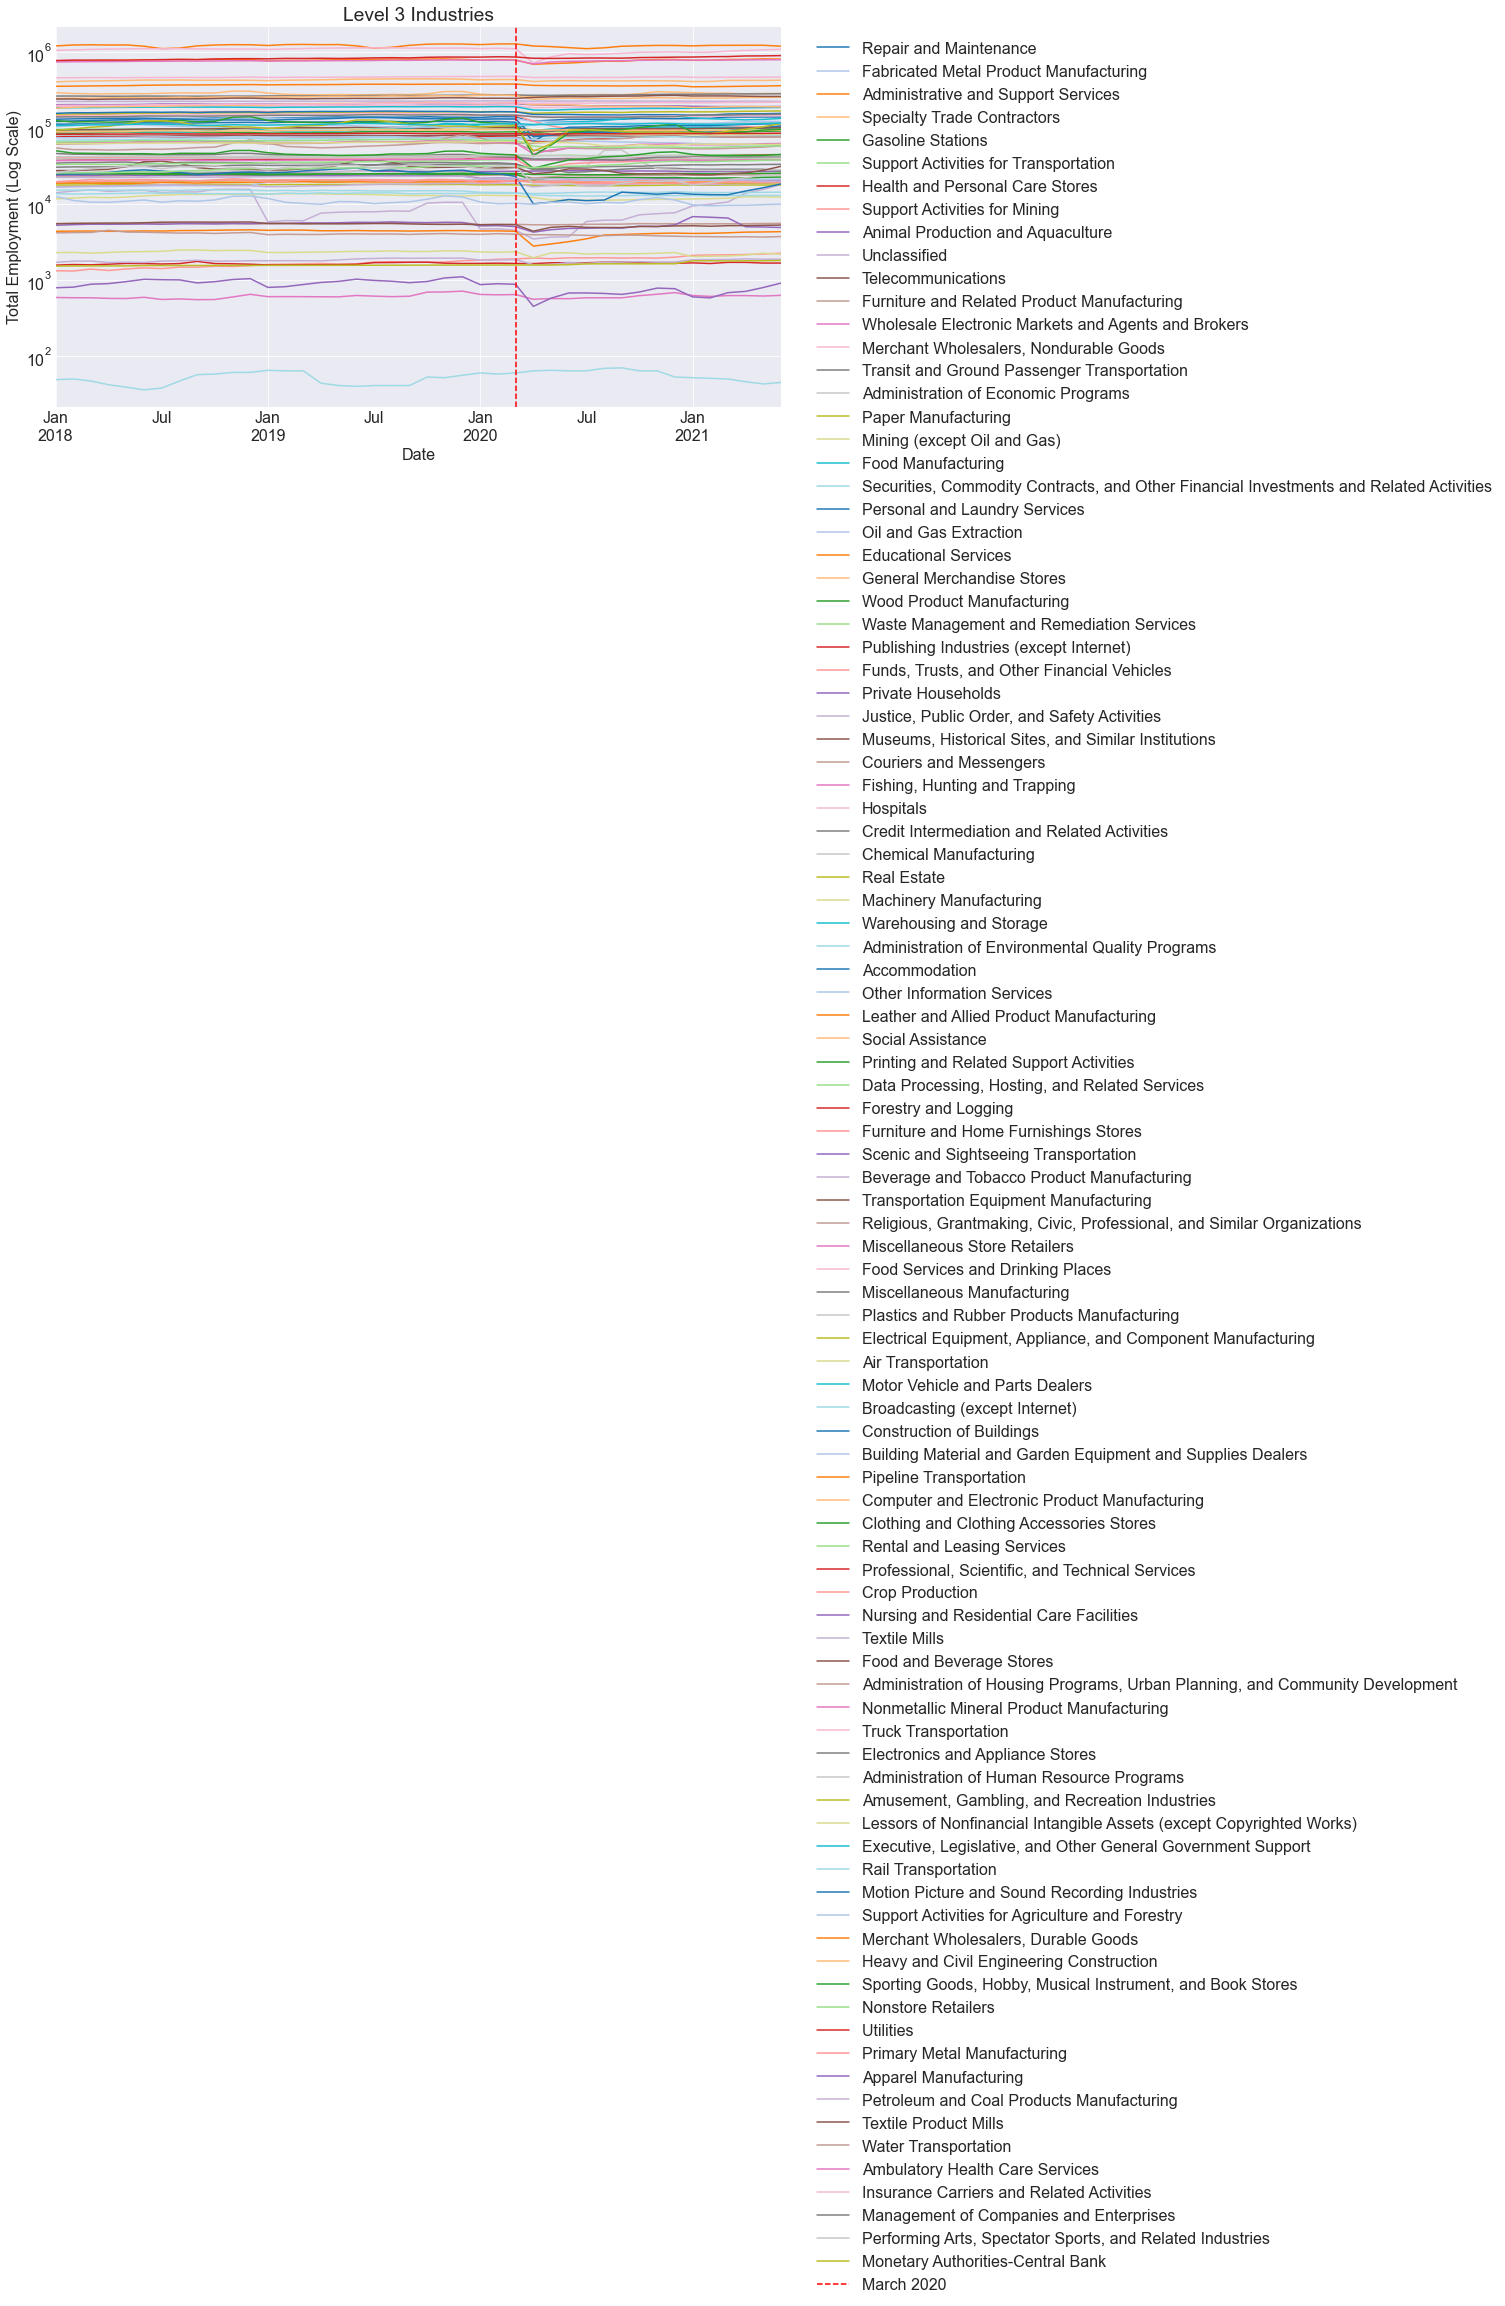

In [70]:
# plot for all industries
ind_list = df.Industry.value_counts().index.tolist()
industry_df_dict = {}
for ind in ind_list:
    industry_df_dict[ind] = df[df.Industry == ind]
for ind in ind_list:
    industry_df_dict[ind][['Date', 'Total Employment']].set_index('Date')['Total Employment'].sort_index()['2018': ].plot(label=ind)
plt.gca().set(ylabel = 'Total Employment (Log Scale)', title='Level 3 Industries')
plt.gca().axvline(x='2020-03', color = 'red', linestyle = '--', label='March 2020')
# plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.1f}M'.format(x / 1_000_000))
plt.yscale('log')
plt.legend(bbox_to_anchor= (1.03,1))
plt.show()

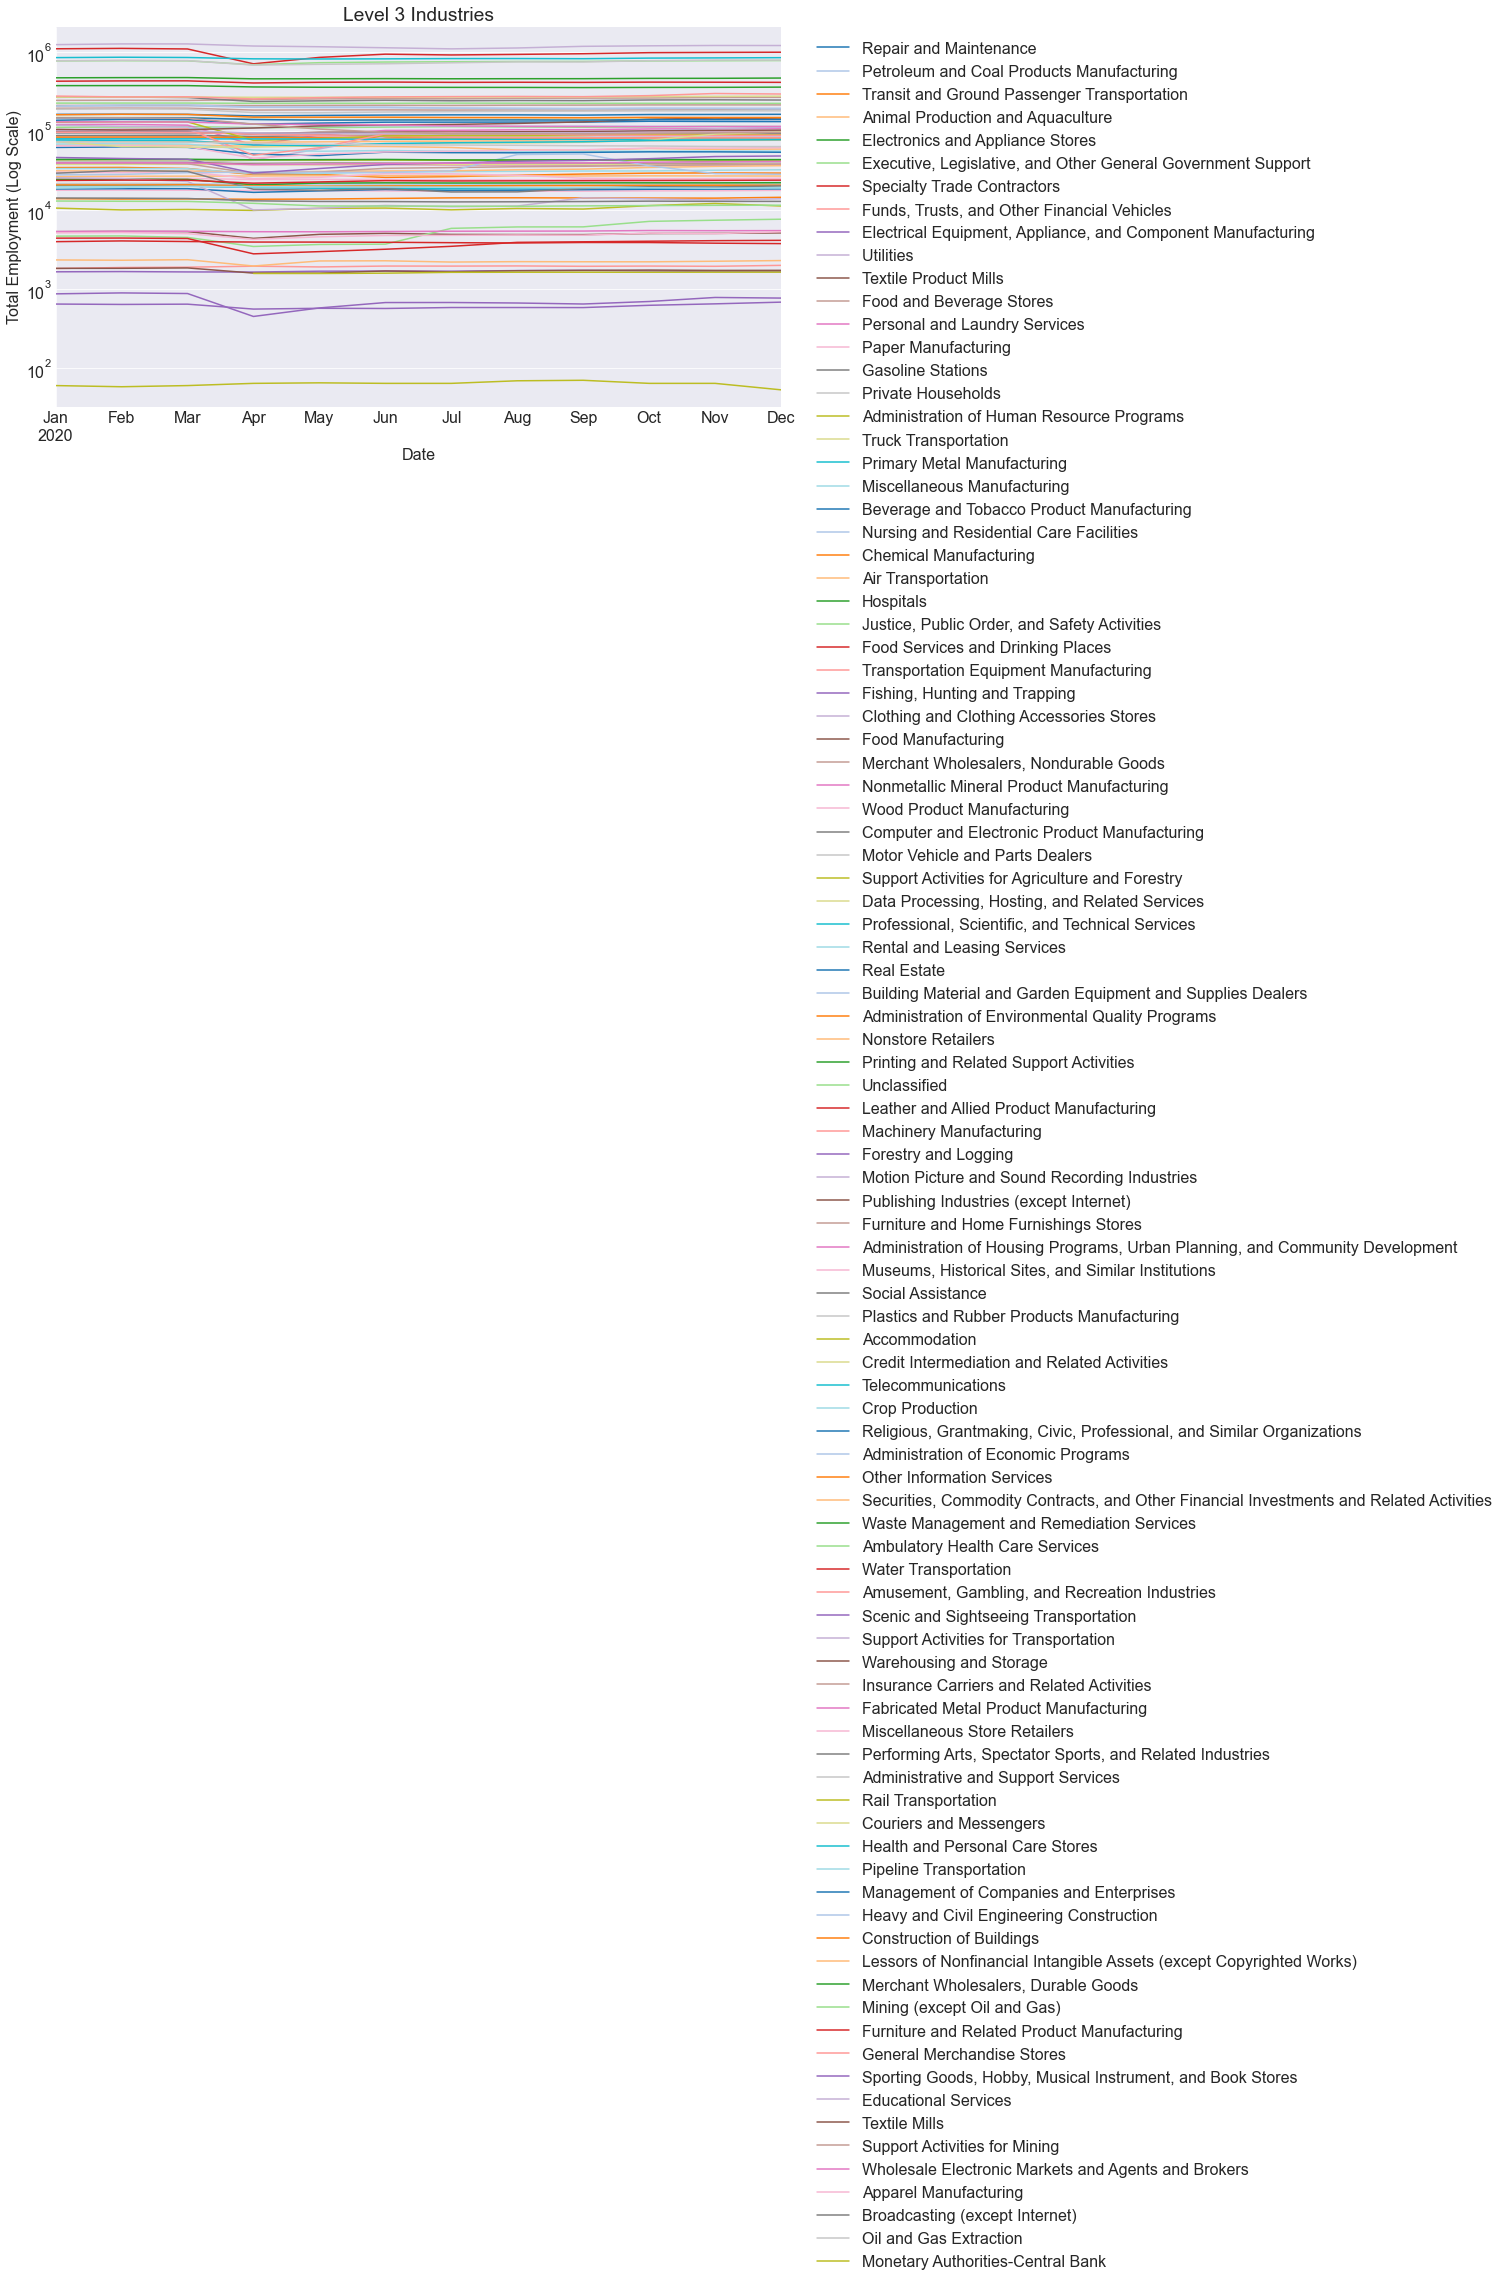

In [65]:
# plot for all industries 2020
ind_list = df.Industry.value_counts().index.tolist()
industry_df_dict = {}
for ind in ind_list:
    industry_df_dict[ind] = df[df.Industry == ind]
for ind in ind_list:
    industry_df_dict[ind][['Date', 'Total Employment']].set_index('Date')['Total Employment']['2020'].sort_index().plot(label=ind)
plt.gca().set(ylabel = 'Total Employment (Log Scale)', title='Level 3 Industries')
# plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.1f}M'.format(x / 1_000_000))
plt.yscale('log')
plt.legend(bbox_to_anchor= (1.03,1))
plt.show()

## Get Monthly Data

In [4]:
# make sure function is ready-to-go
def extract_date(df):
    if (df[1] == 1) & (df[4] == 1): # first quarter, first month
        return str(df[0]) + '-' + '01' # January
    elif (df[1] == 1) & (df[4] == 2):
        return str(df[0]) + '-' + '02'
    elif (df[1] == 1) & (df[4] == 3):
        return str(df[0]) + '-' + '03'
    elif (df[1] == 2) & (df[4] == 1):
        return str(df[0]) + '-' + '04'
    elif (df[1] == 2) & (df[4] == 2):
        return str(df[0]) + '-' + '05'
    elif (df[1] == 2) & (df[4] == 3):
        return str(df[0]) + '-' + '06'
    elif (df[1] == 3) & (df[4] == 1):
        return str(df[0]) + '-' + '07'
    elif (df[1] == 3) & (df[4] == 2):
        return str(df[0]) + '-' + '08'
    elif (df[1] == 3) & (df[4] == 3):
        return str(df[0]) + '-' + '09'
    elif (df[1] == 4) & (df[4] == 1):
        return str(df[0]) + '-' + '10'
    elif (df[1] == 4) & (df[4] == 2):
        return str(df[0]) + '-' + '11'
    elif (df[1] == 4) & (df[4] == 3):
        return str(df[0]) + '-' + '12'

In [5]:
df = pd.read_excel('QCEW-TX-L3.xlsx') # get raw data
df = df[df.Ownership == 'Total All'] # filter just to all ownership groups
df = df[['Year', 'Period', 'Industry Code', 'Industry', 'Month 1 Employment', 'Month 2 Employment', 'Month 3 Employment']] # only keep necessary columns
df = df.melt(id_vars=['Year', 'Period', 'Industry Code', 'Industry'], var_name='Month', value_name='Total Employment') # melt columns to rows to get monthly instead of quarterly
df['Month'] = df.Month.apply(lambda x: [int(s) for s in x.split() if s.isdigit()][0]) # pull month integer out of string
df['Date'] = df.apply(extract_date, axis=1) # use function to pull out date from multiple columns
df.Date = pd.to_datetime(df.Date) # convert data to datetime dtype

## Characterization DF


In [6]:
# create a dictionary with all dfs for each industry for year 2020
ind_list = df.Industry.value_counts().index.tolist()
ind_list[-1]

'Monetary Authorities-Central Bank'

In [7]:
ind_list.remove('Monetary Authorities-Central Bank')

In [8]:
# ind_list.pop(-1)

In [9]:
len(ind_list)

96

In [10]:
industry_df_dict = {}
for ind in ind_list:
    industry_df_dict[ind] = df[df.Industry == ind][['Date', 'Total Employment']].set_index('Date')['Total Employment'].sort_index()['2020']

Need to figure out how to create a new df with rows for each industry (97) and columns for each statistical characteristic

In [11]:
# write a function that takes in a series and returns a dictionary with all the characteristic values with associated keys (column names)
def characterize_series(series):
    pcnt_decrease = ((s['2020-03'][0] - s['2020-04'][0]) / s['2020-03'][0]) * 100
    recovery_slope = (s['2020-06'][0] - s['2020-04'][0]) / 2 # need to normalize this?
    mean = s.mean()
    std = s.std()
    rec_slope_norm = recovery_slope / mean
    cov = mean / std
    characteristic_dict = {
        'pcnt_decrease' : pcnt_decrease,
        'recovery_slope' : recovery_slope,
        'mean' : mean,
        'standard_dev' : std,
        'recovery_slope_normalized' : rec_slope_norm,
        'cov' : cov
    }
    return characteristic_dict

In [12]:
# create an empty characteristics list (list of dictionaries to convert to df)
characteristics = []

In [13]:
# Use dictionary comprehension that runs through each entry in industry_df_dict and appends dictionary to char list (or for loop)
for ind in ind_list:
    s = industry_df_dict[ind]
    characteristics.append(characterize_series(s))
    #print(len(s))

In [14]:
# convert characteristics list into df
char_df = pd.DataFrame(characteristics, index=ind_list)
char_df.sort_values(by='pcnt_decrease', ascending=True).head(10)

pcnt_decrease  \
Rail Transportation                                     -6.666667   
Warehousing and Storage                                 -5.055032   
Funds, Trusts, and Other Financial Vehicles             -2.905441   
Food and Beverage Stores                                -2.721895   
Administration of Economic Programs                     -2.361331   
Building Material and Garden Equipment and Supp...      -1.102687   
Animal Production and Aquaculture                       -0.554357   
Couriers and Messengers                                 -0.143687   
Administration of Human Resource Programs               -0.027782   
Pipeline Transportation                                  0.246120   

                                                    recovery_slope  \
Rail Transportation                                            0.0   
Warehousing and Storage                                     5156.0   
Funds, Trusts, and Other Financial Vehicles                    4.0   
Food and Beverage Stores                                    3429.0   
Administration of Economic Programs                         -256.0   
Building Material and Garden Equipment and Supp...          3629.0   
Animal Production and Aquaculture                            160.0   
Couriers and Messengers                                     2786.5   
Administration of Human Resource Programs                   -108.5   
Pipeline Transportation                                     -132.5   

                                                             mean  \
Rail Transportation                                     62.916667   
Warehousing and Storage                             122100.500000   
Funds, Trusts, and Other Financial Vehicles           1929.250000   
Food and Beverage Stores                            256206.666667   
Administration of Economic Programs                  33613.500000   
Building Material and Garden Equipment and Supp...  112270.750000   
Animal Production and Aquaculture                    27063.083333   
Couriers and Messengers                              72973.833333   
Administration of Human Resource Programs            43004.000000   
Pipeline Transportation                              19451.833333   

                                                    standard_dev  \
Rail Transportation                                     4.640892   
Warehousing and Storage                             15390.172753   
Funds, Trusts, and Other Financial Vehicles            47.371117   
Food and Beverage Stores                             8150.461887   
Administration of Economic Programs                  8387.225801   
Building Material and Garden Equipment and Supp...   4369.090047   
Animal Production and Aquaculture                     223.033001   
Couriers and Messengers                             11167.919069   
Administration of Human Resource Programs             153.499778   
Pipeline Transportation                               344.579806   

                                                    recovery_slope_normalized  \
Rail Transportation                                                  0.000000   
Warehousing and Storage                                              0.042228   
Funds, Trusts, and Other Financial Vehicles                          0.002073   
Food and Beverage Stores                                             0.013384   
Administration of Economic Programs                                 -0.007616   
Building Material and Garden Equipment and Supp...                   0.032324   
Animal Production and Aquaculture                                    0.005912   
Couriers and Messengers                                              0.038185   
Administration of Human Resource Programs                           -0.002523   
Pipeline Transportation                                             -0.006812   

                                                           cov  
Rail Transportation                                  13

In [15]:
char_df.shape

(96, 6)

---
## Clustering
---

### First iteration

In [16]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [17]:
# need to scale data first
def scale(df, scaler):
    '''
    Takes in df and scaler of your choosing and returns df with encoded columns
    '''
    cols = df.columns.tolist()
    new_column_names = [c + '_scaled' for c in cols]
    
    # Fit the scaler on the train
    scaler.fit(df)
    
    # transform train validate and test
    df = pd.concat([
        df,
        pd.DataFrame(scaler.transform(df), columns=new_column_names, index=df.index),
    ], axis=1)
    
    # drop scaled columns
    df = df.drop(columns=cols)
    
    return df

In [85]:
scaled_char_df = scale(char_df, MinMaxScaler())

In [86]:
scaled_char_df

pcnt_decrease_scaled  \
Beverage and Tobacco Product Manufacturing                      0.246932   
Oil and Gas Extraction                                          0.140399   
Electronics and Appliance Stores                                0.182266   
Printing and Related Support Activities                         0.314805   
Furniture and Related Product Manufacturing                     0.218742   
...                                                                  ...   
Construction of Buildings                                       0.209606   
Food Services and Drinking Places                               0.610465   
Securities, Commodity Contracts, and Other Fina...              0.124496   
Electrical Equipment, Appliance, and Component ...              0.148449   
Building Material and Garden Equipment and Supp...              0.081219   

                                                    recovery_slope_scaled  \
Beverage and Tobacco Product Manufacturing                       0.207216   
Oil and Gas Extraction                                           0.191803   
Electronics and Appliance Stores                                 0.204091   
Printing and Related Support Activities                          0.206582   
Furniture and Related Product Manufacturing                      0.207982   
...                                                                   ...   
Construction of Buildings                                        0.201676   
Food Services and Drinking Places                                1.000000   
Securities, Commodity Contracts, and Other Fina...               0.208379   
Electrical Equipment, Appliance, and Component ...               0.200882   
Building Material and Garden Equipment and Supp...               0.227246   

                                                    mean_scaled  \
Beverage and Tobacco Product Manufacturing             0.015127   
Oil and Gas Extraction                                 0.056779   
Electronics and Appliance Stores                       0.033358   
Printing and Related Support Activities                0.018897   
Furniture and Related Product Manufacturing            0.019612   
...                                                         ...   
Construction of Buildings                              0.127606   
Food Services and Drinking Places                      0.810405   
Securities, Commodity Contracts, and Other Fina...     0.062333   
Electrical Equipment, Appliance, and Component ...     0.016108   
Building Material and Garden Equipment and Supp...     0.094038   

                                                    standard_dev_scaled  \
Beverage and Tobacco Product Manufacturing                     0.005046   
Oil and Gas Extraction                                         0.030658   
Electronics and Appliance Stores                               0.014797   
Printing and Related Support Activities                        0.010792   
Furniture and Related Product Manufacturing                    0.005175   
...                                                                 ...   
Construction of Buildings                                      0.054104   
Food Services and Drinking Places                              1.000000   
Securities, Commodity Contracts, and Other Fina...             0.011238   
Electrical Equipment, Appliance, and Component ...             0.005192   
Building Material and Garden Equipment and Supp...             0.038673   

                                                    recovery_slope_normalized_scaled  \
Beverage and Tobacco Product Manufacturing                                  0.436979   
Oil and Gas Extraction                                                      0.264111   
Electronics and Appliance Stores                                            0.344791   
Printing and Related Support Activities                                     0.403573   
Furniture and Related Product Manufacturing                         

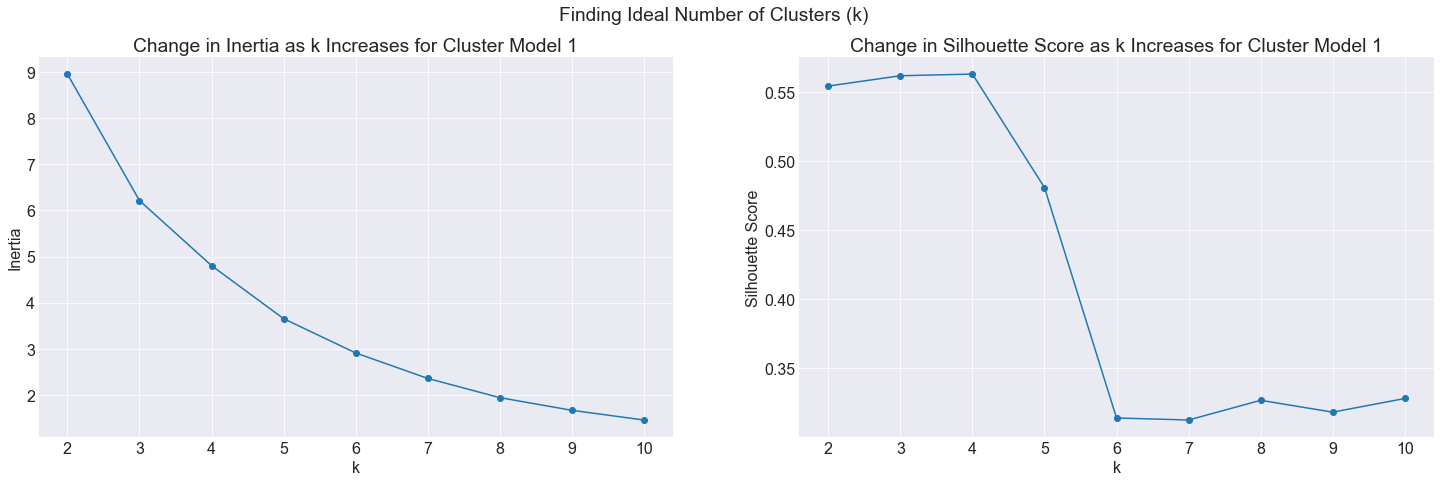

In [87]:
plt.figure(figsize=(25, 7)).suptitle('Finding Ideal Number of Clusters (k)')

kmax = 10

plt.subplot(121)

# let's plot inertia vs k for this model to chose number of clusters (k)

pd.Series({k: KMeans(k).fit(scaled_char_df).inertia_ for k in range(2, kmax+1)}).plot(marker='o')
plt.xticks(range(2, kmax+1))
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Change in Inertia as k Increases for Cluster Model 1')


plt.subplot(122)

pd.Series({k: silhouette_score(scaled_char_df, KMeans(k).fit(scaled_char_df).labels_) for k in range(2, kmax+1)}).plot(marker='o')
plt.xticks(range(2, kmax+1))
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Change in Silhouette Score as k Increases for Cluster Model 1');


Lets try 5 clusters to start, 3 as second option, 3 was better

In [88]:
# create model object
kmeans1 = KMeans(n_clusters=3, random_state=527)

# fit the object to scaled, training data
kmeans1.fit(scaled_char_df)

# Use (predict using) the thing 
char_df['cluster_1'] = kmeans1.predict(scaled_char_df)
# scaled_char_df['cluster_1'] = kmeans1.predict(scaled_char_df)

In [89]:
char_df.head()

pcnt_decrease  recovery_slope  \
Beverage and Tobacco Product Manufacturing       10.249545           726.0   
Oil and Gas Extraction                            2.951463         -1508.0   
Electronics and Appliance Stores                  5.819593           273.0   
Printing and Related Support Activities          14.899258           634.0   
Furniture and Related Product Manufacturing       8.318347           837.0   

                                                     mean  standard_dev  \
Beverage and Tobacco Product Manufacturing   18112.666667    574.093330   
Oil and Gas Extraction                       67812.833333   3464.558212   
Electronics and Appliance Stores             39866.416667   1674.564826   
Printing and Related Support Activities      22611.000000   1222.612925   
Furniture and Related Product Manufacturing  23464.333333    588.688270   

                                             recovery_slope_normalized  \
Beverage and Tobacco Product Manufacturing                    0.040082   
Oil and Gas Extraction                                       -0.022238   
Electronics and Appliance Stores                              0.006848   
Printing and Related Support Activities                       0.028039   
Furniture and Related Product Manufacturing                   0.035671   

                                                   cov  cluster_1  
Beverage and Tobacco Product Manufacturing   31.550039          0  
Oil and Gas Extraction                       19.573299          0  
Electronics and Appliance Stores             23.807031          0  
Printing and Related Support Activities      18.493997          0  
Furniture and Related Product Manufacturing  39.858673          0

In [90]:
char_df.cluster_1.value_counts()

0    80
1    11
2     5
Name: cluster_1, dtype: int64

In [91]:
char_df.cluster_1.value_counts(normalize=True)

0    0.833333
1    0.114583
2    0.052083
Name: cluster_1, dtype: float64

In [92]:
# add cluster labels to orignal time series data
# create a dictionary with industry name and cluster label
cluster_labels_dict = char_df[['cluster_1']].to_dict()['cluster_1']

In [93]:
df = df[df.Industry != 'Monetary Authorities-Central Bank']

In [94]:
# map into a new column on time series df
df['Cluster'] = df.Industry.map(cluster_labels_dict)

In [95]:
df.Cluster = df.Cluster.astype('int')

In [96]:
# create a list of cluster labels
cluster_list = df.Cluster.value_counts().index.tolist()

In [97]:
# create dictonary of dfs for each cluster subset
cluster_df_dict = {}
for clust in cluster_list:
    cluster_df_dict[clust] = df[df.Cluster == clust]

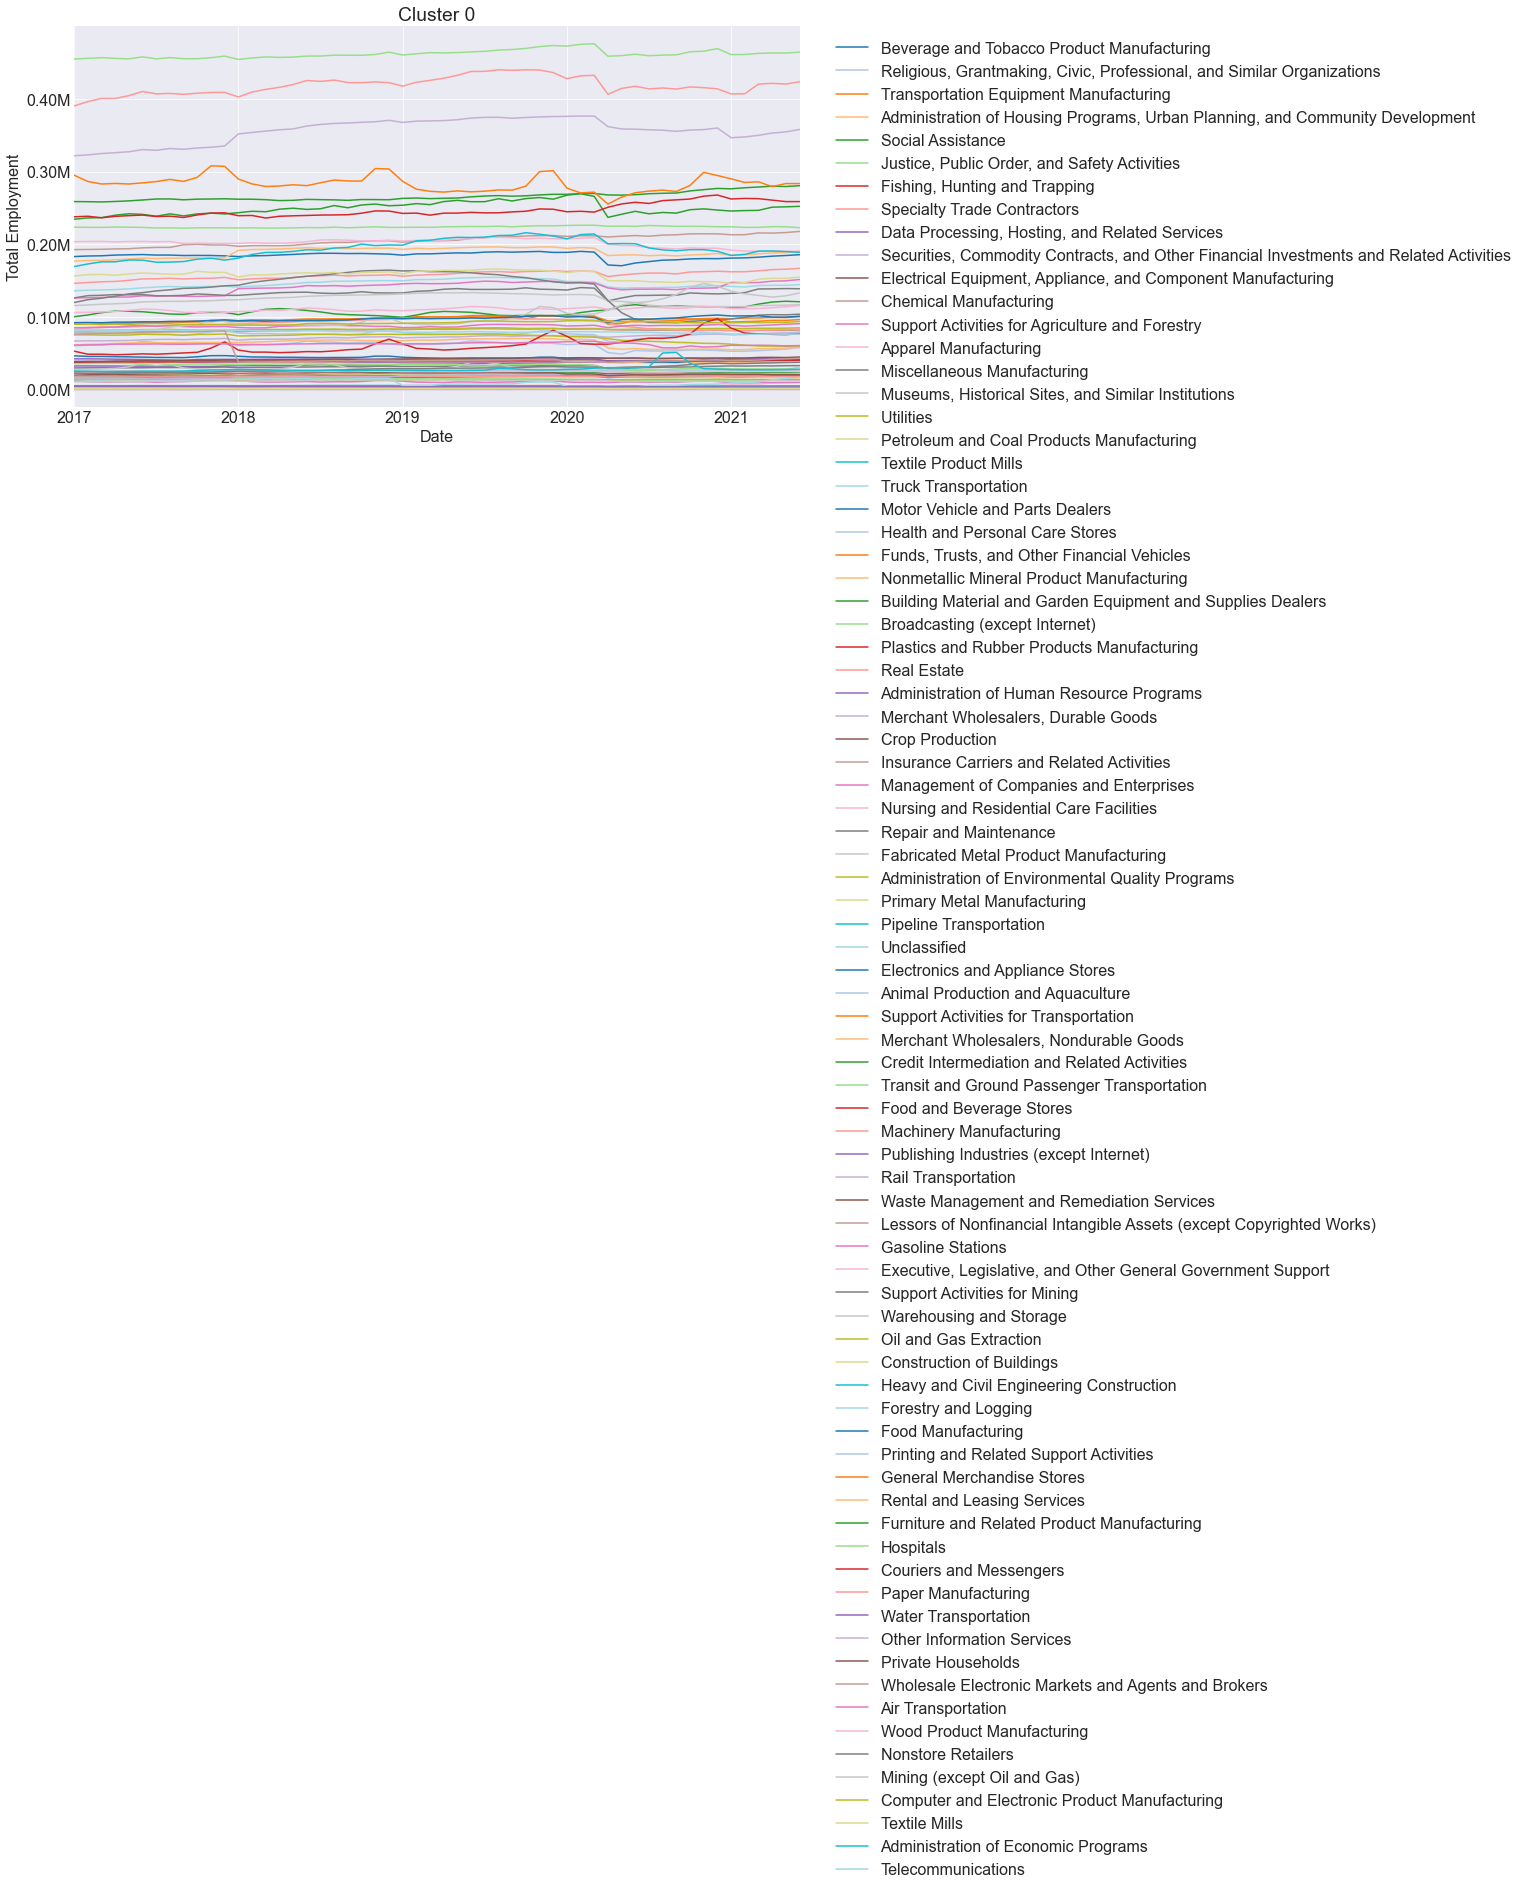

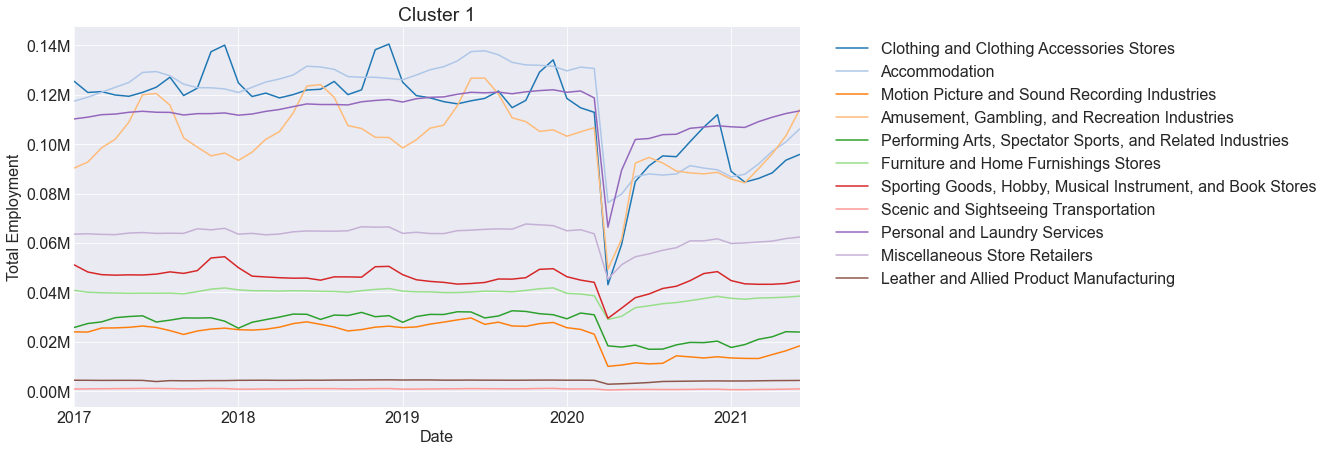

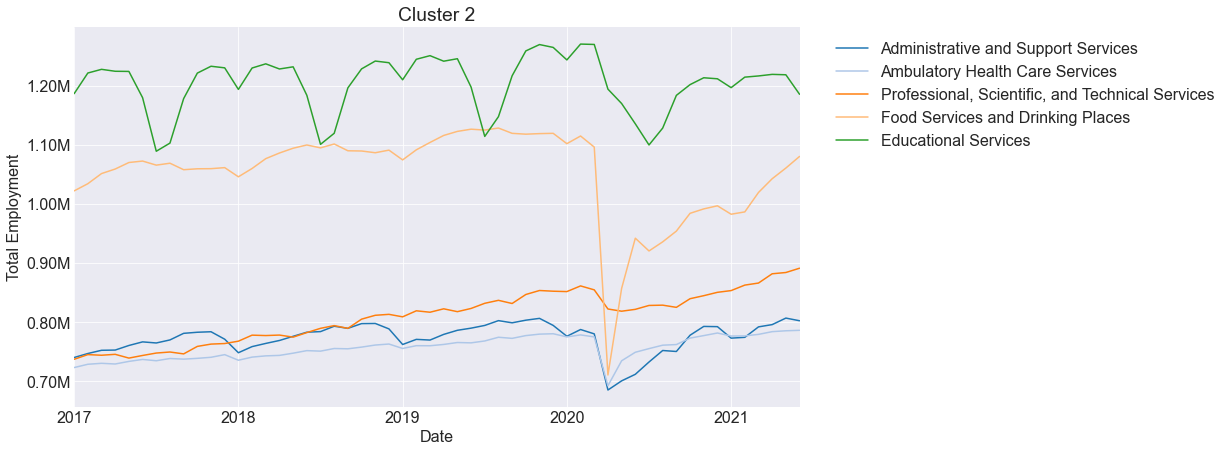

In [98]:
# create a loop that goes through each cluster subset, pulls list of industries, and then plots each industry on the same plot for that cluster
for clust in cluster_list:
    ind_list = cluster_df_dict[clust].Industry.value_counts().index.tolist() # create list of industries present in this specific cluster
    industry_df_dict = {} # create empty dictionary to house dfs for each industry df from each cluster
    for ind in ind_list:
        industry_df_dict[ind] = cluster_df_dict[clust][cluster_df_dict[clust].Industry == ind] # add dfs for each industry present in each cluster to dictionary
    for ind in ind_list:
        industry_df_dict[ind][['Date', 'Total Employment']].set_index('Date')['Total Employment'].sort_index().plot(label=ind) # plot each industry
    plt.gca().set(ylabel = 'Total Employment', title=f'Cluster {clust}')
    plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.2f}M'.format(x / 1_000_000))
    plt.legend(bbox_to_anchor= (1.03,1))
    plt.show()

#### Observations about this iteration:
- 5 clusters seemed to be too many had a couple clusters that had less than 5 industries
- 3 clusters was better
- Not sure why some industries from cluster 2 arent with 0 (specifically Food sevices)
- I think we should remove un normalized recovery slope

---
### Second Iteration

#### Changes made:
- removed un normalized recovery slope from feature set
- removed mean and std from feature set since they are so dependent on magnitude

In [99]:
# define function to characterize series
def characterize_series(series):
    pcnt_decrease = ((s['2020-03'][0] - s['2020-04'][0]) / s['2020-03'][0]) * 100 # will be used directly as a feature
    recovery_slope = (s['2020-06'][0] - s['2020-04'][0]) / 2 # will be used to calculate normalized version
    mean = s.mean() # will be used to normalize and to calculate other features
    std = s.std() # will be used to normalize and to calculate other features
    rec_slope_norm = recovery_slope / mean # feature
    cov = mean / std # feature
    characteristic_dict = {
        'pcnt_decrease' : pcnt_decrease, # how significant was the drop in total employment from March to April 2020?
        #'recovery_slope' : recovery_slope,
        #'mean' : mean,
        #'standard_dev' : std,
        'recovery_slope_normalized' : rec_slope_norm, # how steep was the recovery from 
        'cov' : cov
    }
    return characteristic_dict

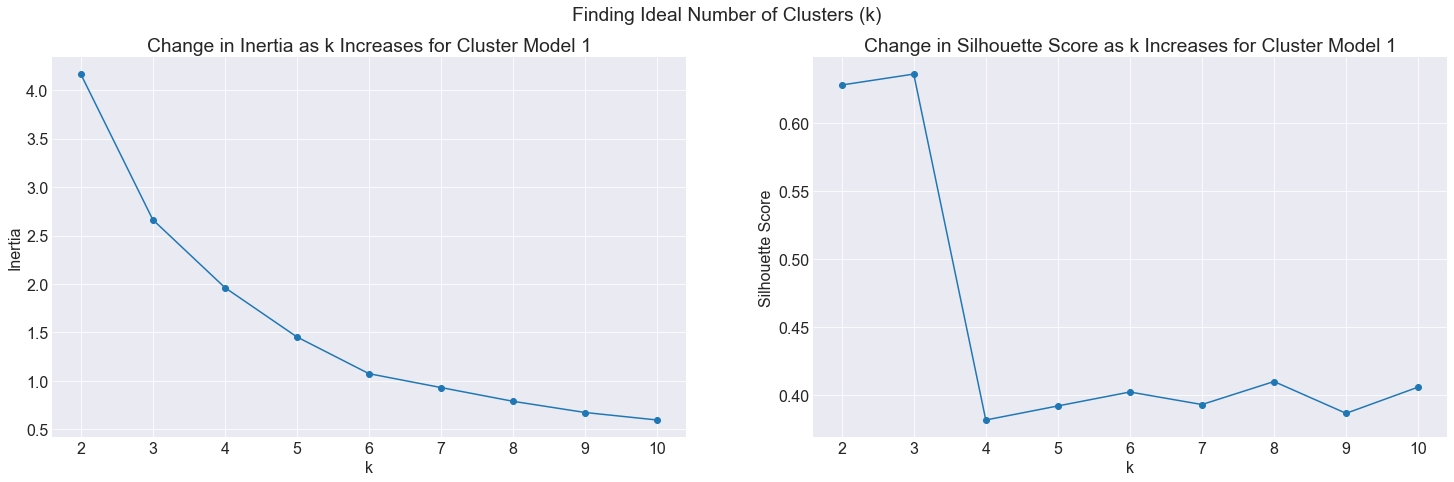

In [100]:
df = pd.read_excel('QCEW-TX-L3.xlsx') # get raw data
df = df[df.Ownership == 'Total All'] # filter just to all ownership groups
df = df[['Year', 'Period', 'Industry Code', 'Industry', 'Month 1 Employment', 'Month 2 Employment', 'Month 3 Employment']] # only keep necessary columns
df = df.melt(id_vars=['Year', 'Period', 'Industry Code', 'Industry'], var_name='Month', value_name='Total Employment') # melt columns to rows to get monthly instead of quarterly
df['Month'] = df.Month.apply(lambda x: [int(s) for s in x.split() if s.isdigit()][0]) # pull month integer out of string
df['Date'] = df.apply(extract_date, axis=1) # use function to pull out date from multiple columns
df.Date = pd.to_datetime(df.Date) # convert data to datetime dtype
ind_list = df.Industry.value_counts().index.tolist() # get list of industries
ind_list.pop(-1) # remove industry with missing data
industry_df_dict = {} # create empty df for dfs for each industry
for ind in ind_list:
    industry_df_dict[ind] = df[df.Industry == ind][['Date', 'Total Employment']].set_index('Date')['Total Employment'].sort_index()['2020'] # pull out series for just 2020 for each industry
characteristics = [] # create empty char list of dictionaries
for ind in ind_list: # loop through industries and characterize them each using function, append to list of dicts
    s = industry_df_dict[ind]
    characteristics.append(characterize_series(s))
char_df = pd.DataFrame(characteristics, index=ind_list) # convert to df
# char_df.sort_values(by='pcnt_decrease', ascending=True).head(10) # take a look at results and sort by column
scaled_char_df = scale(char_df, MinMaxScaler()) # scale df to use for clustering

### Plot Elbow and Silhouette

plt.figure(figsize=(25, 7)).suptitle('Finding Ideal Number of Clusters (k)')

kmax = 10

plt.subplot(121)

# let's plot inertia vs k for this model to chose number of clusters (k)

pd.Series({k: KMeans(k).fit(scaled_char_df).inertia_ for k in range(2, kmax+1)}).plot(marker='o')
plt.xticks(range(2, kmax+1))
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Change in Inertia as k Increases for Cluster Model 1')


plt.subplot(122)

pd.Series({k: silhouette_score(scaled_char_df, KMeans(k).fit(scaled_char_df).labels_) for k in range(2, kmax+1)}).plot(marker='o')
plt.xticks(range(2, kmax+1))
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Change in Silhouette Score as k Increases for Cluster Model 1');

4    36
2    24
0    22
1     7
3     4
5     3
Name: cluster_1, dtype: int64
4    0.375000
2    0.250000
0    0.229167
1    0.072917
3    0.041667
5    0.031250
Name: cluster_1, dtype: float64


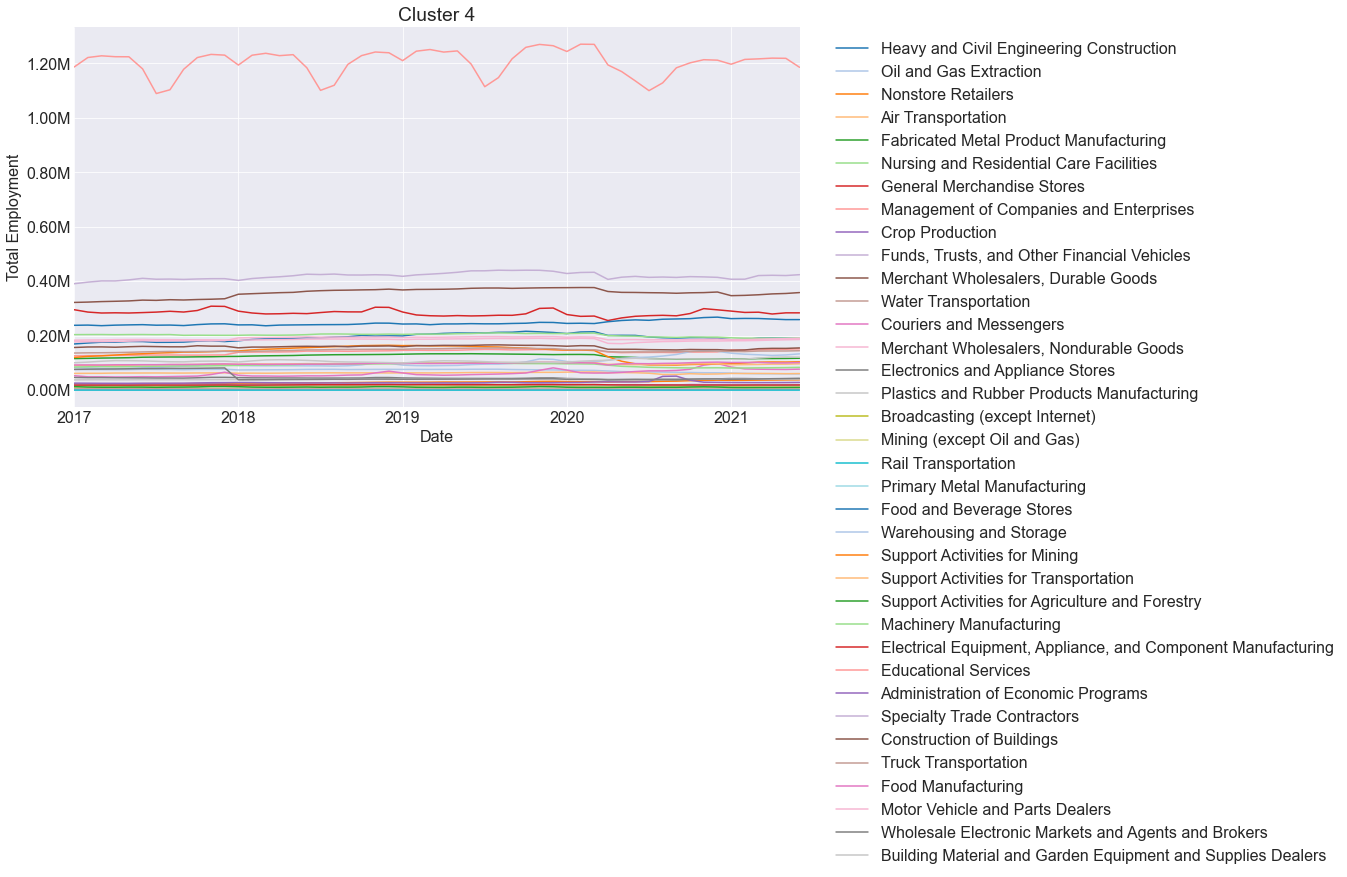

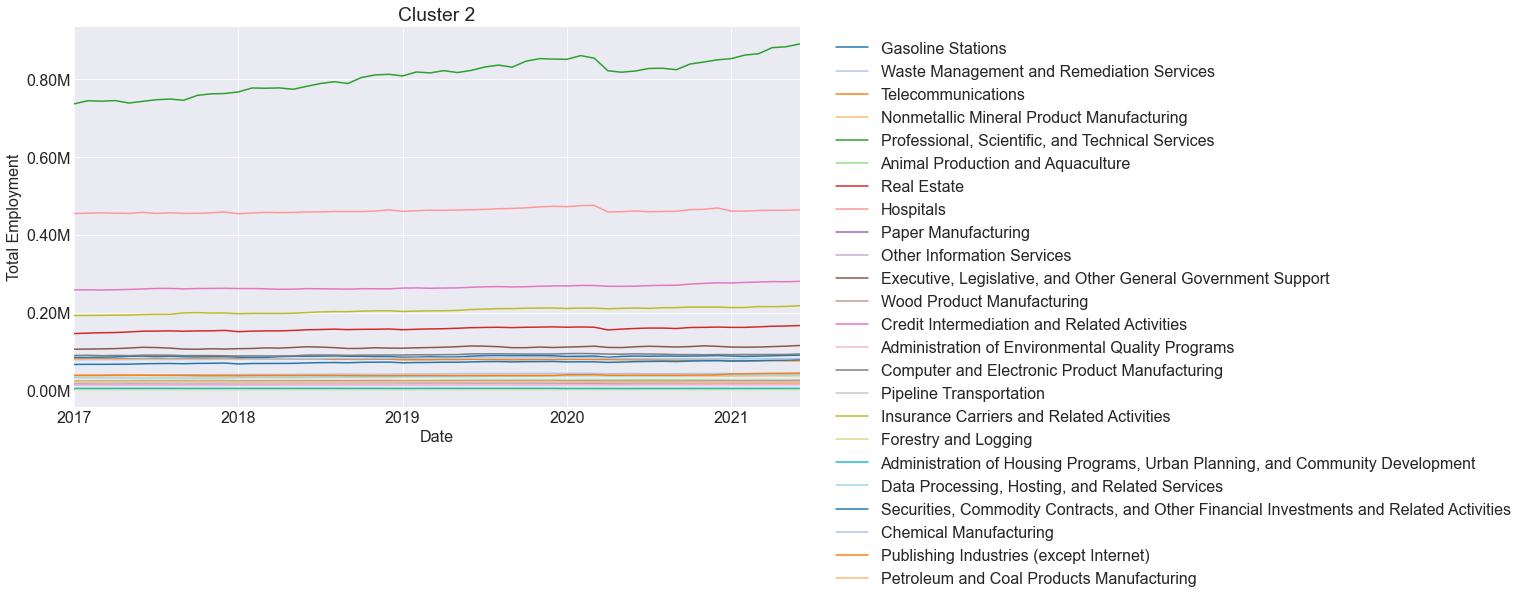

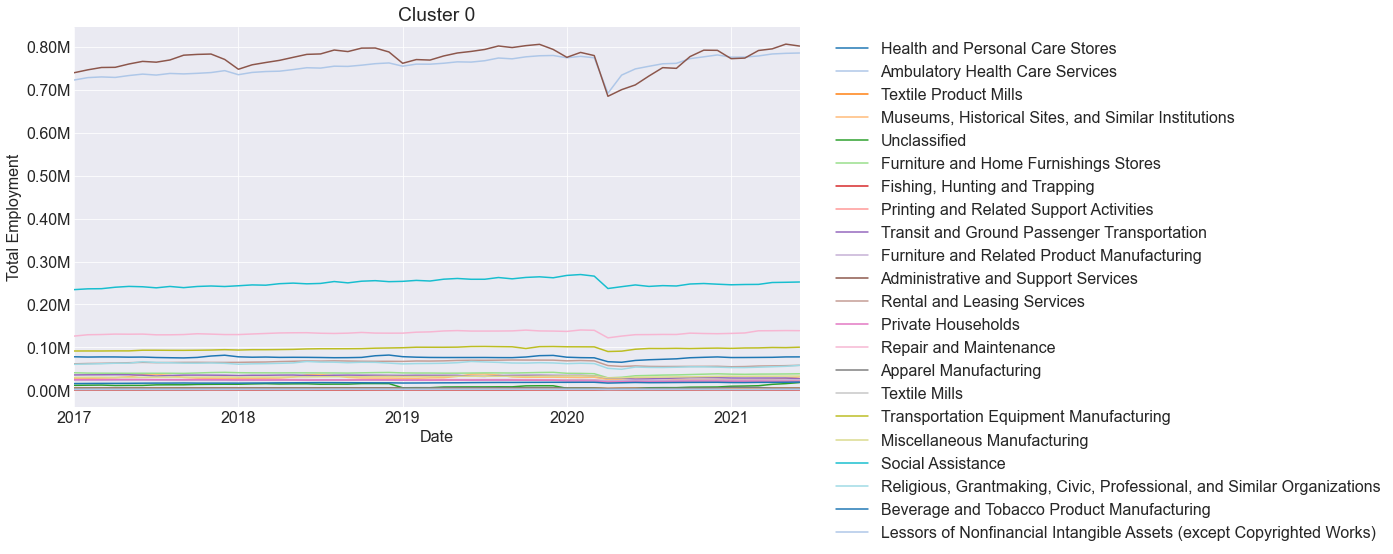

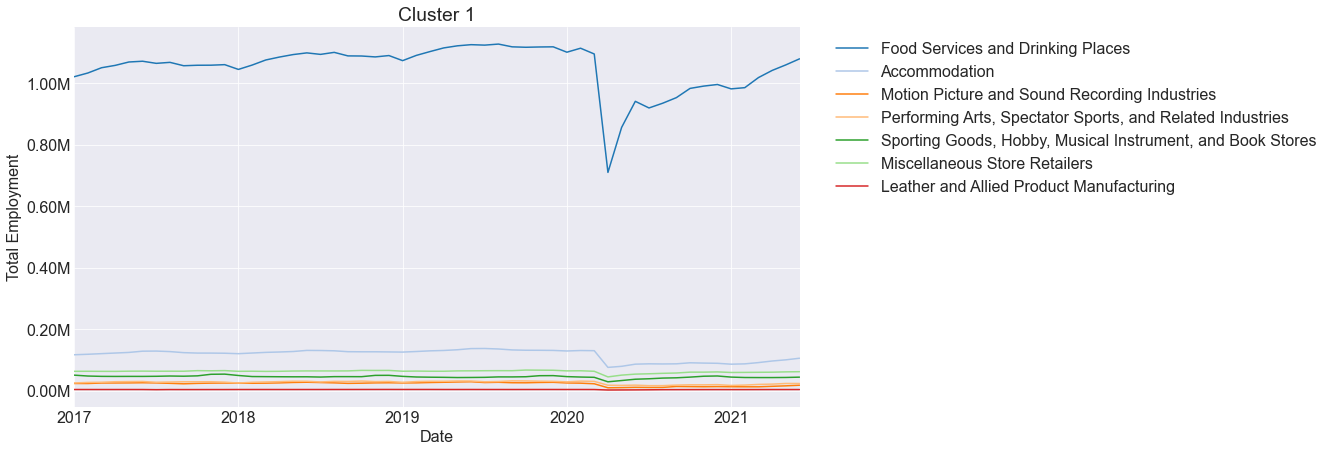

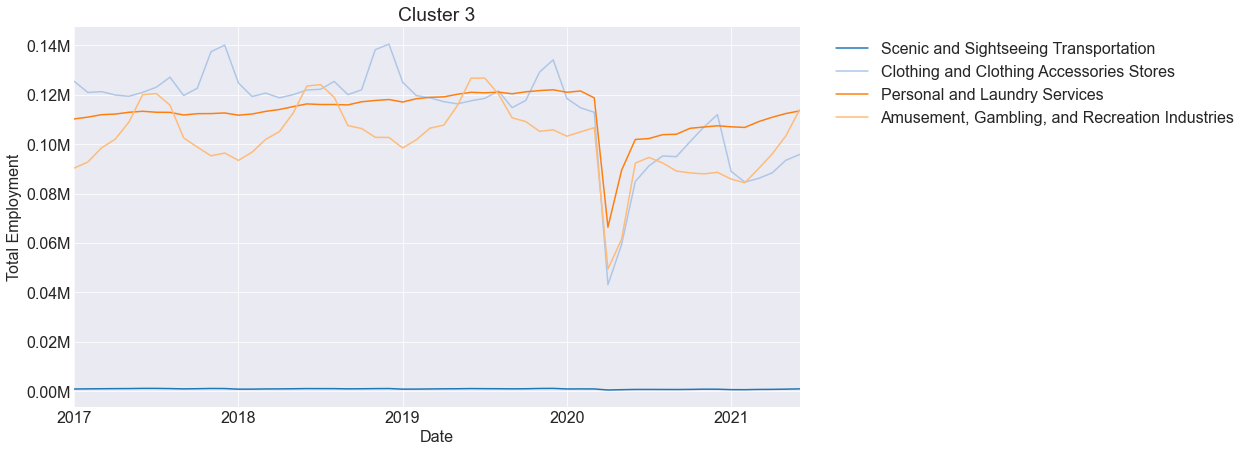

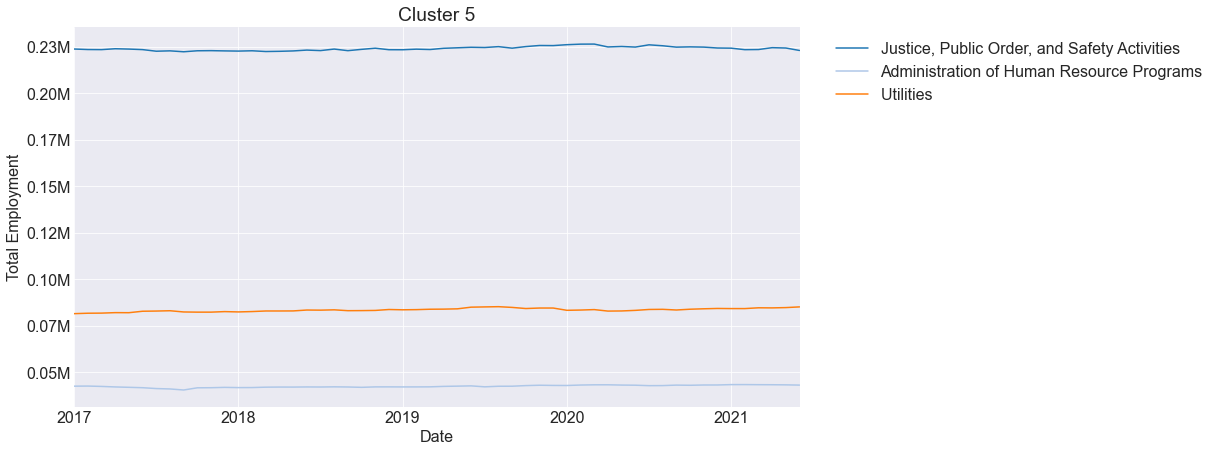

In [101]:
# create model object
kmeans1 = KMeans(n_clusters=6, random_state=527)

# fit the object to scaled, training data
kmeans1.fit(scaled_char_df)

# Use (predict using) the thing 
char_df['cluster_1'] = kmeans1.predict(scaled_char_df)
# scaled_char_df['cluster_1'] = kmeans1.predict(scaled_char_df)

print(char_df.cluster_1.value_counts()) # take a look at distribution of clusters
print(char_df.cluster_1.value_counts(normalize=True)) # normalized

cluster_labels_dict = char_df[['cluster_1']].to_dict()['cluster_1'] # get dictionary of cluster labels for each industry
df['Cluster'] = df.Industry.map(cluster_labels_dict) # add new column to df with labels

df = df[df.Industry != 'Monetary Authorities-Central Bank'] # need to drop this since there was missing data for this industry

df.Cluster = df.Cluster.astype('int') # cast as int
cluster_list = df.Cluster.value_counts().index.tolist() # create list of clusters
cluster_df_dict = {} # create empty dictionary for subset dfs for each cluster
for clust in cluster_list:
    cluster_df_dict[clust] = df[df.Cluster == clust] # add dfs to dictionary
    
for clust in cluster_list: # plot industries for each cluster on same chart
    ind_list = cluster_df_dict[clust].Industry.value_counts().index.tolist() # create list of industries present in this specific cluster
    industry_df_dict = {} # create empty dictionary to house dfs for each industry df from each cluster
    for ind in ind_list:
        industry_df_dict[ind] = cluster_df_dict[clust][cluster_df_dict[clust].Industry == ind] # add dfs for each industry present in each cluster to dictionary
    for ind in ind_list:
        industry_df_dict[ind][['Date', 'Total Employment']].set_index('Date')['Total Employment'].sort_index().plot(label=ind) # plot each industry
    plt.gca().set(ylabel = 'Total Employment', title=f'Cluster {clust}')
    plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.2f}M'.format(x / 1_000_000))
    plt.legend(bbox_to_anchor= (1.03,1))
    plt.show()

#### Observations about this iteration:
- Much better
- Size of industry was impacting results in previous feature set (slope, mean, and std were not normalized and should have just been used to calculate other features)
- 2 clusters seems to group highly affected an less affected
- 3 clusters takes 4 from less affected and creates a new small grouping of not affected at all (high, medium, low groups)
    - Splits highly affected into 2 groups
        - Seasonal vs non seasonal
    - Hard to see commonalities in other clusters

---
### Third Iteration

#### Changes made:
- Add max value
- Add min value
- Add Bollinger bands (upper and lower)
    - Use them calculate %b for min and max values in each series

**Working on adding bollinger bands**
- Need to pull more data into dictionary of dfs for each industry
- Take mean for all of 2019
- Take standard deviation for all of 2019
- Use these values to compute UB and LB
- Use UB and LB to calculate %b for min and max of 2020 data for each industry

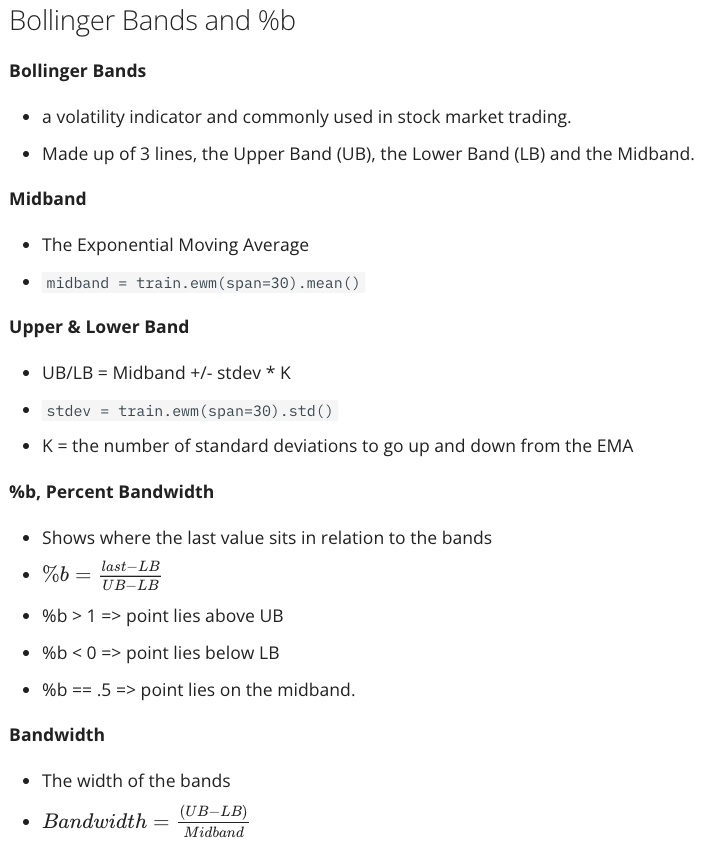

In [102]:
# define function to characterize series
def characterize_series(series):
    pcnt_decrease_mar_apr = ((s['2020-03'][0] - s['2020-04'][0]) / s['2020-03'][0]) * 100
    immediate_recovery_slope = (s['2020-06'][0] - s['2020-04'][0]) / 2
    # pcnt_increase_apr_jun = ((s['2020-06'][0] - s['2020-04'][0]) / s['2020-04'][0]) * 100 # metric
    mean_2020 = s['2020'].mean()
    std_2020 = s['2020'].std()
    rec_slope_norm = immediate_recovery_slope / mean_2020
    cov_2020 = mean_2020 / std_2020
    min_2020 = s['2020'].min()
    max_2020 = s['2020'].max()
    mean_2019 = s['2019'].mean()
    std_2019 = s['2019'].std()
    UB = mean_2019 + 3 * std_2019
    LB = mean_2019 - 3 * std_2019
    pct_b_min = (min_2020 - LB) / (UB - LB)
    pct_b_max = (max_2020 - LB) / (UB - LB)
    characteristic_dict = {
        'pcnt_decrease_mar_apr' : pcnt_decrease_mar_apr, # how steep was decline from Mar Apr
        'immediate_recovery_slope_norm' : rec_slope_norm, # how steep was the recovery from Apr to Jun
        #'pcnt_increase_apr_jun' : pcnt_increase_apr_jun,
        'cov_2020' : cov_2020, # how much did employment vary in 2020
        'pct_b_min' : pct_b_min, # how far outside of historical data (2019) did min alue for 2020 fall
        'pct_b_max' : pct_b_max # how far outside of historical data (2019) did min alue for 2020 fall
    }
    return characteristic_dict

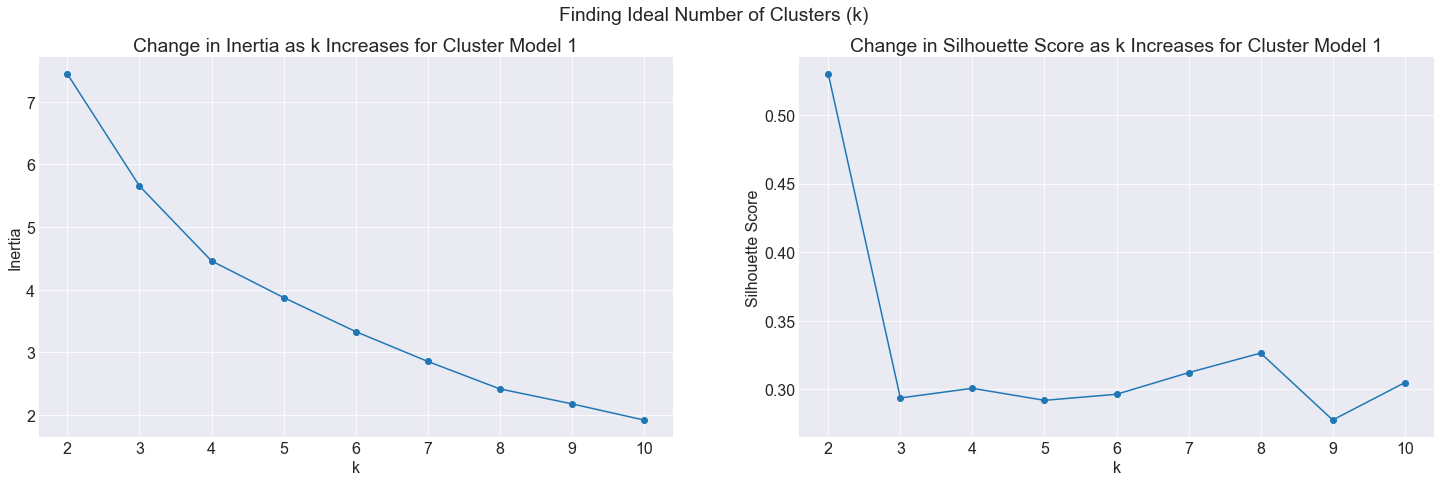

In [103]:
df = pd.read_excel('QCEW-TX-L3.xlsx') # get raw data
df = df[df.Ownership == 'Total All'] # filter just to all ownership groups
df = df[['Year', 'Period', 'Industry Code', 'Industry', 'Month 1 Employment', 'Month 2 Employment', 'Month 3 Employment']] # only keep necessary columns
df = df.melt(id_vars=['Year', 'Period', 'Industry Code', 'Industry'], var_name='Month', value_name='Total Employment') # melt columns to rows to get monthly instead of quarterly
df['Month'] = df.Month.apply(lambda x: [int(s) for s in x.split() if s.isdigit()][0]) # pull month integer out of string
df['Date'] = df.apply(extract_date, axis=1) # use function to pull out date from multiple columns
df.Date = pd.to_datetime(df.Date) # convert data to datetime dtype
ind_list = df.Industry.value_counts().index.tolist() # get list of industries
ind_list.pop(-1) # remove industry with missing data
industry_df_dict = {} # create empty df for dfs for each industry
for ind in ind_list:
    industry_df_dict[ind] = df[df.Industry == ind][['Date', 'Total Employment']].set_index('Date')['Total Employment'].sort_index()['2019' : '2020'] # pull out series time interval
characteristics = [] # create empty char list of dictionaries
for ind in ind_list: # loop through industries and characterize them each using function, append to list of dicts
    s = industry_df_dict[ind]
    characteristics.append(characterize_series(s)) 

char_df = pd.DataFrame(characteristics, index=ind_list) # convert to df
# char_df.sort_values(by='pcnt_decrease', ascending=True).head(10) # take a look at results and sort by column
scaled_char_df = scale(char_df, MinMaxScaler()) # scale df to use for clustering

### Plot Elbow and Silhouette

plt.figure(figsize=(25, 7)).suptitle('Finding Ideal Number of Clusters (k)')

kmax = 10

plt.subplot(121)

# let's plot inertia vs k for this model to chose number of clusters (k)

pd.Series({k: KMeans(k).fit(scaled_char_df).inertia_ for k in range(2, kmax+1)}).plot(marker='o')
plt.xticks(range(2, kmax+1))
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Change in Inertia as k Increases for Cluster Model 1')


plt.subplot(122)

pd.Series({k: silhouette_score(scaled_char_df, KMeans(k).fit(scaled_char_df).labels_) for k in range(2, kmax+1)}).plot(marker='o')
plt.xticks(range(2, kmax+1))
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Change in Silhouette Score as k Increases for Cluster Model 1');

In [104]:
char_df.sort_values(by='pct_b_max', ascending=False).head(10)

pcnt_decrease_mar_apr  \
Administration of Economic Programs                             -2.361331   
Publishing Industries (except Internet)                          3.780102   
Food and Beverage Stores                                        -2.721895   
Nonstore Retailers                                               3.967186   
Credit Intermediation and Related Activities                     0.762316   
Warehousing and Storage                                         -5.055032   
Furniture and Related Product Manufacturing                      8.318347   
Building Material and Garden Equipment and Supp...              -1.102687   
Funds, Trusts, and Other Financial Vehicles                     -2.905441   
Data Processing, Hosting, and Related Services                   1.333718   

                                                    immediate_recovery_slope_norm  \
Administration of Economic Programs                                     -0.007616   
Publishing Industries (except Internet)                                  0.002312   
Food and Beverage Stores                                                 0.013384   
Nonstore Retailers                                                       0.020609   
Credit Intermediation and Related Activities                             0.000783   
Warehousing and Storage                                                  0.042228   
Furniture and Related Product Manufacturing                              0.035671   
Building Material and Garden Equipment and Supp...                       0.032324   
Funds, Trusts, and Other Financial Vehicles                              0.002073   
Data Processing, Hosting, and Related Services                           0.002157   

                                                     cov_2020  pct_b_min  \
Administration of Economic Programs                  4.007702   0.642457   
Publishing Industries (except Internet)             66.360838   1.357891   
Food and Beverage Stores                            31.434619   0.516579   
Nonstore Retailers                                  15.558858   0.481783   
Credit Intermediation and Related Activities        91.883870   0.683144   
Warehousing and Storage                              7.933667   0.613584   
Furniture and Related Product Manufacturing         39.858673  -1.968927   
Building Material and Garden Equipment and Supp...  25.696598   0.443768   
Funds, Trusts, and Other Financial Vehicles         40.726293   0.874950   
Data Processing, Hosting, and Related Services      82.735871   0.886671   

                                                    pct_b_max  
Administration of Economic Programs                  4.935616  
Publishing Industries (except Internet)              3.000376  
Food and Beverage Stores                             2.139735  
Nonstore Retailers                                   1.545393  
Credit Intermediation and Related Activities         1.436491  
Warehousing and Storage                              1.431846  
Furniture and Related Product Manufacturing          1.400072  
Building Material and Garden Equipment and Supp...   1.341530  
Funds, Trusts, and Other Financial Vehicles          1.340864  
Data Processing, Hosting, and Related Services       1.261514

3    38
0    30
6    11
1    10
2     3
4     3
5     1
Name: cluster_1, dtype: int64
3    0.395833
0    0.312500
6    0.114583
1    0.104167
2    0.031250
4    0.031250
5    0.010417
Name: cluster_1, dtype: float64


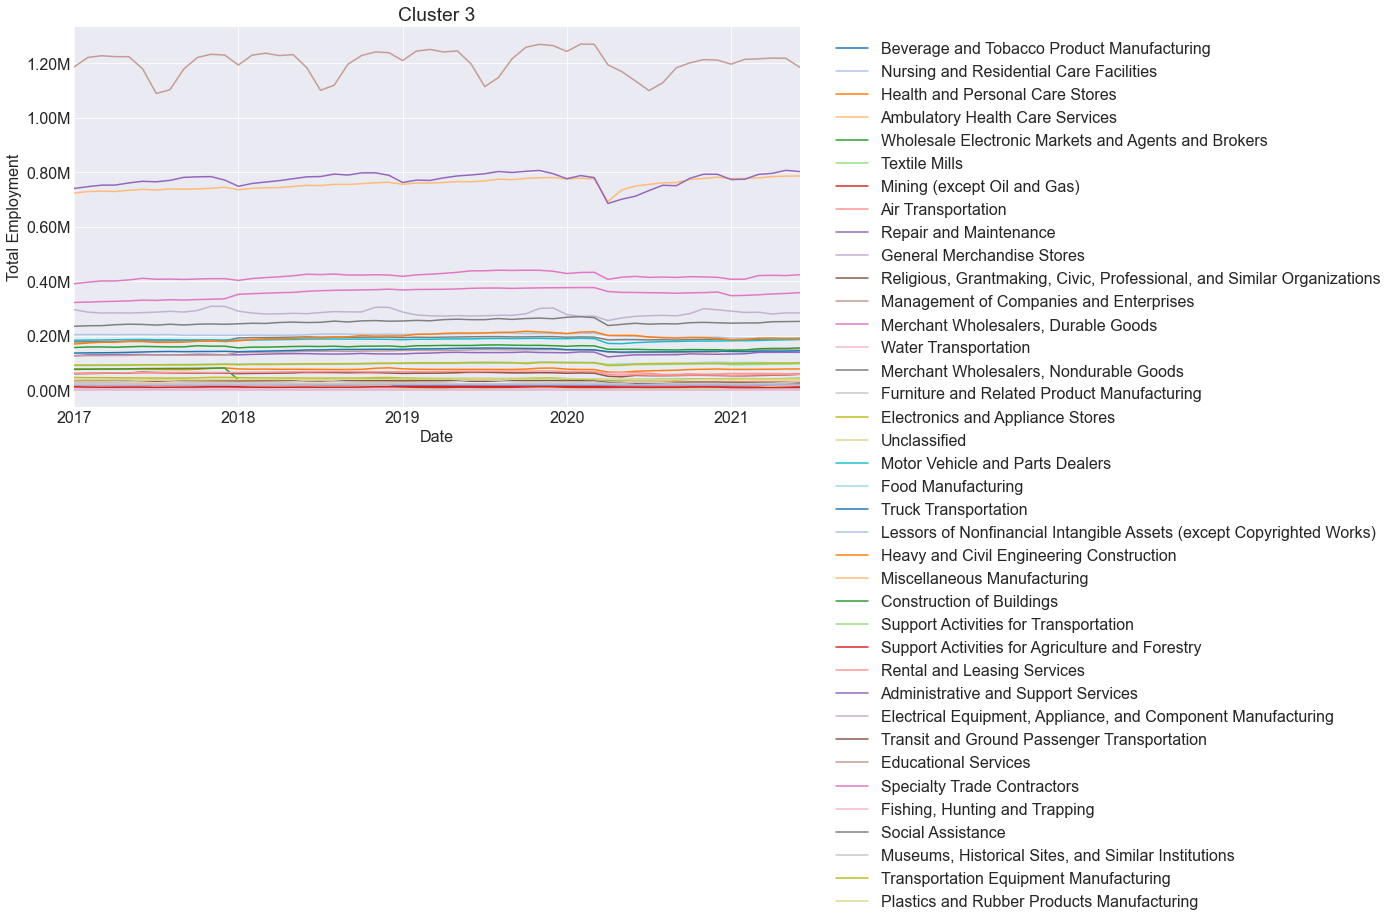

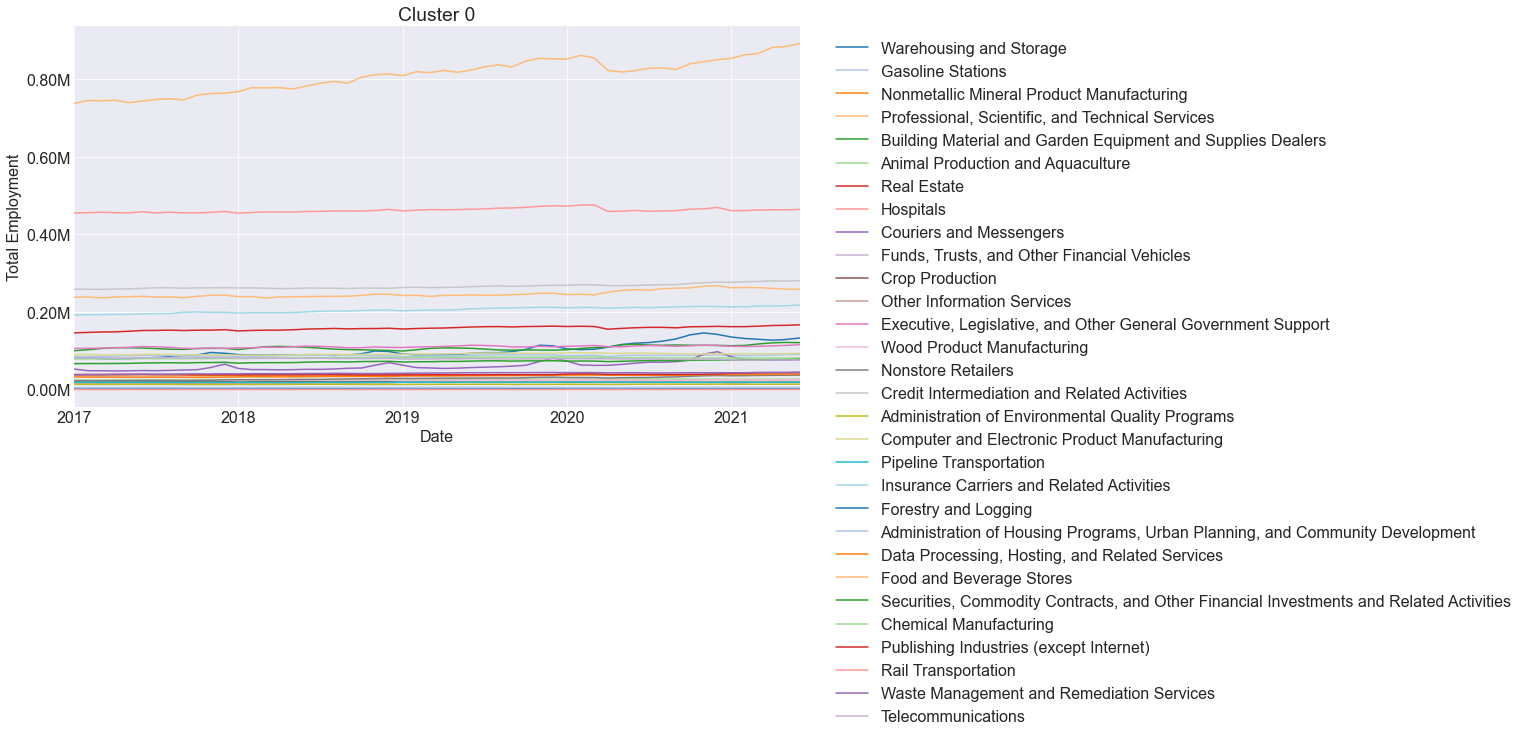

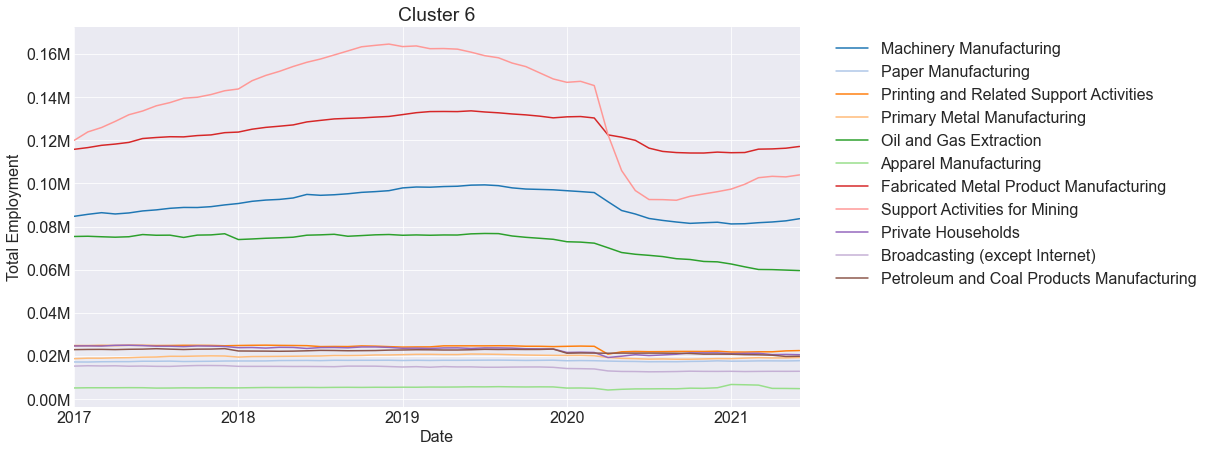

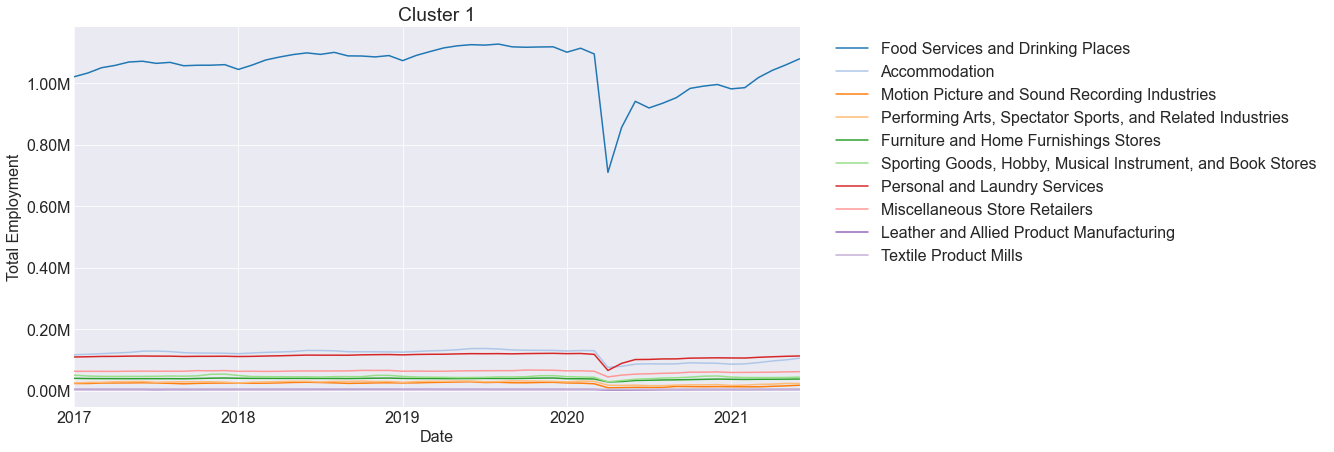

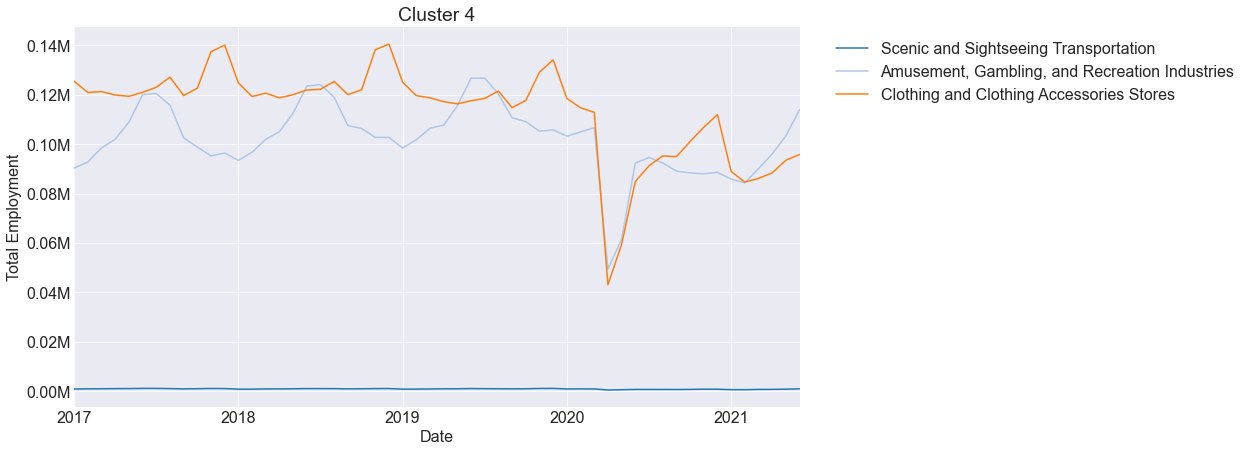

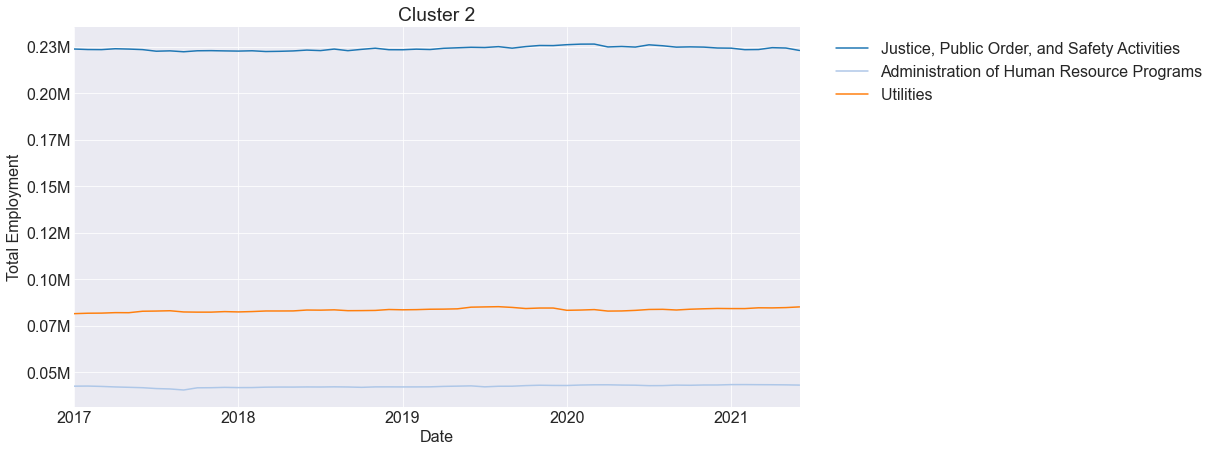

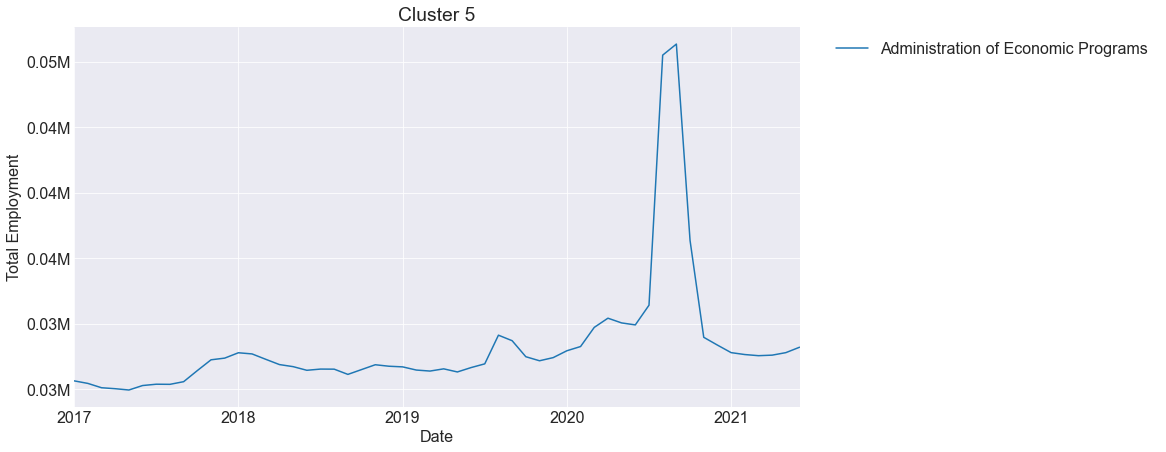

In [105]:
# create model object
kmeans1 = KMeans(n_clusters=7, random_state=527)

# fit the object to scaled, training data
kmeans1.fit(scaled_char_df)

# Use (predict using) the thing 
char_df['cluster_1'] = kmeans1.predict(scaled_char_df)
# scaled_char_df['cluster_1'] = kmeans1.predict(scaled_char_df)

print(char_df.cluster_1.value_counts()) # take a look at distribution of clusters
print(char_df.cluster_1.value_counts(normalize=True)) # normalized

cluster_labels_dict = char_df[['cluster_1']].to_dict()['cluster_1'] # get dictionary of cluster labels for each industry
df['Cluster'] = df.Industry.map(cluster_labels_dict) # add new column to df with labels

df = df[df.Industry != 'Monetary Authorities-Central Bank'] # need to drop this since there was missing data for this industry

df.Cluster = df.Cluster.astype('int') # cast as int
cluster_list = df.Cluster.value_counts().index.tolist() # create list of clusters
cluster_df_dict = {} # create empty dictionary for subset dfs for each cluster
for clust in cluster_list:
    cluster_df_dict[clust] = df[df.Cluster == clust] # add dfs to dictionary
    
for clust in cluster_list: # plot industries for each cluster on same chart
    ind_list = cluster_df_dict[clust].Industry.value_counts().index.tolist() # create list of industries present in this specific cluster
    industry_df_dict = {} # create empty dictionary to house dfs for each industry df from each cluster
    for ind in ind_list:
        industry_df_dict[ind] = cluster_df_dict[clust][cluster_df_dict[clust].Industry == ind] # add dfs for each industry present in each cluster to dictionary
    for ind in ind_list:
        industry_df_dict[ind][['Date', 'Total Employment']].set_index('Date')['Total Employment'].sort_index().plot(label=ind) # plot each industry
    plt.gca().set(ylabel = 'Total Employment', title=f'Cluster {clust}')
    plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.2f}M'.format(x / 1_000_000))
    plt.legend(bbox_to_anchor= (1.03,1))
    plt.show()

#### Observations about this iteration:
- Really like the feature set
    - All features seem to be capturing important behavior and are normalized where needed
- 3 clusters seems to be best here
    - High medium and low impact

---
### Fourth Iteration

#### Changes made:
- Pull in data up to most recent
    - Will need from Jan 2019 to most recent for current calculations
- Change immediate recovery metric to % change from Apr to June
    - More readable
    - Time frame set, therefore time component not necessary
    - Can be used in conjuction with pcnt decrease to create bounceback metric
        - Not sure if bounceback metric will be redundant if just combination of two other metrics
- Add long term recovery metric
    - % change
    - Apr 2020 to most recent data point
- Add COV % change from 2019 to 2020
    - How much more variable did the industry become because of COVID?
    - COV 2019 / COV 2020
- Bounceback metric
    - Percent decrease - immediate recovery = net change over interval (53 % drop - 20% recovery = 33% net drop)
    - Will just be calculation using existing features
- Metric change for industries not recovering yet
    - % change from Mar 2020 to most recent
- Take off cov 2020 since it will be encapsulated in change in cov
    - Not as relevant to just look at cov for one year with no context of previous years?
- Add slope for all % change metrics and vice verse to try both metrics

In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# from sklearn.metrics import mean_squared_error, explained_variance_score
# import statsmodels.api as sm
# from statsmodels.tsa.api import Holt
# from datetime import datetime

# no yelling cin the library
import warnings
warnings.filterwarnings("ignore")

# plt.rc('figure', figsize=(13, 7))c
# plt.rc('axes.spines', top=False, right=False)
# plt.rc('font', size=13)

# visualization settings
plt.rc('figure', figsize=(13, 7))
plt.rc('font', size=16)
plt.style.use('seaborn-darkgrid')
sns.set_palette('tab20')
# pal = sns.set_palette('tab20')

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [107]:
# need to scale data first
def scale(df, scaler):
    '''
    Takes in df and scaler of your choosing and returns df with encoded columns
    '''
    cols = df.columns.tolist()
    new_column_names = [c + '_scaled' for c in cols]
    
    # Fit the scaler on the train
    scaler.fit(df)
    
    # transform train validate and test
    df = pd.concat([
        df,
        pd.DataFrame(scaler.transform(df), columns=new_column_names, index=df.index),
    ], axis=1)
    
    # drop scaled columns
    df = df.drop(columns=cols)
    
    return df

In [108]:
# create a function that takes each row and creates a date column for the observation
def extract_date(df):
    if (df[1] == 1) & (df[4] == 1): # first quarter, first month
        return str(df[0]) + '-' + '01' # January
    elif (df[1] == 1) & (df[4] == 2):
        return str(df[0]) + '-' + '02'
    elif (df[1] == 1) & (df[4] == 3):
        return str(df[0]) + '-' + '03'
    elif (df[1] == 2) & (df[4] == 1):
        return str(df[0]) + '-' + '04'
    elif (df[1] == 2) & (df[4] == 2):
        return str(df[0]) + '-' + '05'
    elif (df[1] == 2) & (df[4] == 3):
        return str(df[0]) + '-' + '06'
    elif (df[1] == 3) & (df[4] == 1):
        return str(df[0]) + '-' + '07'
    elif (df[1] == 3) & (df[4] == 2):
        return str(df[0]) + '-' + '08'
    elif (df[1] == 3) & (df[4] == 3):
        return str(df[0]) + '-' + '09'
    elif (df[1] == 4) & (df[4] == 1):
        return str(df[0]) + '-' + '10'
    elif (df[1] == 4) & (df[4] == 2):
        return str(df[0]) + '-' + '11'
    elif (df[1] == 4) & (df[4] == 3):
        return str(df[0]) + '-' + '12'

In [109]:
# define function to characterize series
def characterize_series(s):
    mean_2020 = s['2020'].mean() # to use for normalization
    std_2020 = s['2020'].std() # to use for normalization
    pcnt_decrease_mar_apr = ((s['2020-03'][0] - s['2020-04'][0]) / s['2020-03'][0]) * 100 # metric
    norm_slope_mar_apr = ((s['2020-04'][0] - s['2020-03'][0]) / 1) / mean_2020 # want to have both to see which is better metric
    pcnt_increase_apr_jun = ((s['2020-06'][0] - s['2020-04'][0]) / s['2020-04'][0]) * 100 # metric
    norm_slope_apr_jun = ((s['2020-06'][0] - s['2020-04'][0]) / 2) / mean_2020 # chose to go with percent change instead
    pcnt_increase_apr_recent = ((s['2021-06'][0] - s['2020-04'][0]) / s['2020-04'][0]) * 100 # metric
    norm_slope_apr_recent = (s['2021-06'][0] - s['2020-04'][0]) / 14 # metric
    pcnt_decrease_mar_recent = ((s['2020-03'][0] - s['2021-06'][0]) / s['2020-03'][0]) * 100 # metric
    norm_slope_mar_recent = (s['2021-06'][0] - s['2020-03'][0]) / 15 # metric
    cov_2020 = mean_2020 / std_2020 # metric
    min_2020 = s['2020'].min()
    max_2020 = s['2020'].max()
    mean_2019 = s['2019'].mean()
    std_2019 = s['2019'].std()
    cov_2019 = mean_2019 / std_2019 # Used to get change in cov metric
    cov_change = cov_2019 / cov_2020 # metric
    UB = mean_2019 + 3 * std_2019
    LB = mean_2019 - 3 * std_2019
    pct_b_min = (min_2020 - LB) / (UB - LB)
    pct_b_max = (max_2020 - LB) / (UB - LB)
    bounceback = pcnt_decrease_mar_apr - pcnt_increase_apr_jun
    characteristic_dict = {
        'pcnt_decrease_mar_apr' : pcnt_decrease_mar_apr, # measure of drop after shut down
#         'norm_slope_mar_apr' : norm_slope_mar_apr, # alternate measure of drop after shut down
#         'pcnt_increase_apr_jun' : pcnt_increase_apr_jun, # measure of immediate recovery after initial drop
        'norm_slope_apr_jun' : norm_slope_apr_jun, # alternate measure of immediate recovery after initial drop
#         'pcnt_increase_apr_recent' : pcnt_increase_apr_recent, # measure of longer-term recovery
#         'norm_slope_apr_recent' : norm_slope_apr_recent, # alternate measure of longer-term recovery
#         'pcnt_decrease_mar_recent' : pcnt_decrease_mar_recent, # measure of longer-term recovery for those that didn't have big drop and haven't recovered much
#         'norm_slope_mar_recent' : norm_slope_mar_recent, # alternate measure of above
        'cov_2020' : cov_2020, # measure of shake up due to COVID
#         'cov_2019' : cov_2019, # measure of variation pre-pandemic
#         'cov_change' : cov_change, # measure of change in variation due to pandemic
        'pct_b_min' : pct_b_min, # measure of min compared to 2019 data
        'pct_b_max' : pct_b_max, # measure of max compared to 2019 data
#         'bounceback' : bounceback # single metric to measure bounceback
    }
    return characteristic_dict

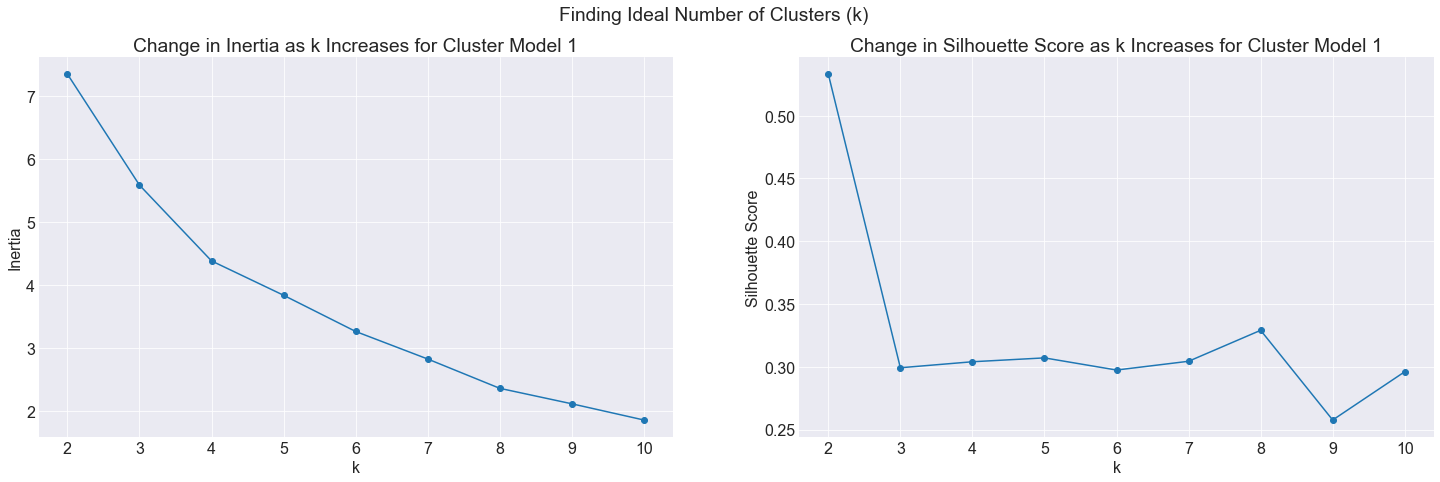

In [110]:
df = pd.read_excel('QCEW-TX-L3.xlsx') # get raw data
df = df[df.Ownership == 'Total All'] # filter just to all ownership groups
df = df[['Year', 'Period', 'Industry Code', 'Industry', 'Month 1 Employment', 'Month 2 Employment', 'Month 3 Employment']] # only keep necessary columns
df = df.melt(id_vars=['Year', 'Period', 'Industry Code', 'Industry'], var_name='Month', value_name='Total Employment') # melt columns to rows to get monthly instead of quarterly
df['Month'] = df.Month.apply(lambda x: [int(s) for s in x.split() if s.isdigit()][0]) # pull month integer out of string
df['Date'] = df.apply(extract_date, axis=1) # use function to pull out date from multiple columns
df.Date = pd.to_datetime(df.Date) # convert data to datetime dtype
ind_list = df.Industry.value_counts().index.tolist() # get list of industries
ind_list.remove('Monetary Authorities-Central Bank')
ind_list.remove('Unclassified')
#ind_list.pop(-1) # remove industry with missing data
industry_df_dict = {} # create empty df for dfs for each industry
for ind in ind_list:
    industry_df_dict[ind] = df[df.Industry == ind][['Date', 'Total Employment']].set_index('Date')['Total Employment'].sort_index()['2019' : ] # pull out series time interval
characteristics = [] # create empty char list of dictionaries
for ind in ind_list: # loop through industries and characterize them each using function, append to list of dicts
    s = industry_df_dict[ind]
    characteristics.append(characterize_series(s)) 

char_df = pd.DataFrame(characteristics, index=ind_list) # convert to df
# char_df.sort_values(by='pcnt_decrease', ascending=True).head(10) # take a look at results and sort by column
scaled_char_df = scale(char_df, MinMaxScaler()) # scale df to use for clustering

### Plot Elbow and Silhouette

plt.figure(figsize=(25, 7)).suptitle('Finding Ideal Number of Clusters (k)')

kmax = 10

plt.subplot(121)

# let's plot inertia vs k for this model to chose number of clusters (k)

pd.Series({k: KMeans(k).fit(scaled_char_df).inertia_ for k in range(2, kmax+1)}).plot(marker='o')
plt.xticks(range(2, kmax+1))
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Change in Inertia as k Increases for Cluster Model 1')


plt.subplot(122)

pd.Series({k: silhouette_score(scaled_char_df, KMeans(k).fit(scaled_char_df).labels_) for k in range(2, kmax+1)}).plot(marker='o')
plt.xticks(range(2, kmax+1))
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Change in Silhouette Score as k Increases for Cluster Model 1');

In [111]:
# char_df.sort_values(by='pct_b_max', ascending=False).head(10)

In [112]:
# # create model object
# kmeans1 = KMeans(n_clusters=7, random_state=527)

# # fit the object to scaled, training data
# kmeans1.fit(scaled_char_df)

# # Use (predict using) the thing 
# char_df['cluster_1'] = kmeans1.predict(scaled_char_df)
# # scaled_char_df['cluster_1'] = kmeans1.predict(scaled_char_df)

# print(char_df.cluster_1.value_counts()) # take a look at distribution of clusters
# print(char_df.cluster_1.value_counts(normalize=True)) # normalized

# cluster_labels_dict = char_df[['cluster_1']].to_dict()['cluster_1'] # get dictionary of cluster labels for each industry
# df['Cluster'] = df.Industry.map(cluster_labels_dict) # add new column to df with labels

# df = df[df.Industry != 'Monetary Authorities-Central Bank'] # need to drop this since there was missing data for this industry
# df = df[df.Industry != 'Unclassified'] # need to drop this since there was missing data for this industry

# df.Cluster = df.Cluster.astype('int') # cast as int
# cluster_list = df.Cluster.value_counts().index.tolist() # create list of clusters
# cluster_df_dict = {} # create empty dictionary for subset dfs for each cluster
# for clust in cluster_list:
#     cluster_df_dict[clust] = df[df.Cluster == clust] # add dfs to dictionary
    
# for clust in cluster_list: # plot industries for each cluster on same chart
#     ind_list = cluster_df_dict[clust].Industry.value_counts().index.tolist() # create list of industries present in this specific cluster
#     industry_df_dict = {} # create empty dictionary to house dfs for each industry df from each cluster
#     for ind in ind_list:
#         industry_df_dict[ind] = cluster_df_dict[clust][cluster_df_dict[clust].Industry == ind] # add dfs for each industry present in each cluster to dictionary
#     for ind in ind_list:
#         industry_df_dict[ind][['Date', 'Total Employment']].set_index('Date')['Total Employment'].sort_index().plot(label=ind) # plot each industry
#     plt.gca().set(ylabel = 'Total Employment', title=f'Cluster {clust}')
#     plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.2f}M'.format(x / 1_000_000))
#     plt.yscale('log')
#     plt.legend(bbox_to_anchor= (1.03,1))
#     plt.show()

3    38
6    23
2    11
0     9
5     8
1     3
4     3
Name: cluster_1, dtype: int64


3    0.400000
6    0.242105
2    0.115789
0    0.094737
5    0.084211
1    0.031579
4    0.031579
Name: cluster_1, dtype: float64




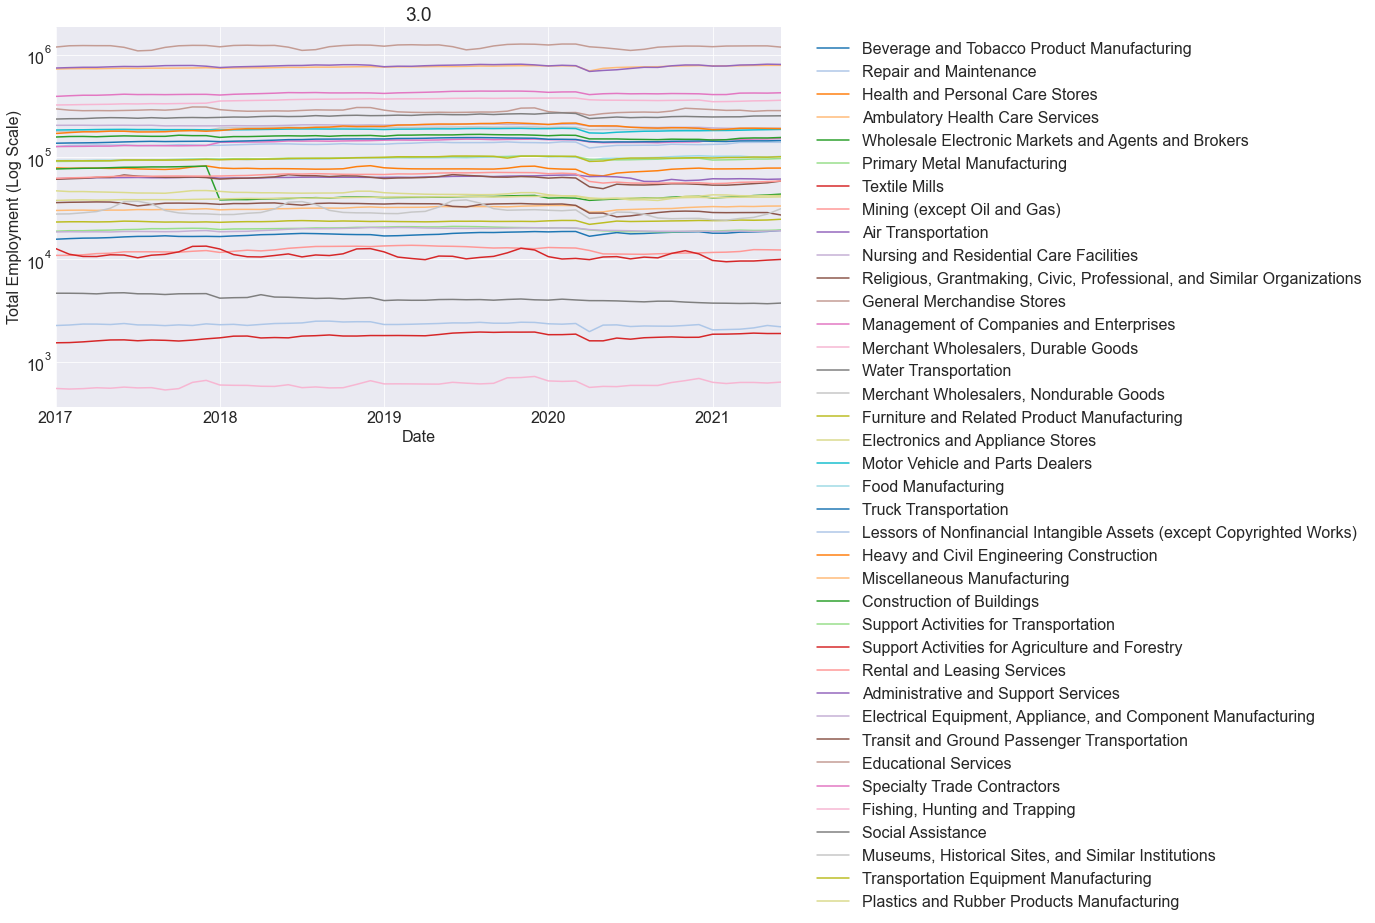

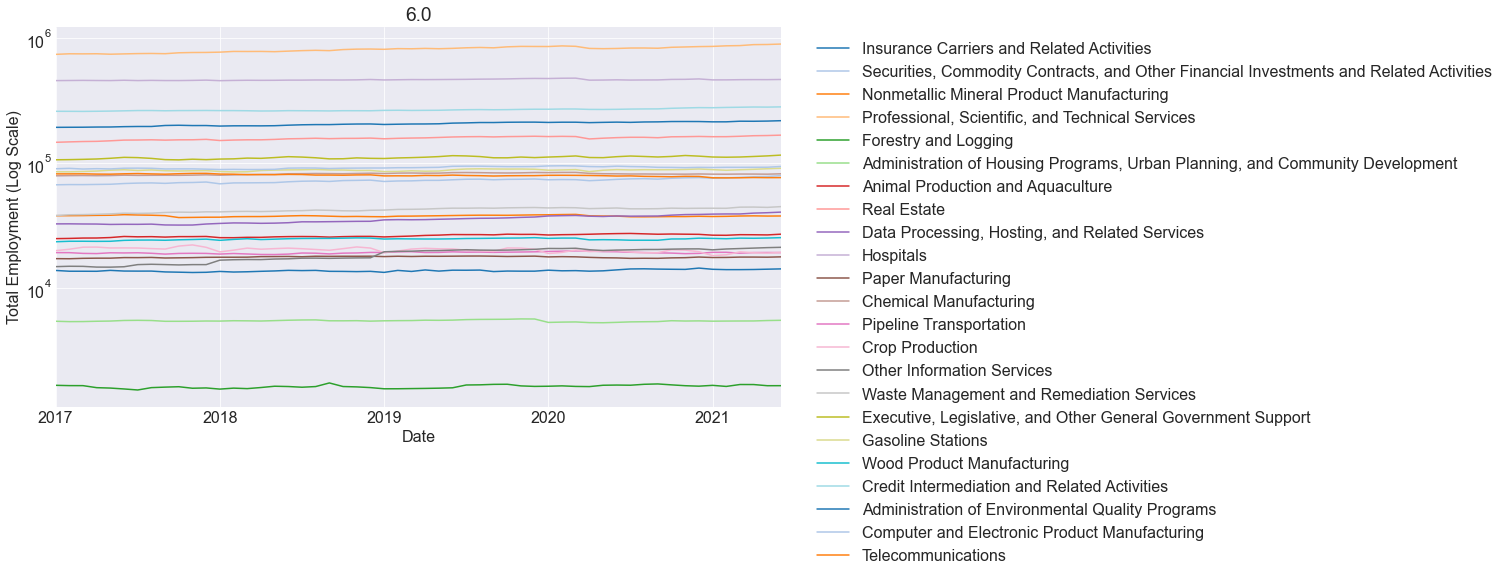

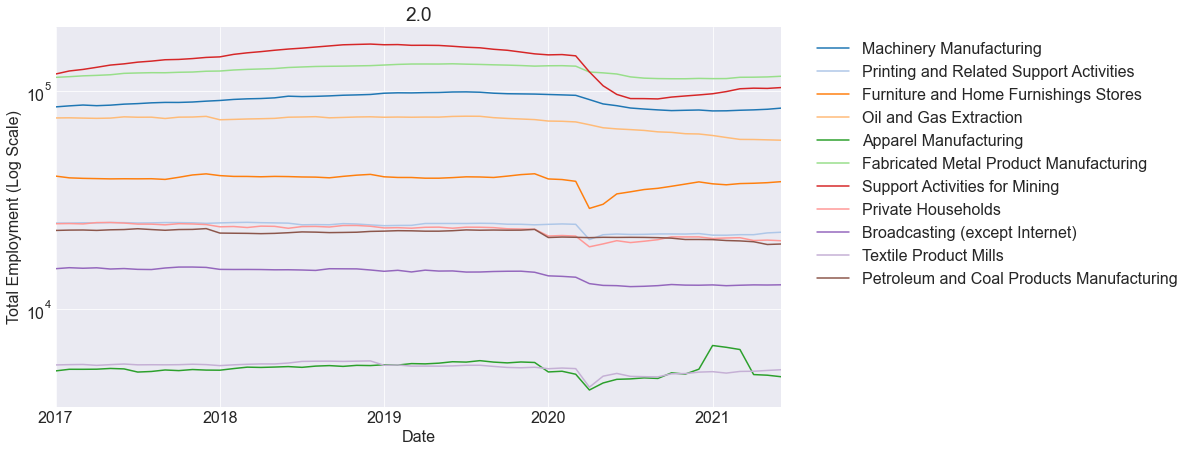

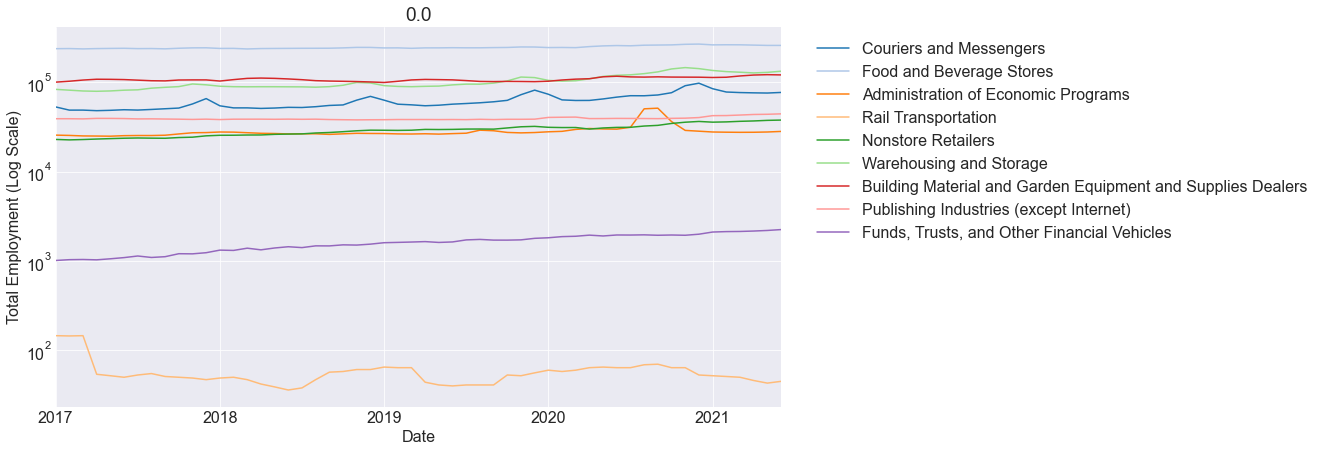

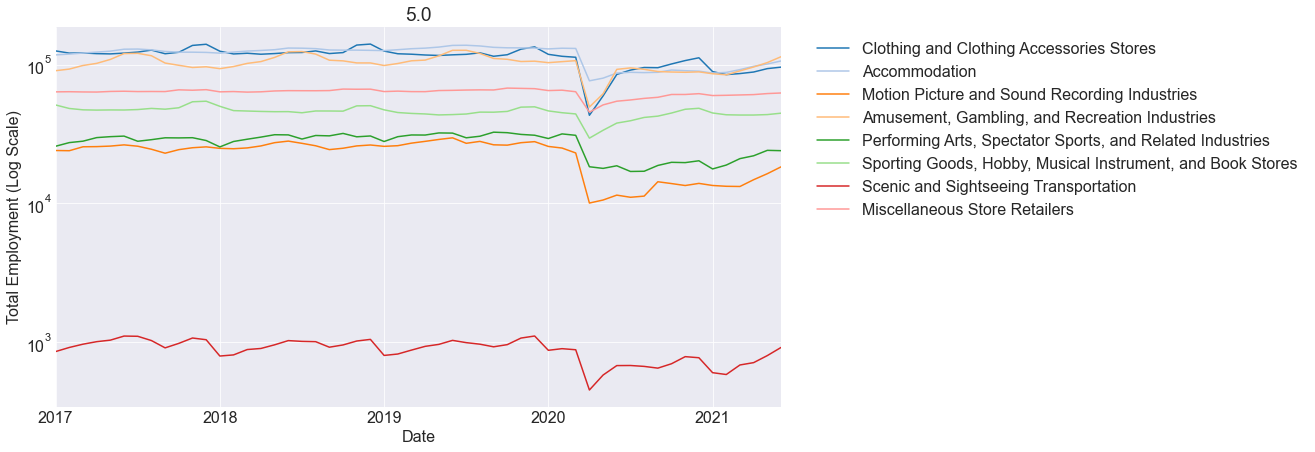

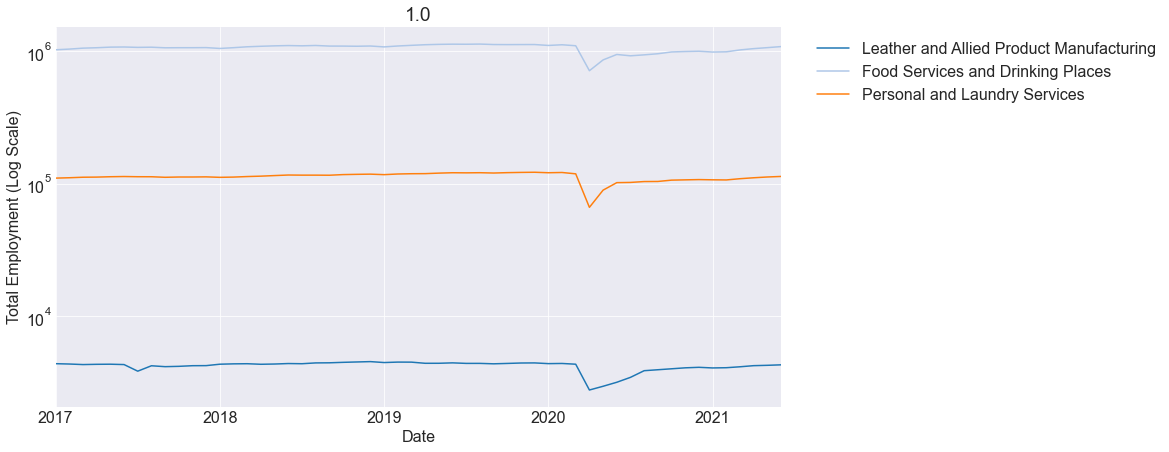

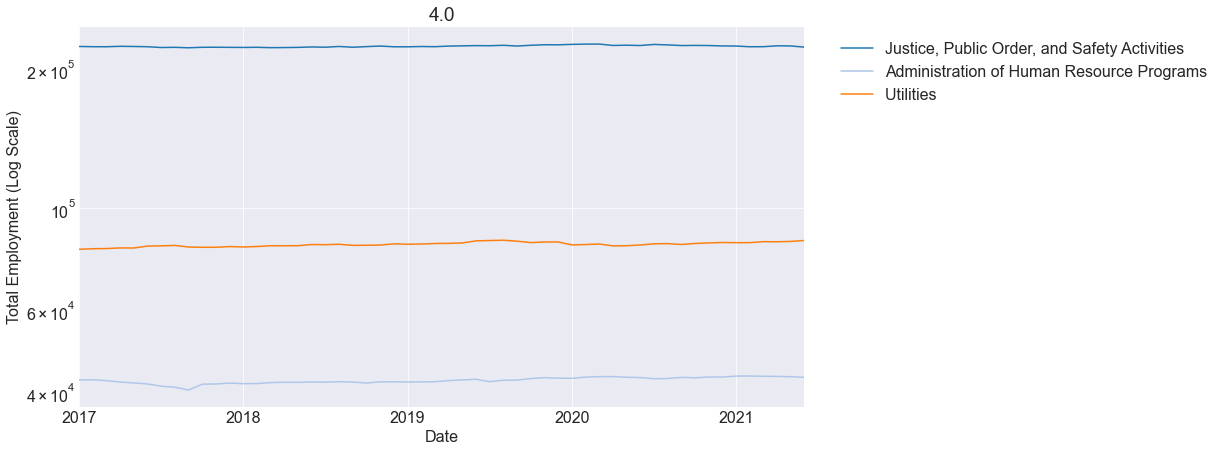

In [113]:
# create model object
kmeans1 = KMeans(n_clusters=7, random_state=527)

# fit the object to scaled, training data
kmeans1.fit(scaled_char_df)

# Use (predict using) the thing 
char_df['cluster_1'] = kmeans1.predict(scaled_char_df)
# scaled_char_df['cluster_1'] = kmeans1.predict(scaled_char_df)

# readable_label_dict = {
#     0 : 'Moderate Negative Impact, Quick Recovery',
#     1 : 'Positively Impacted',
#     2 : 'Significant Negative Impact, Mostly Recovered',
#     3 : 'Significant Negative Impact, Mostly Recovered, Highly Seasonal',
#     4 : 'No Impact',
#     5 : 'Moderate Negative Impact, Slow or No Recovery',
#     6 : 'Minor Negative Impact, Quick Recovery'
# }

# char_df['cluster_1'] = char_df['cluster_1'].map(readable_label_dict)

print(char_df.cluster_1.value_counts()) # take a look at distribution of clusters
print('\n')
print(char_df.cluster_1.value_counts(normalize=True)) # normalized
print('\n')

cluster_labels_dict = char_df[['cluster_1']].to_dict()['cluster_1'] # get dictionary of cluster labels for each industry
df['Cluster'] = df.Industry.map(cluster_labels_dict) # add new column to df with labels

df = df[df.Industry != 'Monetary Authorities-Central Bank'] # need to drop this since there was missing data for this industry
df = df[df.Industry != 'Unclassified'] # need to drop this since there was missing data for this industry

# df.Cluster = df.Cluster.astype('int') # cast as int
cluster_list = df.Cluster.value_counts().index.tolist() # create list of clusters
cluster_df_dict = {} # create empty dictionary for subset dfs for each cluster
for clust in cluster_list:
    cluster_df_dict[clust] = df[df.Cluster == clust] # add dfs to dictionary
    
for clust in cluster_list: # plot industries for each cluster on same chart
    ind_list = cluster_df_dict[clust].Industry.value_counts().index.tolist() # create list of industries present in this specific cluster
    industry_df_dict = {} # create empty dictionary to house dfs for each industry df from each cluster
    for ind in ind_list:
        industry_df_dict[ind] = cluster_df_dict[clust][cluster_df_dict[clust].Industry == ind] # add dfs for each industry present in each cluster to dictionary
    for ind in ind_list:
        industry_df_dict[ind][['Date', 'Total Employment']].set_index('Date')['Total Employment'].sort_index().plot(label=ind) # plot each industry
    plt.gca().set(ylabel = 'Total Employment (Log Scale)', title=f'{clust}')
    plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.2f}M'.format(x / 1_000_000))
    plt.yscale('log')
    plt.legend(bbox_to_anchor= (1.03,1))
    plt.show()

In [114]:
char_df[(char_df.index == 'Scenic and Sightseeing Transportation')\
        | (char_df.index == 'Clothing and Clothing Accessories Stores ')\
        | (char_df.index == 'Amusement, Gambling, and Recreation Industries')]

pcnt_decrease_mar_apr  \
Scenic and Sightseeing Transportation                       48.747153   
Clothing and Clothing Accessories Stores                    61.838901   
Amusement, Gambling, and Recreation Industries              53.675816   

                                                norm_slope_apr_jun  cov_2020  \
Scenic and Sightseeing Transportation                     0.157324  5.441671   
Clothing and Clothing Accessories Stores                  0.220982  4.117635   
Amusement, Gambling, and Recreation Industries            0.243056  5.224617   

                                                pct_b_min  pct_b_max  \
Scenic and Sightseeing Transportation           -0.412822   0.397359   
Clothing and Clothing Accessories Stores        -1.746514   0.431646   
Amusement, Gambling, and Recreation Industries  -0.614482   0.418188   

                                                cluster_1  
Scenic and Sightseeing Transportation                   5  
Clothing and Clothing Accessories Stores                5  
Amusement, Gambling, and Recreation Industries          5

#### Observations about this iteration:
- Feature set seems to encapsulate behaviour better theoretically, but not seeing as good of clusters
    - Maybe have some redundant features here?
    - Might work better when features are more programmatic?

---
#### This is a way that I can pull out time associated with min value in order to be able to get characterizations compared to future values

In [115]:
# industry_df_dict.keys()

In [116]:
# temp_s = industry_df_dict['Clothing and Clothing Accessories Stores '][['Date', 'Total Employment']].set_index('Date').sort_index()

In [117]:
# temp_s['2020'][temp_s['Total Employment'] == temp_s.min()[0]].index.tolist()[0]

In [118]:
# temp_s['2020']

What I am trying to do here:
- Find min value for each industry series
- Pull out date associated with that value
- Use that date to calculate new date of interest
    - One or two months into the future
    - To most recent data point
        - Would be able to get value easily, but would need date to calculate demominator (number of months) for slope
- Use new date to get value for calculation

---
## Different ways to customize colors of lines
---

In [119]:
# # check matplotlib version
# import matplotlib
# print('matplotlib: {}'.format(matplotlib.__version__))

# # get a cmap and pull out colors from it to save to a list and use with cycler
# cmap = matplotlib.cm.get_cmap('gist_rainbow')
# cmap

# # check number of lines needed here
# len(ind_list)

# # get list of colors
# colors = [cmap(i) for i in np.linspace(0, 1, 12)]

# # use cm.rainbow to generate another list of colors
# from matplotlib.pyplot import cm

# color = cm.rainbow(np.linspace(0, 1, 12))

# # # do the same thing for wages
# # from cycler import cycler


# # plt.gca().set_prop_cycle(cycler('color', colors))
# # for ind in ind_list:
# #     df_dict[ind][['Date', 'Total Employment']].set_index('Date')['Total Employment'].plot(label=ind)
# # plt.gca().set(ylabel = 'Total Employment', title='Level 1 Industries')
# # plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}M'.format(x / 1_000_000))
# # plt.legend(bbox_to_anchor= (1.03,1));

In [1]:
# Do I need to clean up this notebook?